# MACHINE LEARNING FOR PHYSICS



**JET TAGGING**

**Bryan Darwin Luna Bravo**

**Augusto Euclides Fienco Bacusoi**

In [ ]:
%%capture
!pip install graphviz
!pip install keras_tuner -q
!pip install keras-tuner
#!pip install comet_ml

In [369]:

import os
from sklearn.model_selection import train_test_split
from typing import List, Optional
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Flatten, Dense, Dropout,MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from tensorflow.keras.metrics import Precision, Recall, AUC, TopKCategoricalAccuracy
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
#from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_curve, label_binarize
from tabulate import tabulate
import tensorflow.keras.backend as K
from typing import Tuple, List,Union, Any
from tensorflow.keras.utils import plot_model
from itertools import cycle
from scipy import interp
from math import ceil
#----


# Connecting to Google Drive

The initial step involves establishing a connection between our Colab environment and Google Drive. This connection is crucial as it enables us to leverage Colab resources for data utilization during training.



In [370]:
!nvidia-smi

Mon Feb 12 08:25:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0              33W / 250W |  15806MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")


# **Analisys of Data**

## **Connection and Dataset Overview:**
Establishing a connection, our dataset comprises 6 ".npz" files, totaling 60,000 data points. To manage memory efficiently, we keep data separate for streamlined loading and transformations.



In [ ]:
path = '/content/gdrive/MyDrive/datasets/Jets'

#Manage Data Class

**The `NPZDatasetManager` Python class:**
 is designed for managing datasets stored in `.npz` files. During initialization, it takes the path of a directory containing `.npz` files and stores it as an instance variable. Its methods include listing these files, loading a specific file by index with the option to retrieve the paths again, and concatenating and saving all data into a single `.npz` file. The latter method prints the path where the resulting file is saved and issues a warning if the keys 'jetImages' and 'jetClass' are not found in the files. It's noteworthy that there is a commented line that can retrieve the list of files, depending on the user's needs.

In [ ]:
## NPZDatasetManager --->  funtions.py

class NPZDatasetManager:
    def __init__(self, path: str):
        """
        Initializes the NPZ dataset manager.
        Args:
            path (str): Path to the directory containing .npz files.
        """
        self.path = path
    def list_npz_files(self) -> List[str]:
        """
        Lists all .npz files in the specified directory.
        Returns:
            List[str]: List of full paths of the .npz files.
        """
        npz_files = [os.path.join(self.path, f) for f in os.listdir(self.path) if f.endswith('.npz')]
        print(f'Number of .npz files in the path: {len(npz_files)}')
        for file in npz_files:
            print(file)
        return npz_files

    def load_npz_by_index(self, index: int) -> Optional[dict]:
        """
        Loads a .npz file based on its index in the file list.
        Args:
            index (int): Index of the .npz file to load.
        Returns:
            Optional[dict]: Dictionary with data loaded from the .npz file, or None if the index is out of range.
        """
        #npz_files = self.list_npz_files()
        if index < 0 or index >= len(npz_files):
            print("Index out of range.")
            return None
        file_path = npz_files[index]
        dataset = np.load(file_path)
        print("Keys in the NPZ file:", list(dataset.keys()))
        return dataset
    def concatenate_and_save_all(self, save_path: str) -> None:
        """
        Concatenates 'jetImages' and 'jetClass' from all .npz files and
        saves the result in a single .npz file.
        Args:
            save_path (str): Path where the resulting .npz file will be saved.
        """
        jet_images = []
        jet_classes = []
        for file_path in self.list_npz_files():
            dataset = np.load(file_path)
            if "jetImages" in dataset and "jetClass" in dataset:
                jet_images.append(dataset["jetImages"])
                jet_classes.append(dataset["jetClass"])
            else:
                print(f"The keys 'jetImages' and/or 'jetClass' not found in {file_path}")
        jet_images = np.concatenate(jet_images)
        jet_classes = np.concatenate(jet_classes)
        np.savez(save_path, jetImages=jet_images, jetClass=jet_classes)
        print(f"Concatenated data saved in {save_path}")



In [ ]:

path = '/content/gdrive/MyDrive/datasets/Jets'
manager = NPZDatasetManager(path)

# List Files on the path
npz_files = manager.list_npz_files()

Number of .npz files in the path: 6
/content/gdrive/MyDrive/datasets/Jets/jetImage_7_100p_0_10000.npz
/content/gdrive/MyDrive/datasets/Jets/jetImage_7_100p_10000_20000.npz
/content/gdrive/MyDrive/datasets/Jets/jetImage_7_100p_30000_40000.npz
/content/gdrive/MyDrive/datasets/Jets/jetImage_7_100p_50000_60000.npz
/content/gdrive/MyDrive/datasets/Jets/jetImage_7_100p_60000_70000.npz
/content/gdrive/MyDrive/datasets/Jets/jetImage_7_100p_40000_50000.npz


In [ ]:
# Concatenate and save all .npz files if you need
save_path = "/path/to/save/concatenated_data.npz"
#manager.concatenate_and_save_all(save_path)

##**Working with a Data Subset:**
A subset of 10,000 data points ensures effective management, preventing memory saturation in Colab. This approach enhances work efficiency and mitigates challenges with larger datasets in the Colab environment.

In [ ]:
# Load the first .npz file
my_dataset = manager.load_npz_by_index(1)

Keys in the NPZ file: ['jetImage', 'jetClass']


## CLoud

#Understand Data

This code defines a dictionary representing particles in the field of particle physics, assigning a unique binary array to each particle type. Additionally, there is a dictionary, 'particle_dict', mapping particle names to numerical indices. The code also loads a dataset using a function named 'load_npz_by_index' and extracts variables 'var_x' and 'var_y' from the dataset.

In [ ]:
#dict of particle
particles = {
    "gluons": [1, 0, 0, 0, 0],
    "quarks": [0, 1, 0, 0, 0],
    "Ws":     [0, 0, 1, 0, 0],
    "Zs":     [0, 0, 0, 1, 0],
    "tops":   [0, 0, 0, 0, 1]
}
particle_dict = {
    "gluons": 0,
    "quarks": 1,
    "Ws":     2,
    "Zs":     3,
    "tops":   4
}


In [386]:
class_names = ["Gluons", "Quarks", "Ws", "Zs", "Tops"]

In [ ]:
my_dataset = manager.load_npz_by_index(1)

In [ ]:
my_dataset= np.load('/content/Jet Image 7 100p 0 10000.npz')
var_x = my_dataset['jetImage']
var_y = my_dataset['jetClass']

This class defines a class called ClassDistributionPlotter designed for visualizing the class distribution in a dataset. The class takes a matrix of binary labels as input, where each row corresponds to a data point, and each column represents a class. The main functionalities include mapping class labels to user-defined names, calculating class counts, and generating a bar plot using Seaborn to display the distribution of examples across different classes. The purpose is to provide a clear visual representation of how data is distributed among various classes in a dataset, aiding in understanding the class imbalance or distribution characteristics. The map_labels method associates user-defined class names with corresponding columns in the label matrix, and plot_distribution generates a bar plot with annotations for each class, presenting a concise summary of the dataset's class distribution.

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

class ClassDistributionPlotter:
    def __init__(self, labels):
        self.labels = labels
        self.class_names = None
        self.class_counts = None

    def map_labels(self, label_dict):
        self.class_names = list(label_dict.keys())
        self.class_counts = np.sum(self.labels, axis=0)

    def plot_distribution(self):
        if self.class_names is None or self.class_counts is None:
            raise ValueError("Class names and counts not set. Call map_labels() first.")

        data = pd.DataFrame({
            'Class': self.class_names,
            'Count': self.class_counts
        })

        # Set style and create a custom color palette
        sns.set(style="whitegrid")
        num_classes = len(self.class_names)
        palette = sns.color_palette("pastel", n_colors=num_classes)

        # Create a bar plot with Seaborn
        plt.figure(figsize=(10, 6))
        bar_plot = sns.barplot(x='Class', y='Count', data=data, palette=palette, legend=False)

        # Add annotations to the bars
        for p in bar_plot.patches:
            bar_plot.annotate(format(p.get_height(), '.0f'),
                              (p.get_x() + p.get_width() / 2., p.get_height()),
                              ha='center', va='center',
                              xytext=(0, 9),
                              textcoords='offset points')

        plt.title('Class Distribution in the Dataset')
        plt.xlabel('Classes')
        plt.ylabel('Number of Examples')
        plt.show()



This code snippet generates a class distribution plot for a dataset with binary labels (var_y). By utilizing the ClassDistributionPlotter class, it maps class labels to user-defined names and creates a bar plot, providing a concise visual representation of class distribution. This is valuable for assessing class imbalances and making informed decisions in machine learning tasks.

<ipython-input-10-52e80cb2f462>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Class', y='Count', data=data, palette=palette, legend=False)


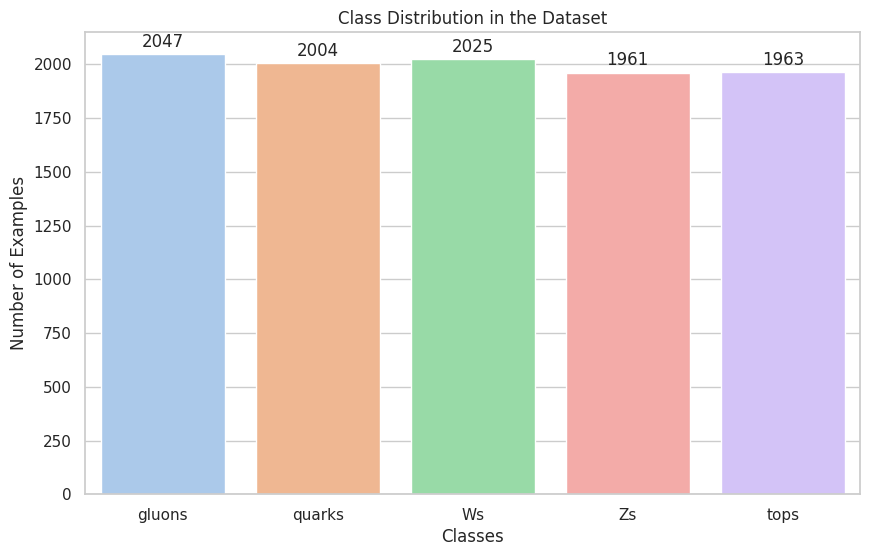

In [ ]:

# Create an instance of the ClassDistributionPlotter
plotter = ClassDistributionPlotter(var_y)
# Map labels to class names
plotter.map_labels(particle_dict)
# Plot the distribution
plotter.plot_distribution()



As evident, a minor imbalance exists in the quantity of images, which we prefer to rectify by discarding data corresponding to the class with fewer examples. This approach aims to achieve a balanced dataset. Although this results in a reduction in the number of images, it can be rectified subsequently through data augmentation techniques.

#Balanced of data

This class defines a BalancedDatasetSampler class aimed at addressing class imbalance in a dataset, particularly designed for NumPy arrays representing images and their corresponding labels. The balance_dataset method samples a fixed number of examples from each class, ensuring that the dataset is balanced across classes. This is crucial in machine learning scenarios where imbalanced datasets can lead to biased model training. The resulting balanced dataset, stored in balanced_images and balanced_labels, provides a more equitable distribution for training models, ultimately enhancing their generalization performance across different classes. The code also includes an optional shuffling step to further randomize the order of examples in the balanced dataset.

In [ ]:

class BalancedDatasetSampler:
    """
    A class for balancing a dataset by randomly sampling a fixed number of examples from each class.
    This version specifically handles NumPy arrays.

    Attributes:
    - images (np.ndarray): NumPy array of image data.
    - labels (np.ndarray): NumPy array of labels.
    - balanced_images (np.ndarray): NumPy array to store balanced image data.
    - balanced_labels (np.ndarray): NumPy array to store balanced labels.
    """

    def __init__(self, images: np.ndarray, labels: np.ndarray):
        """
        Initializes the BalancedDatasetSampler with NumPy arrays of image and label data.

        Args:
        - images (np.ndarray): NumPy array of image data.
        - labels (np.ndarray): NumPy array of labels.
        """
        if not isinstance(images, np.ndarray) or not isinstance(labels, np.ndarray):
            raise TypeError("Expected NumPy arrays as arguments")

        self.images = images
        self.labels = labels
        self.balanced_images = None
        self.balanced_labels = None

    def balance_dataset(self,shuffle=True) -> None:
        """
        Balances the dataset by randomly sampling a fixed number of examples from each class.
        The balanced data is stored in the attributes balanced_images and balanced_labels.
        """
        # Find the minimum number of examples in all classes
        min_samples = np.min(np.sum(self.labels, axis=0))

        # Convert min_samples to an integer
        min_samples = int(min_samples)

        # Initialize lists to store balanced data
        balanced_images = []
        balanced_labels = []

        for i in range(self.labels.shape[1]):  # Iterate over each class
            # Get indices of all examples from the current class
            class_indices = np.where(self.labels[:, i] == 1)[0]

            # Ensure there are enough examples in the current class
            if len(class_indices) >= min_samples:
                # Randomly choose 'min_samples' from these indices
                selected_indices = np.random.choice(class_indices, min_samples, replace=False)

                # Add the selected images and labels to the lists
                balanced_images.extend(self.images[selected_indices])
                balanced_labels.extend(self.labels[selected_indices])

        # Convert the lists to NumPy arrays
        self.balanced_images = np.array(balanced_images)
        self.balanced_labels = np.array(balanced_labels)

        #Shuffle the balanced dataset: Optional
        if shuffle:

          shuffle_indices = np.random.permutation(len(self.balanced_images))
          self.balanced_images = self.balanced_images[shuffle_indices]
          self.balanced_labels = self.balanced_labels[shuffle_indices]


In [ ]:

balanced_sampler = BalancedDatasetSampler(var_x, var_y)
balanced_sampler.balance_dataset(shuffle=False)
images = balanced_sampler.balanced_images
labels = balanced_sampler.balanced_labels


<ipython-input-10-52e80cb2f462>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Class', y='Count', data=data, palette=palette, legend=False)


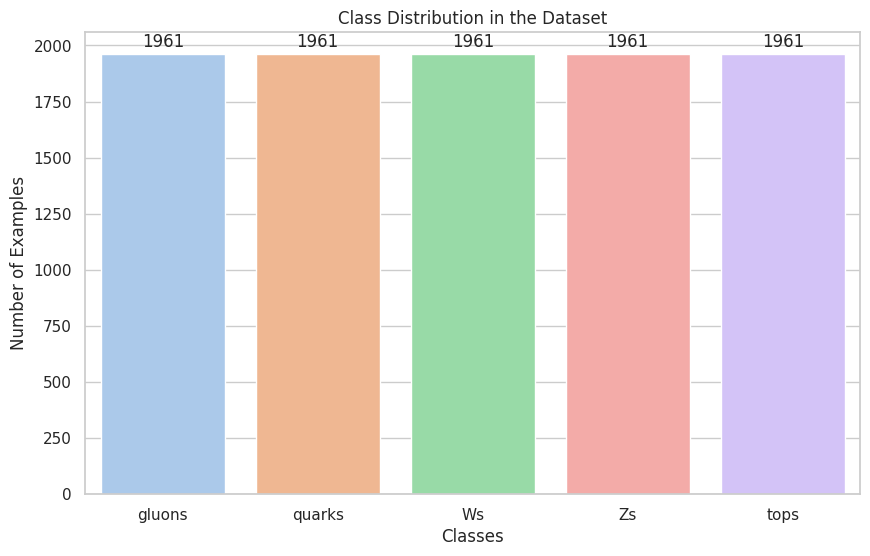

In [ ]:
# Create an instance of the ClassDistributionPlotter
plotter = ClassDistributionPlotter(labels)
# Map labels to class names
plotter.map_labels(particle_dict)
# Plot the distribution
plotter.plot_distribution()


#Start

## Description of Data


In the class NPZDatasetManager, we extract one of the files from the dataset. Since these files are in the numpy .npy format, we will create a method to analyze this data and determine its shape. Additionally, we will implement a method to add an extra channel. Given that the arrays in jetImages have a shape of (100, 100), we need to add a channel to work with them as images. To obtain an array of shape (100, 100, 1), we will implement this functionality.

In [ ]:
import numpy as np

def generate_dataset_info(images, labels):
    """
    Generates information about a dataset, including length, shape, and the shape of the first element.
    Args:
    - images (array): Array of image data.
    - labels (array): Array of labels.
    Returns:
    - str: Formatted information about the length, shape, and shape of the first element of images and labels.
    """
    # Check that the arguments are arrays
    if not isinstance(images, np.ndarray) or not isinstance(labels, np.ndarray):
        raise TypeError("Arrays are expected as arguments")
    info = (
        f"Length of images: {len(images)}\n"
        f"Shape of images: {images.shape}\n"
        f"Shape of the first element of images: {images[0].shape}\n"
        f"Length of labels: {len(labels)}\n"
        f"Shape of labels: {labels.shape}\n"
        f"Shape of the first element of labels: {labels[0].shape}"
    )

    return info

In [ ]:
info_result = generate_dataset_info(images, labels)
print(info_result)

Length of images: 9805
Shape of images: (9805, 100, 100)
Shape of the first element of images: (100, 100)
Length of labels: 9805
Shape of labels: (9805, 5)
Shape of the first element of labels: (5,)


## Changues Dimentions of data

### **Why?**

When working with matrices, it is preferable to introduce a new dimension, which will be considered as the image channel. This approach is adopted to enhance the representation and manipulation of the image data. By introducing a dedicated channel dimension, we enable a more structured and efficient handling of image information, contributing to improved clarity and ease of processing throughout the data pipeline.

In [ ]:
# Check if expanding the dimensions of the images is necessary
if images.ndim == 3:
    # Add a third axis for the channel
    images = np.expand_dims(images, axis=-1)

In [ ]:
info_result = generate_dataset_info(images, labels)
print(info_result)

Length of images: 9805
Shape of images: (9805, 100, 100, 1)
Shape of the first element of images: (100, 100, 1)
Length of labels: 9805
Shape of labels: (9805, 5)
Shape of the first element of labels: (5,)


##Split Data
This code defines a DatasetSplitter class in a file named functions.py. This class is designed to split a dataset into training, validation, and test sets based on the specified proportions of data allocation. It takes the sizes for the training, validation, and test sets as input during initialization, ensuring that their sum equals 1.0. The split_data method then splits the given arrays of images and labels into the specified sets, while also adjusting the validation size proportionally. It uses the scikit-learn library's train_test_split function for the data splitting process. Finally, the method returns a dictionary containing the split datasets, with the data converted to TensorFlow tensors of dtype tf.float32. This code ensures proper data allocation for training, validation, and testing in machine learning workflows.

In [ ]:
## DatasetSplitter --->  funtions.py

class DatasetSplitter:
    def __init__(self, train_size: float, val_size: float, test_size: float):
        """
        Initializes the DatasetSplitter object with sizes for the training, validation, and test sets.
        Args:
            train_size (float): Percentage of the dataset for the training set.
            val_size (float): Percentage of the dataset for the validation set.
            test_size (float): Percentage of the dataset for the test set.
        """
        if train_size + val_size + test_size != 1.0:
            raise ValueError("The sum of train_size, val_size, and test_size must be 1.")

        self.train_size = train_size
        self.val_size = val_size
        self.test_size = test_size

    def split_data(self, images, labels) -> dict:
        """
        Splits the data into training, validation, and test sets.

        Args:
            images (np.ndarray): Array of images.
            labels (np.ndarray): Array of labels.
        Returns:
            dict: A dictionary containing the split datasets.
                'X_train' (np.ndarray): Training set images.
                'X_val' (np.ndarray): Validation set images.
                'X_test' (np.ndarray): Test set images.
                'y_train' (np.ndarray): Training set labels.
                'y_val' (np.ndarray): Validation set labels.
                'y_test' (np.ndarray): Test set labels.
        """
        # First split into training+validation and test
        X_train_val, X_test, y_train_val, y_test = train_test_split(images, labels, test_size=self.test_size)

        # Now split the training+validation into training and validation
        val_size_adjusted = self.val_size / (1 - self.test_size)  # Validation size adjustment
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size_adjusted)

        print("Dimensions of the training set: ", X_train.shape)
        print("Dimensions of the validation set: ", X_val.shape)
        print("Dimensions of the test set: ", X_test.shape)
        """
        return {
            "X_train": X_train,
            "X_val": X_val,
            "X_test": X_test,
            "y_train": y_train,
            "y_val": y_val,
            "y_test": y_test
        }
        """
        return {
            "X_train": tf.convert_to_tensor(X_train, dtype=tf.float32),
            "X_val": tf.convert_to_tensor(X_val, dtype=tf.float32),
            "X_test": tf.convert_to_tensor(X_test, dtype=tf.float32),
            "y_train": tf.convert_to_tensor(y_train, dtype=tf.float32),
            "y_val": tf.convert_to_tensor(y_val, dtype=tf.float32),
            "y_test": tf.convert_to_tensor(y_test, dtype=tf.float32)
        }


An instance of the DatasetSplitter class is created with specified proportions for training (70%), validation (15%), and testing (15%) data. Then, the split_data method is called with arrays of images and labels as input, resulting in the dataset being split into three sets: training, validation, and test, following the specified proportions. This code demonstrates how to effectively use the DatasetSplitter class to partition data for machine learning tasks.

In [ ]:
# Using the class
splitter = DatasetSplitter(train_size=0.7, val_size=0.15, test_size=0.15)
splits = splitter.split_data(images, labels)


Dimensions of the training set:  (6863, 100, 100, 1)
Dimensions of the validation set:  (1471, 100, 100, 1)
Dimensions of the test set:  (1471, 100, 100, 1)


##Build data loader
Here is defined an ImageTransformer class in TensorFlow that offers various image transformation functions. These functions include normalize_by_max for channel-wise normalization of images, fft_transform_nch for applying Fast Fourier Transform (FFT) and concatenating magnitude spectra, and apply_transformset for applying a list of transformations, including optional normalization and FFT, to a set of images and their corresponding labels. The class allows users to preprocess and augment image data for machine learning tasks, such as resizing, normalization, and frequency domain analysis, enabling more robust and informative input features. An example usage is provided, where the ImageTransformer instance is utilized to transform a dataset of images and labels according to specified transformations, normalization, and FFT application preferences.

In [ ]:
import tensorflow as tf
class ImageTransformer:
    """
    A class for image transformations using TensorFlow.
    """
    def normalize_by_max(self, img):
        """
        Normalize each channel of the input image tensor by its maximum value.
        Args:
            img (tf.Tensor): Input image tensor.
        Returns:
            tf.Tensor: Normalized image tensor.
        """
        if not isinstance(img, tf.Tensor):
            raise TypeError("Input must be a TensorFlow tensor")

        normalized_channels = []
        for c in range(img.shape[-1]):
            channel = img[..., c]
            min_val = tf.reduce_min(channel)
            max_val = tf.reduce_max(channel)
            normalized_channel = (channel - min_val) / (max_val - min_val)
            normalized_channels.append(normalized_channel)

        normalized_img = tf.stack(normalized_channels, axis=-1)
        return normalized_img


    def normalize_by_max_global(self, data):
        """
        Normalize the input data tensor by its maximum value across all images.
        Args:
            data (tf.Tensor): Input data tensor containing multiple images.
        Returns:
            tf.Tensor: Normalized data tensor.
        """
        if not isinstance(data, tf.Tensor):
            raise TypeError("Input must be a TensorFlow tensor")


        min_val = tf.reduce_min(data)
        max_val = tf.reduce_max(data)
        normalized_data = (data - min_val) / (max_val - min_val)

        return normalized_data

    def fft_transform_nch(self, img):
        """
        Apply FFT transformation to the input image tensor.

        Args:
            img (tf.Tensor): Input image tensor.

        Returns:
            tf.Tensor: Transformed image tensor.
        """
        if not isinstance(img, tf.Tensor):
            raise TypeError("Input must be a TensorFlow tensor")

        fourier_transform = tf.signal.fft2d(tf.cast(img, tf.complex64))
        magnitude_spectrum = tf.math.abs(fourier_transform)
        new_tensor = tf.concat([img, magnitude_spectrum], axis=-1)

        return new_tensor


    def apply_transformset(self, X, y, transformation_list=None, normalize_each=False,normalize=True, apply_fft=False):
        """
        Apply a set of transformations to input images.

        Args:
            X (list): List of input images.
            y (list): List of labels corresponding to input images.
            transformation_list (list): List of transformation functions to apply.
            normalize_function (bool): Whether to normalize the images.
            apply_fft (bool): Whether to apply FFT transformation.

        Returns:
            tf.Tensor: Transformed input images tensor.
            tf.Tensor: Transformed labels tensor.
        """
        transformed_X = []
        transformed_y = []

        for x, label in zip(X, y):
            x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
            transformed_versions = [x_tensor]

            if transformation_list is not None:
                for trans in transformation_list:
                    x_trans = trans(x_tensor)
                    if x_trans.shape[1:3] != (100, 100):
                        x_trans = tf.image.resize(x_trans, [100, 100])
                    transformed_versions.append(x_trans)

            for x_trans in transformed_versions:
                if apply_fft:
                    x_trans = self.fft_transform_nch(x_trans)

                if normalize_each:
                    x_trans = self.normalize_by_max(x_trans)

                transformed_X.append(x_trans)
                transformed_y.append(label)

        if normalize:
              transformed_X = self.normalize_by_max_global(tf.convert_to_tensor(transformed_X, dtype=tf.float32))

        return tf.stack(transformed_X), tf.convert_to_tensor(transformed_y, dtype=tf.float32)


## Image Transformations

This code defines a list named `transformation_lay` containing a set of image transformation layers using TensorFlow's Keras API. These layers are intended for preprocessing images and include `CenterCrop`, which crops the central region of images to a specified height and width (in this case, 50x50 pixels). The commented-out line, `RandomRotation`, is an additional transformation layer that randomly rotates images to a certain degree. These transformation layers can be applied to image data as part of a neural network model or a data augmentation pipeline to modify and enhance the input data before feeding it into the model for training or inference.

In [ ]:

transformation_lay = [
    tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.041666667, fill_mode='reflect'),
    tf.keras.layers.experimental.preprocessing.CenterCrop(height=50, width=50),

]


In [ ]:
transformer = ImageTransformer()

## Image Transformation Application

The `ImageTransformer` instance, `transformer`, is utilized to apply a set of image transformations and preprocessing steps to the training, validation, and test datasets (`X_train`, `y_train`, `X_val`, `y_val`, `X_test`, `y_test`). The specified `transformation_lay` list includes a center crop transformation, and the `normalize_function` and `apply_fft` flags indicate that channel-wise normalization and Fast Fourier Transform (FFT) should be applied during the transformation process. The resulting transformed datasets (`X_train_transformed`, `y_train_transformed`, `X_val_transformed`, `y_val_transformed`, `X_test_transformed`, and `y_test_transformed`) now contain the preprocessed images and labels ready for use in machine learning models, with the specified transformations and preprocessing applied.

In [ ]:

X_train_transformed, y_train_transformed = transformer.apply_transformset(splits['X_train'], splits['y_train'],
                                                              transformation_list= transformation_lay,
                                                              normalize_each = False,
                                                              normalize=True,
                                                              apply_fft=False)



In [ ]:
X_train_transformed_info = generate_dataset_info(X_train_transformed.numpy(),
                                                 y_train_transformed.numpy())
print(X_train_transformed_info)

Length of images: 20589
Shape of images: (20589, 100, 100, 1)
Shape of the first element of images: (100, 100, 1)
Length of labels: 20589
Shape of labels: (20589, 5)
Shape of the first element of labels: (5,)


In [ ]:
X_val_transformed, y_val_transformed = transformer.apply_transformset(splits['X_val'], splits['y_val'],
                                                             transformation_list= transformation_lay,
                                                              normalize_each = False,
                                                              normalize=True,

                                                              apply_fft=False)

In [ ]:
X_val_transformed_info = generate_dataset_info(X_val_transformed.numpy(),
                                               y_val_transformed.numpy())
print(X_val_transformed_info)

Length of images: 4413
Shape of images: (4413, 100, 100, 1)
Shape of the first element of images: (100, 100, 1)
Length of labels: 4413
Shape of labels: (4413, 5)
Shape of the first element of labels: (5,)


In [ ]:
X_test_transformed, y_test_transformed = transformer.apply_transformset(splits['X_test'], splits['y_test'],
                                                              #transformation_list= transformation_lay, #--> is not't necesary for test data
                                                              normalize_each = False,
                                                              normalize=True,

                                                              apply_fft=False)



In [ ]:
X_test_transformed.shape

TensorShape([1471, 100, 100, 1])

In [ ]:
X_test_transformed_info = generate_dataset_info(X_test_transformed.numpy(),
                                               y_test_transformed.numpy()
                                               )
print(X_test_transformed_info)

Length of images: 1471
Shape of images: (1471, 100, 100, 1)
Shape of the first element of images: (100, 100, 1)
Length of labels: 1471
Shape of labels: (1471, 5)
Shape of the first element of labels: (5,)


**Dataset Creation and Processing with TensorFlow's tf.data.Dataset API**

The preprocessed and transformed training, test, and validation data are used to create dataset objects (`train_dataset`, `test_dataset`, and `val_dataset`) through TensorFlow's `tf.data.Dataset` API. Subsequently, these datasets are further processed into data loaders (`train_loader`, `test_loader`, and `val_loader) with specified batch sizes. This facilitates efficient loading and batching of data during the training and evaluation phases of machine learning models. Additionally, the training dataset is shuffled to ensure randomness during training, which can contribute to the enhancement of model learning.

In [ ]:
n_batch= 128
train_loader = tf.data.Dataset.from_tensor_slices((X_train_transformed, y_train_transformed)).shuffle(buffer_size=len(X_train_transformed)).batch(n_batch)
val_loader = tf.data.Dataset.from_tensor_slices((X_val_transformed, y_val_transformed)).batch(n_batch)
test_loader = tf.data.Dataset.from_tensor_slices((X_test_transformed, y_test_transformed)).batch(n_batch)

## Dimensional Verification

The code iterates through a data loader in batches, where each batch consists of a set of images (`X`) and their corresponding labels (`y`). Within the loop, it prints the shape of the batched images (`X`) and the shape along with the data type of the labels (`y`). The output furnishes information regarding the dimensions of the image batch (in the format [batch_size, channels, height, width]) and details about the shape and data type of the labels. This process is valuable for comprehending the structure of the test data, ensuring alignment with the expected format, and validating the data types for the model.

In [ ]:
def print_batch_shapes(loader, data_type):
    for X, y in loader:
        print(f"#--- {data_type} batch's shapes---------------")
        print(f"Shape of X [N,  H, W ,C]: {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}")
        break

print_batch_shapes(train_loader, "Training")
print_batch_shapes(val_loader, "Validation")
print_batch_shapes(test_loader, "Testing")


#--- Training batch's shapes---------------
Shape of X [N,  H, W ,C]: (64, 100, 100, 1)
Shape of y: (64, 5) <dtype: 'float32'>
#--- Validation batch's shapes---------------
Shape of X [N,  H, W ,C]: (64, 100, 100, 1)
Shape of y: (64, 5) <dtype: 'float32'>
#--- Testing batch's shapes---------------
Shape of X [N,  H, W ,C]: (64, 100, 100, 1)
Shape of y: (64, 5) <dtype: 'float32'>


## Vizualization of images and tranforms

Defines a function visualize_image_channels that visualizes individual channels of the first image in a batch of images and checks whether the pixel values are correctly normalized between 0 and 1. It takes as input a batch of images (images) and their corresponding labels (labels). The function iterates over each channel of the first image in the batch, displaying each channel as a grayscale image and printing the minimum and maximum pixel values for that channel. It also checks if the pixel values are within the normalized range of [0, 1] and provides feedback on whether each channel is correctly normalized. This code is useful for inspecting image channels and their pixel value ranges for quality control and debugging purposes in image-based machine learning tasks.

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

def visualize_image_channels(images, labels, num_images=3):
    """
    Visualizes individual channels of the first 'num_images' images in a batch and checks pixel value normalization.
    Args:
        images (tf.Tensor): A batch of images with shape [batch_size, H, W, C].
        labels (tf.Tensor): Corresponding labels of the images.
        num_images (int): Number of images to visualize.

    The function iterates over each channel of the first 'num_images' images in the provided batch.
    It displays each channel as a grayscale image and prints the minimum and maximum pixel values for that channel.
    It also checks if the pixel values are normalized between 0 and 1.
    """
    for i in range(num_images):
        # Get the i-th image and its label from the batch
        current_image = images[i]
        current_label = labels[i].numpy()

        # Create a horizontal subplot for each channel in the image
        fig, axs = plt.subplots(1, current_image.shape[-1], figsize=(10, 5))

        # Check if axs is not iterable (single subplot)
        if not isinstance(axs, np.ndarray):
            axs = [axs]

        # Iterate over each channel in the image (assuming the format [H, W, C])
        for channel_idx in range(current_image.shape[-1]):
            image_channel = current_image[..., channel_idx]

            # Display the channel in the subplot without grid and axis ticks
            axs[channel_idx].imshow(image_channel.numpy(), cmap='gray')
            axs[channel_idx].set_title(f"Channel {channel_idx + 1}")
            axs[channel_idx].axis('off')  # Turn off axis ticks and labels

        # Set the overall title for the subplot
        fig.suptitle(f"Image {i + 1} - Label: {current_label}")

        plt.show()

        # Print minimum and maximum pixel values after showing the images
        for channel_idx in range(current_image.shape[-1]):
            image_channel = current_image[..., channel_idx]
            min_pixel_value = tf.reduce_min(image_channel).numpy()
            max_pixel_value = tf.reduce_max(image_channel).numpy()
            print(f"Min pixel value in channel {channel_idx + 1}: {min_pixel_value}")
            print(f"Max pixel value in channel {channel_idx + 1}: {max_pixel_value}")
            if 0 <= min_pixel_value <= 1 and 0 <= max_pixel_value <= 1:
                print(f"Channel {channel_idx + 1} is correctly normalized")
            else:
                print(f'Channel {channel_idx + 1} is not normalized correctly')


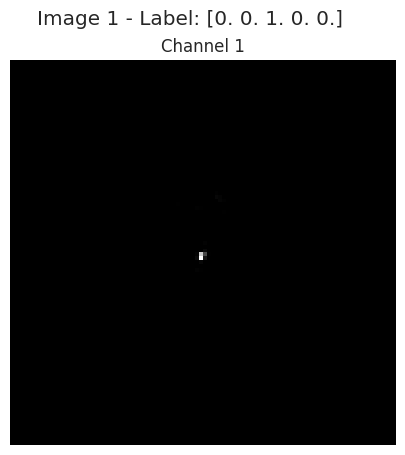

Min pixel value in channel 1: 0.0
Max pixel value in channel 1: 0.2899828255176544
Channel 1 is correctly normalized


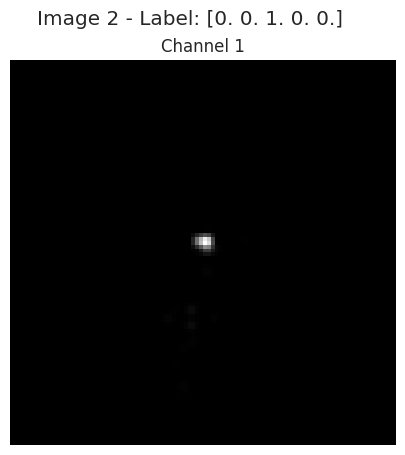

Min pixel value in channel 1: 0.0
Max pixel value in channel 1: 0.26100778579711914
Channel 1 is correctly normalized


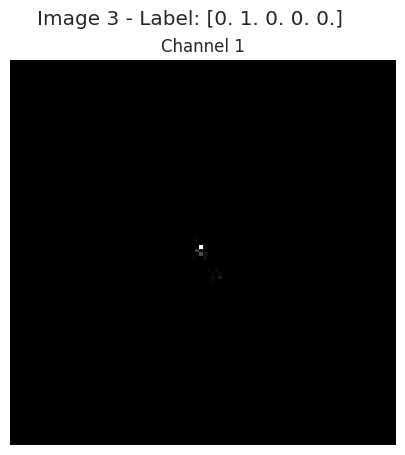

Min pixel value in channel 1: 0.0
Max pixel value in channel 1: 0.33851903676986694
Channel 1 is correctly normalized


In [ ]:

# Assuming train_loader is a TensorFlow data loader with batches of images and labels
for images, labels in train_loader.take(1):
    visualize_image_channels(images, labels, num_images=3)

## Custom TensorFlow Model Training Class: ModelTrainer

This code introduces a specialized TensorFlow model training class, `ModelTrainer`, engineered to streamline the training and evaluation processes for deep learning models. The class is configured to accept input parameters such as a neural network model, loss function, optimizer, optional learning rate scheduler, and callbacks.

The `train` method orchestrates the training phase on a specified dataset, iterating through batches, computing gradients, and updating model weights. It also meticulously tracks training loss and accuracy metrics.

Subsequently, the `val` method assesses the model's performance on a validation dataset, computing validation loss and accuracy metrics.

The `fit` method seamlessly integrates the training and validation procedures over a user-defined number of epochs, with provision for callbacks to tailor behavior during training. This could include functionalities such as model checkpoints or dynamic learning rate adjustments.

Overall, the `ModelTrainer` class offers a well-structured approach to model training and evaluation, simplifying the monitoring and control of the training process. It ensures the seamless tracking of relevant metrics and facilitates the incorporation of callbacks, contributing to a more effective and customizable deep learning model training experience.

In [ ]:


class ModelTrainer(tf.keras.Model):
    """
    Class for training and evaluating TensorFlow models.

    Args:
        model (tf.keras.Model): The model to train and evaluate.
        loss_fn (tf.keras.losses.Loss): Loss function used during training and evaluation.
        optimizer (tf.keras.optimizers.Optimizer): Optimizer for updating the model weights.
        scheduler (tf.keras.optimizers.schedules.LearningRateSchedule, optional): Optional learning rate scheduler.
        callbacks (List[tf.keras.callbacks.Callback], optional): List of callback objects for customizing training.
    """

    def __init__(self, model: tf.keras.Model, loss_fn: tf.keras.losses.Loss, optimizer: tf.keras.optimizers.Optimizer,
                 scheduler: tf.keras.optimizers.schedules.LearningRateSchedule = None,
                 callbacks: List[tf.keras.callbacks.Callback] = None):
        super(ModelTrainer, self).__init__()
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.callbacks = callbacks or []

    def train(self, dataloader: tf.data.Dataset) -> Tuple[float, float]:
        """
        Train the model on a training dataset.

        Args:
            dataloader (tf.data.Dataset): DataLoader providing batches of training data.

        Returns:
            Tuple: Training loss and accuracy after training.
        """
        num_batches = len(dataloader)
        train_loss_metric = tf.keras.metrics.Mean()
        train_accuracy_metric = tf.keras.metrics.CategoricalAccuracy()

        @tf.function
        def train_step(X: tf.Tensor, y: tf.Tensor) -> None:
            with tf.GradientTape() as tape:
                pred = self.model(X)
                loss = self.loss_fn(y, pred)
            gradients = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
            train_loss_metric(loss)
            train_accuracy_metric(y, pred)

        self.model.trainable = True

        with tqdm(total=num_batches, desc="Training   ", unit="batch") as pbar:
            for batch_idx, (X, y) in enumerate(dataloader):
                train_step(X, y)
                pbar.update(1)

                # Print metrics at each batch
                current_loss = train_loss_metric.result().numpy()
                current_acc = train_accuracy_metric.result().numpy()
                pbar.set_postfix(Loss=current_loss, Accuracy=f"{current_acc * 100:.2f}%")

        train_loss = train_loss_metric.result().numpy()
        train_accuracy = train_accuracy_metric.result().numpy() * 100
        return train_loss, train_accuracy

    def val(self, dataloader: tf.data.Dataset) -> Tuple[float, float]:
        """
        Evaluate the model on a validation dataset.

        Args:
            dataloader (tf.data.Dataset): DataLoader providing batches of validation data.

        Returns:
            Tuple: Validation loss and accuracy after evaluation.
        """
        num_batches = len(dataloader)
        test_loss_metric = tf.keras.metrics.Mean()
        test_accuracy_metric = tf.keras.metrics.CategoricalAccuracy()

        self.model.trainable = False

        @tf.function
        def test_step(X: tf.Tensor, y: tf.Tensor) -> None:
            pred = self.model(X)
            loss = self.loss_fn(y, pred)
            test_loss_metric(loss)
            test_accuracy_metric(y, pred)

        with tqdm(total=num_batches, desc="Validation", unit="batch") as pbar:
            for X, y in dataloader:
                test_step(X, y)
                pbar.update(1)

        test_loss = test_loss_metric.result().numpy()
        test_accuracy = test_accuracy_metric.result().numpy() * 100
        print(f"Validation - Accuracy: {test_accuracy:.1f}%, Avg Loss: {test_loss:.8f}")
        return test_loss, test_accuracy

    def fit(self, train_loader: tf.data.Dataset, test_loader: tf.data.Dataset, epochs: int) -> dict:
        """
        Train the model on a training dataset and evaluate on a validation dataset.

        Args:
            train_loader (tf.data.Dataset): DataLoader providing batches of training data.
            test_loader (tf.data.Dataset): DataLoader providing batches of validation data.
            epochs (int): Number of training epochs.

        Returns:
            dict: History of loss and accuracy during training and validation.
        """
        for callback in self.callbacks:
            callback.set_model(self.model)
            callback.on_train_begin()

        train_losses, train_accuracies, test_losses, test_accuracies = [], [], [], []

        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}\n---------------------------------------------------------------------------------------------------")
            train_loss, train_accuracy = self.train(train_loader)
            test_loss, test_accuracy = self.val(test_loader)

            logs = {'loss': train_loss, 'accuracy': train_accuracy, 'val_loss': test_loss, 'val_accuracy': test_accuracy}
            for callback in self.callbacks:
                callback.on_epoch_end(epoch, logs)

            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)
            test_losses.append(test_loss)
            test_accuracies.append(test_accuracy)

        return {'loss': train_losses, 'accuracy': train_accuracies, 'val_loss': test_losses, 'val_accuracy': test_accuracies}


## Training Plotter
Defines a TrainingPlotter class that takes a training result object (typically containing loss and accuracy metrics) as input and provides a method plot_metrics() to visualize the training and validation loss as well as accuracy over epochs. The class creates a side-by-side plot with two subplots: one for loss and another for accuracy. It then plots the training and validation curves for both loss and accuracy.

In [ ]:


class TrainingPlotter:
    """Class to plot training metrics such as loss and accuracy."""
    def __init__(self, training_result: dict) -> None:
        """Initializes the plotter with training results.
        Args:
            training_result (dict): A history object containing training metrics.
        """
        self.result = training_result

    def plot_metrics(self) -> None:
        """Plots the training and validation loss and accuracy."""
        # Plotting the loss
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(self.result.history['loss'], label='Training Loss')
        plt.plot(self.result.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        # Plotting the accuracy
        plt.subplot(1, 2, 2)
        plt.plot(self.result.history['accuracy'], label='Training Accuracy')
        plt.plot(self.result.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()


#Models

##Model1


In [ ]:
import tensorflow as tf
from typing import Tuple


class NeuralNetwork1(tf.keras.Model):
    def __init__(self, num_classes: int = 5, num_neurons: int = 20, input_shape: Tuple[int, int, int] = (100, 100, 1), **kwargs):
        super(NeuralNetwork1, self).__init__(**kwargs)
        self.conv1 = tf.keras.layers.Conv2D(32, kernel_size=3, strides=1, padding='same', input_shape=input_shape)
        self.conv2 = tf.keras.layers.Conv2D(64, kernel_size=3, strides=1, padding='same')

        self.pool = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)

        self.fc1 = tf.keras.layers.Dense(100)

        self.fc2 = tf.keras.layers.Dense(30)
        self.fc3 = tf.keras.layers.Dense(num_neurons)

        self.fc4 = tf.keras.layers.Dense(num_classes)

    def call(self, x: tf.Tensor, training: bool = False) -> tf.Tensor:
        x = tf.nn.relu(self.conv1(x))
        x = self.pool(x)
        x = tf.nn.relu(self.conv2(x))
        x = self.pool(x)

        x = tf.keras.layers.Flatten()(x)

        x = tf.nn.relu(self.fc1(x))
        #x = self.drop1(x, training=training)  # Fixed the usage of the dropout layer
        x = tf.nn.relu(self.fc2(x))
        #x = self.drop2(x, training=training)

        x = self.fc3(x)
        x = self.fc4(x)
        return tf.nn.softmax(x, axis=1)


### Using our trainer class
a neural network model (model1) is instantiated, and a loss function (CategoricalCrossentropy) along with an optimizer (Adam) are defined for training. Additionally, a callback for model checkpointing is created, which saves the model with the highest validation accuracy during training.

A ModelTrainer instance (trainer) is then created, taking the model, loss function, optimizer, and callbacks as inputs. The fit method is used to train the model on the training data (train_loader) and evaluate it on the validation data (val_loader) over 50 epochs, while monitoring and saving the best model based on validation accuracy.

This code provides a structured approach to train a neural network model, allowing for customization through callbacks, and it saves the best-performing model for later use.

In [ ]:
from typing import List

# Instance of the model
model1 = NeuralNetwork1()

# Define loss and optimizer
loss_fn= tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/Models/modelo1',
                                       save_best_only=True,
                                       monitor='val_accuracy',
                                       mode='max'),
]

# Instance of the trainer
trainer = ModelTrainer(model1, loss_fn, optimizer, callbacks=callbacks)

# Use the fit method for training, passing the callbacks
results = trainer.fit(train_loader, val_loader, epochs=50)


Epoch 1
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 10.22batch/s]


Validation - Accuracy: 42.2%, Avg Loss: 1.31577957
Epoch 2
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 12.22batch/s]


Validation - Accuracy: 55.7%, Avg Loss: 1.12915683
Epoch 3
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:01<00:00,  9.66batch/s]


Validation - Accuracy: 56.4%, Avg Loss: 1.07850027
Epoch 4
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 12.30batch/s]


Validation - Accuracy: 60.1%, Avg Loss: 1.02155244
Epoch 5
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 12.10batch/s]


Validation - Accuracy: 61.6%, Avg Loss: 0.98207170
Epoch 6
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 12.33batch/s]


Validation - Accuracy: 62.1%, Avg Loss: 0.98758745
Epoch 7
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 12.13batch/s]


Validation - Accuracy: 60.5%, Avg Loss: 1.02156520
Epoch 8
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 12.24batch/s]


Validation - Accuracy: 63.5%, Avg Loss: 0.96070880
Epoch 9
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 12.08batch/s]


Validation - Accuracy: 64.2%, Avg Loss: 0.94171393
Epoch 10
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 11.87batch/s]


Validation - Accuracy: 65.3%, Avg Loss: 0.97818214
Epoch 11
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 11.24batch/s]


Validation - Accuracy: 61.9%, Avg Loss: 1.06647599
Epoch 12
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 11.40batch/s]


Validation - Accuracy: 62.9%, Avg Loss: 0.99762058
Epoch 13
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 12.12batch/s]


Validation - Accuracy: 63.0%, Avg Loss: 1.06294203
Epoch 14
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 11.33batch/s]


Validation - Accuracy: 62.1%, Avg Loss: 1.10456419
Epoch 15
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 12.19batch/s]


Validation - Accuracy: 62.9%, Avg Loss: 1.20005667
Epoch 16
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 12.06batch/s]


Validation - Accuracy: 64.4%, Avg Loss: 1.10516787
Epoch 17
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 11.97batch/s]


Validation - Accuracy: 64.3%, Avg Loss: 1.10279346
Epoch 18
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 11.78batch/s]


Validation - Accuracy: 62.0%, Avg Loss: 1.33271837
Epoch 19
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 11.73batch/s]


Validation - Accuracy: 63.0%, Avg Loss: 1.24265265
Epoch 20
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 11.97batch/s]


Validation - Accuracy: 62.7%, Avg Loss: 1.42569911
Epoch 21
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 10.92batch/s]


Validation - Accuracy: 62.5%, Avg Loss: 1.48573303
Epoch 22
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 10.90batch/s]


Validation - Accuracy: 62.3%, Avg Loss: 1.58869529
Epoch 23
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 11.88batch/s]


Validation - Accuracy: 62.9%, Avg Loss: 1.64824831
Epoch 24
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:01<00:00,  9.84batch/s]


Validation - Accuracy: 61.1%, Avg Loss: 2.01552033
Epoch 25
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 10.98batch/s]


Validation - Accuracy: 61.9%, Avg Loss: 1.74831891
Epoch 26
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 12.06batch/s]


Validation - Accuracy: 63.3%, Avg Loss: 1.85568392
Epoch 27
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 12.05batch/s]


Validation - Accuracy: 61.1%, Avg Loss: 2.24037671
Epoch 28
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 12.15batch/s]


Validation - Accuracy: 61.6%, Avg Loss: 2.42011333
Epoch 29
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 11.06batch/s]


Validation - Accuracy: 60.8%, Avg Loss: 2.43480301
Epoch 30
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 11.14batch/s]


Validation - Accuracy: 62.9%, Avg Loss: 2.32584429
Epoch 31
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:01<00:00,  8.08batch/s]


Validation - Accuracy: 63.5%, Avg Loss: 2.61501622
Epoch 32
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 11.41batch/s]


Validation - Accuracy: 63.1%, Avg Loss: 2.22834015
Epoch 33
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 12.30batch/s]


Validation - Accuracy: 63.5%, Avg Loss: 2.56004453
Epoch 34
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 11.22batch/s]


Validation - Accuracy: 62.5%, Avg Loss: 2.35904860
Epoch 35
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 11.36batch/s]


Validation - Accuracy: 64.1%, Avg Loss: 2.62899327
Epoch 36
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 12.26batch/s]


Validation - Accuracy: 62.7%, Avg Loss: 2.58876085
Epoch 37
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 11.04batch/s]


Validation - Accuracy: 62.3%, Avg Loss: 3.00305963
Epoch 38
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 12.15batch/s]


Validation - Accuracy: 62.7%, Avg Loss: 3.41474676
Epoch 39
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 12.20batch/s]


Validation - Accuracy: 61.1%, Avg Loss: 3.22548556
Epoch 40
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 11.33batch/s]


Validation - Accuracy: 63.3%, Avg Loss: 2.43579721
Epoch 41
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 12.14batch/s]


Validation - Accuracy: 62.6%, Avg Loss: 3.21636653
Epoch 42
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:01<00:00,  7.19batch/s]


Validation - Accuracy: 62.5%, Avg Loss: 3.08016086
Epoch 43
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 12.05batch/s]


Validation - Accuracy: 61.9%, Avg Loss: 3.11298513
Epoch 44
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 11.04batch/s]


Validation - Accuracy: 62.7%, Avg Loss: 3.23988223
Epoch 45
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 11.98batch/s]


Validation - Accuracy: 61.6%, Avg Loss: 3.50783420
Epoch 46
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 12.20batch/s]


Validation - Accuracy: 60.7%, Avg Loss: 3.27794313
Epoch 47
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 11.34batch/s]


Validation - Accuracy: 59.9%, Avg Loss: 3.28242445
Epoch 48
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 10.63batch/s]


Validation - Accuracy: 60.0%, Avg Loss: 3.30005383
Epoch 49
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 11.47batch/s]


Validation - Accuracy: 60.4%, Avg Loss: 3.45961952
Epoch 50
---------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:00<00:00, 11.50batch/s]


Validation - Accuracy: 61.9%, Avg Loss: 3.50440741


###Using de base fit method of tf  (better than ours Model trainer)

Two instances of the NeuralNetwork1 model (model1_1 and model1) are created. Several callbacks are defined, including a model checkpoint callback to save the best model based on validation accuracy, an early stopping callback to halt training if the validation accuracy does not improve for a certain number of epochs, and a learning rate scheduler callback to adjust the learning rate during training.

The model is then compiled with stochastic gradient descent (SGD) as the optimizer, a categorical cross-entropy loss function, and accuracy as the evaluation metric. Finally, the fit method is used to train the model on the training data (train_loader) while validating on the test data (test_loader) for 150 epochs. The defined callbacks are employed to monitor and control the training process, allowing for early stopping and dynamic learning rate scheduling.

### Train

In [ ]:
model1 = NeuralNetwork1()


callbacks1 = [
    tf.keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/Models/model1_1Ch',
                                       save_best_only=True,
                                       monitor='val_accuracy',
                                       mode='max'),

    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                     patience=50,
                                     mode='max'),


]

#optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

model1.compile(optimizer=optimizer,
               loss=loss_fn,
               metrics=['accuracy'])

# Train the model
result1= model1.fit(train_loader,
                    validation_data=val_loader,
                    epochs=100,
                    callbacks=callbacks1)


Epoch 1/100
159/159 [==============================] - 19s 70ms/step - loss: 1.3552 - accuracy: 0.4235 - val_loss: 1.2888 - val_accuracy: 0.4738
Epoch 2/100
159/159 [==============================] - 5s 30ms/step - loss: 1.1926 - accuracy: 0.5072 - val_loss: 1.2619 - val_accuracy: 0.4663
Epoch 3/100
159/159 [==============================] - 6s 38ms/step - loss: 1.1200 - accuracy: 0.5453 - val_loss: 1.2158 - val_accuracy: 0.5094
Epoch 4/100
159/159 [==============================] - 6s 38ms/step - loss: 1.0602 - accuracy: 0.5810 - val_loss: 1.2168 - val_accuracy: 0.5232
Epoch 5/100
159/159 [==============================] - 6s 39ms/step - loss: 1.0345 - accuracy: 0.5919 - val_loss: 1.1157 - val_accuracy: 0.5748
Epoch 6/100
159/159 [==============================] - 5s 30ms/step - loss: 0.9939 - accuracy: 0.6170 - val_loss: 1.1975 - val_accuracy: 0.5269
Epoch 7/100
159/159 [==============================] - 5s 30ms/step - loss: 0.9474 - accuracy: 0.6417 - val_loss: 1.1876 - val_accuracy

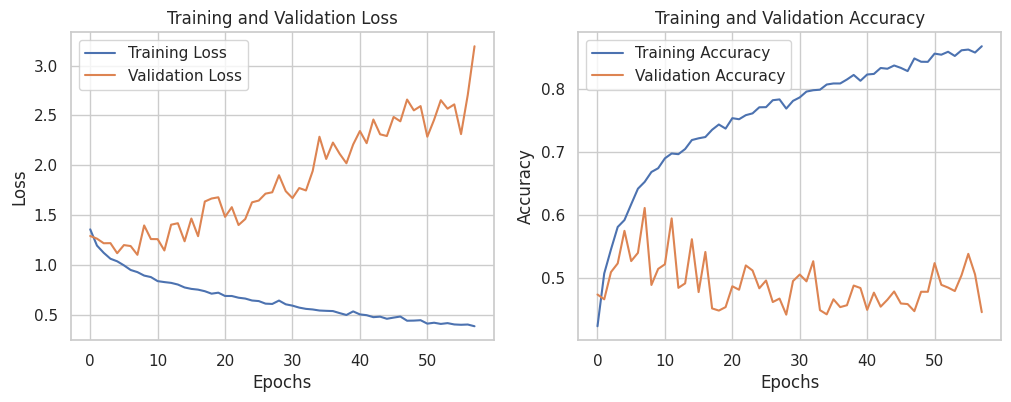

In [ ]:
plotter = TrainingPlotter(result1)
plotter.plot_metrics()

138/138 [==============================] - 1s 8ms/step


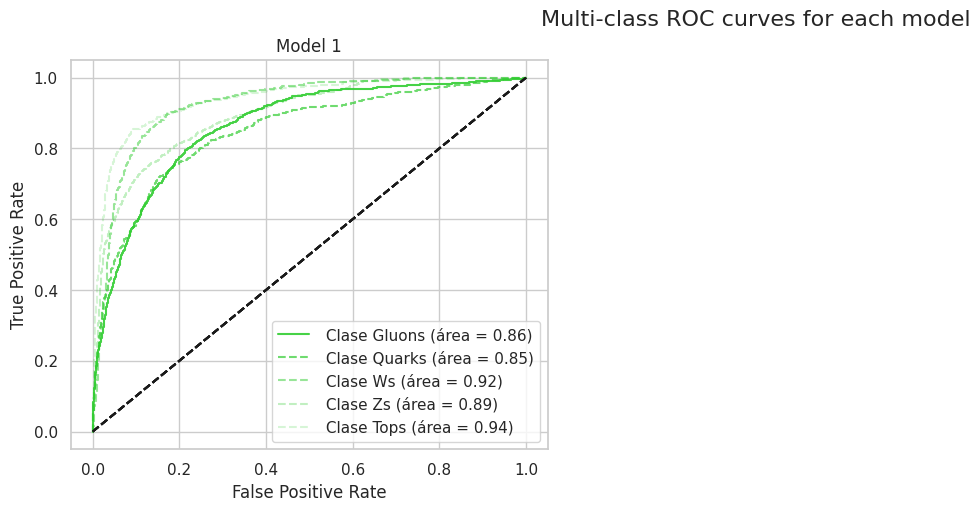

In [404]:
plot_multiclass_roc([model1],
                    class_names=class_names ,
                    data= (X_val_transformed, y_val_transformed),
                    each=True)

##Model 2


### Callbacks

In [389]:


#------------------------------------------------------------------------------------------------#
warmup_epochs = 5     # Define the number of warm-up epochs and total epochs
total_epochs = 150.   # Define the initial learning rate
initial_learning_rate = 1e-3  # You can adjust this value as needed

# Configure learning rate scheduling during warm-up epochs
warmup_lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
                              initial_learning_rate=1e-6,               # This is the initial learning rate for warm-up
                              decay_steps=warmup_epochs,                # Number of decay steps, usually equal to the number of warm-up epochs
                              end_learning_rate=initial_learning_rate,  # The learning rate at the end of warm-up, which will be the initial learning rate for the rest of the training
                              power=1.0 )                               # Power for polynomial decay. 1.0 means linear decay

# Define the scheduler function that adjusts the learning rate after warm-up
def scheduler(epoch):
    if epoch < warmup_epochs:
        return warmup_lr_schedule(epoch)
    else:
        # Adjust the learning rate based on some function, here exponential decay is used as an example
        return initial_learning_rate * tf.math.exp(0.1 * (warmup_epochs - epoch))


# Create a LearningRateScheduler callback that adjusts the learning rate at each epoch
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)


#------------------------------------------------------------------------------------------------#
# Create a ReduceLROnPlateau callback
lr_scheduleRO = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6 )


#------------------------------------------------------------------------------------------------#
# Define the exponential decay learning rate schedule
lr_scheduleExp = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True )


In [449]:
class NeuralNetwork2(tf.keras.Model):
    def __init__(self, num_classes: int = 5, num_neurons: int = 50, input_shape: Tuple[int, int, int] = (100, 100, 1), **kwargs):
        super(NeuralNetwork2, self).__init__(**kwargs)
        self.conv1 = tf.keras.layers.Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')
        self.pool = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)
        self.conv2 = tf.keras.layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')
        self.drop1 = tf.keras.layers.Dropout(0.8)  # Dropout
        self.drop2 = tf.keras.layers.Dropout(0.6)  #  Dropout
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(100, activation='relu')
        self.fc2 = tf.keras.layers.Dense(300, activation='relu')
        self.fc3 = tf.keras.layers.Dense(num_neurons, activation='relu')
        self.fc4 = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs: tf.Tensor, training: bool = False) -> tf.Tensor:
        x = self.conv1(inputs)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.drop1(x, training=training)
        x = self.fc2(x)
        x = self.drop2(x, training=training)
        x = self.fc3(x)  # Si necesitas usar fc3
        return self.fc4(x)


### Train

In [450]:
model2 = NeuralNetwork2()
# Callbacks
callbacks2 = [
              tf.keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/Models/modelo2_1Ch',
                                                save_best_only=True,
                                                monitor='val_accuracy',
                                                mode='max'),

              tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=80,
                                              mode='max'),

              lr_scheduleRO

             ]

#optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
#loss funtions
loss_fn = tf.keras.losses.CategoricalCrossentropy()

model2.compile(optimizer=optimizer,
               loss=loss_fn,
               metrics=['accuracy'])

# Train the model2
result2= model2.fit(train_loader,
                    validation_data=val_loader,
                    epochs=250,
                    callbacks=callbacks2)


Epoch 1/250
161/161 [==============================] - 10s 49ms/step - loss: 1.5971 - accuracy: 0.2421 - val_loss: 1.5464 - val_accuracy: 0.3166 - lr: 1.0000e-04
Epoch 2/250
161/161 [==============================] - 8s 49ms/step - loss: 1.5026 - accuracy: 0.3358 - val_loss: 1.4491 - val_accuracy: 0.3716 - lr: 1.0000e-04
Epoch 3/250
161/161 [==============================] - 10s 60ms/step - loss: 1.4585 - accuracy: 0.3666 - val_loss: 1.4168 - val_accuracy: 0.3986 - lr: 1.0000e-04
Epoch 4/250
161/161 [==============================] - 8s 51ms/step - loss: 1.4263 - accuracy: 0.3823 - val_loss: 1.3799 - val_accuracy: 0.3893 - lr: 1.0000e-04
Epoch 5/250
161/161 [==============================] - 7s 44ms/step - loss: 1.4045 - accuracy: 0.4030 - val_loss: 1.3556 - val_accuracy: 0.4274 - lr: 1.0000e-04
Epoch 6/250
161/161 [==============================] - 9s 59ms/step - loss: 1.3797 - accuracy: 0.4199 - val_loss: 1.3265 - val_accuracy: 0.4344 - lr: 1.0000e-04
Epoch 7/250
161/161 [===========

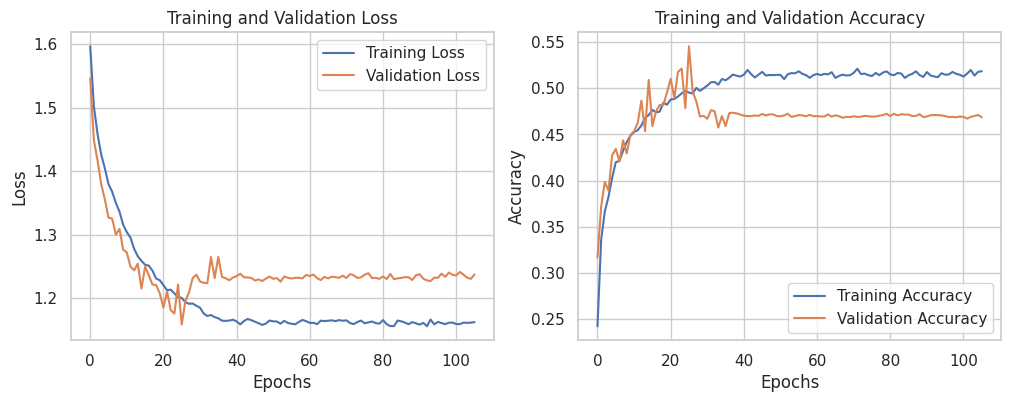

In [456]:
plotter = TrainingPlotter(result2)
plotter.plot_metrics()

138/138 [==============================] - 3s 21ms/step


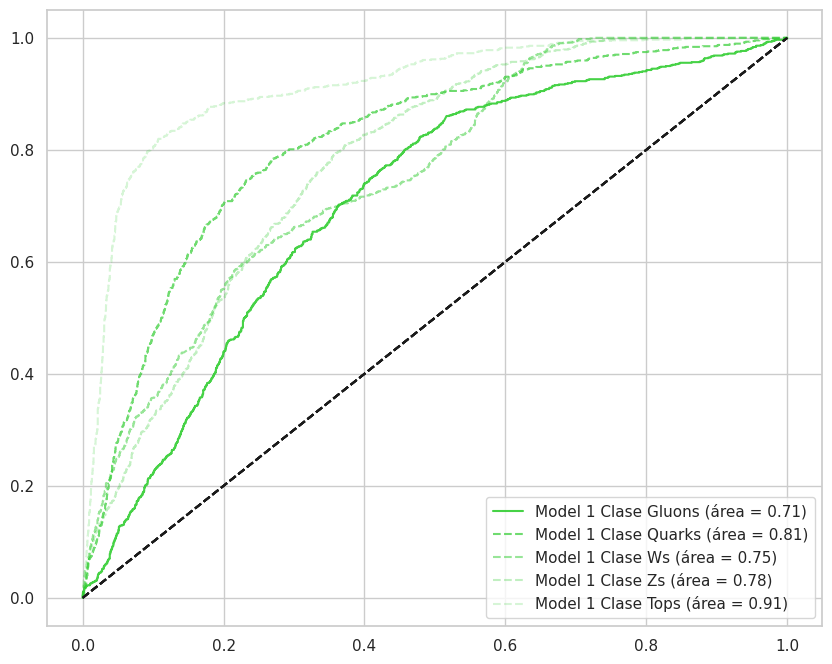

In [457]:
plot_multiclass_roc([model2],
                    class_names=class_names ,
                    data= (X_val_transformed, y_val_transformed),
                    each=False)

##Model 3


In [ ]:
import tensorflow as tf
from typing import Tuple

class NeuralNetwork3(tf.keras.Model):
    def __init__(self, num_classes: int = 5, input_shape: Tuple[int, int, int] = (100, 100, 1), **kwargs):
        super(NeuralNetwork3, self).__init__(**kwargs)
        # Inicializa las capas en el constructor
        self.conv1 = tf.keras.layers.Conv2D(32, kernel_size=3, strides=1, padding='same', activation=None, input_shape=input_shape)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)

        self.conv2 = tf.keras.layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation=None)
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.pool2 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)

        self.conv3 = tf.keras.layers.Conv2D(128, kernel_size=3, strides=1, padding='same', activation=None)
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.pool3 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)

        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(300, activation='relu')
        self.drop1 = tf.keras.layers.Dropout(0.5)
        self.fc2 = tf.keras.layers.Dense(100, activation='relu')
        self.drop2 = tf.keras.layers.Dropout(0.3)
        self.fc3 = tf.keras.layers.Dense(150, activation='relu')
        self.fc4 = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs: tf.Tensor, training: bool = False) -> tf.Tensor:
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)  # Aplicar la activación después de la BN
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = tf.nn.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x, training=training)
        x = tf.nn.relu(x)
        x = self.pool3(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.drop1(x, training=training)
        x = self.fc2(x)
        x = self.drop2(x, training=training)
        x = self.fc3(x)
        return self.fc4(x)

model3 = NeuralNetwork3()

This code defines a set of callbacks for model training, including ModelCheckpoint to save the best model based on validation accuracy, EarlyStopping to stop training early if validation accuracy plateaus, and a commented-out ReduceLROnPlateau callback for reducing the learning rate during training. It then specifies the loss function and optimizer for the model and creates an instance of ModelTrainer. Finally, it uses the fit method of ModelTrainer to train the model on the specified training and test data loaders for a specified number of epochs, while monitoring the provided callbacks to control training and save the best model checkpoints based on validation accuracy.

In [ ]:

#------------------------------------------------------------------------------------------------#
# Create a ReduceLROnPlateau callback
lr_scheduleRO = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=1e-6 )



In [ ]:
#model3 = NeuralNetwork3()
# Callbacks
callbacks3 = [
    tf.keras.callbacks.ModelCheckpoint('/content/MODELS/model3_ch1-',
                                       save_best_only=True,
                                       monitor='val_loss',
                                       mode='min'),

    tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                     patience=30,
                                     mode='min'),
    # Learning Rate Scheduler
    lr_scheduleRO

]

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

model3.compile(optimizer=optimizer,
               loss=loss_fn,
               metrics=['accuracy',
                        Precision(),
                                Recall(),
                                AUC(),])


# Train the model
result3= model3.fit(train_loader,
                    validation_data=val_loader,
                    epochs=180,
                    callbacks=callbacks3)


Epoch 1/180
322/322 [==============================] - 13s 30ms/step - loss: 1.4640 - accuracy: 0.3755 - precision_4: 0.5451 - recall_4: 0.1184 - auc_4: 0.7111 - val_loss: 2.5317 - val_accuracy: 0.2060 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_auc_4: 0.5263 - lr: 0.0010
Epoch 2/180
322/322 [==============================] - 7s 21ms/step - loss: 1.2538 - accuracy: 0.4566 - precision_4: 0.6293 - recall_4: 0.2095 - auc_4: 0.7952 - val_loss: 84.8131 - val_accuracy: 0.1931 - val_precision_4: 0.1931 - val_recall_4: 0.1931 - val_auc_4: 0.4957 - lr: 0.0010
Epoch 3/180
322/322 [==============================] - 7s 21ms/step - loss: 1.1638 - accuracy: 0.4917 - precision_4: 0.6337 - recall_4: 0.2641 - auc_4: 0.8233 - val_loss: 200.8167 - val_accuracy: 0.2060 - val_precision_4: 0.2060 - val_recall_4: 0.2060 - val_auc_4: 0.5011 - lr: 0.0010
Epoch 4/180
322/322 [==============================] - 7s 21ms/step - loss: 1.1226 - accuracy: 0.5253 - precision_4: 0.6450 - recall_4: 0.3

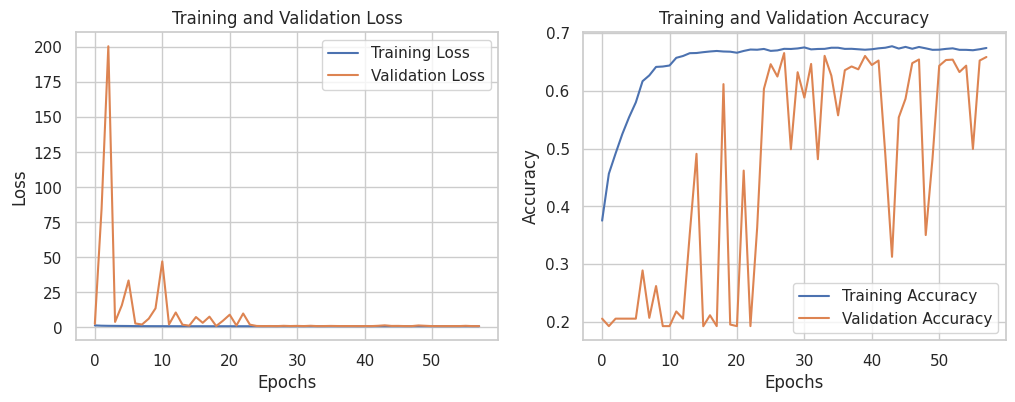

In [406]:
plotter = TrainingPlotter(result3)
plotter.plot_metrics()

138/138 [==============================] - 0s 3ms/step


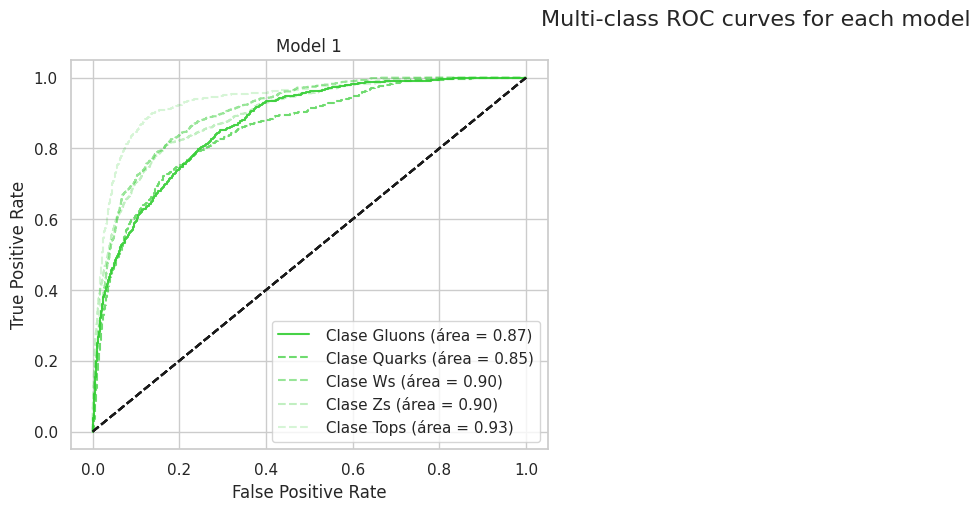

In [407]:
plot_multiclass_roc([model3],
                    class_names=class_names ,
                    data= (X_val_transformed, y_val_transformed),
                    each=True)

##Model 4


In [ ]:
class NeuralNetwork4(tf.keras.Model):
    def __init__(self, num_classes: int = 5, num_neurons: int = 50, input_shape: Tuple[int, int, int] = (100, 100, 1), **kwargs):
        super(NeuralNetwork4, self).__init__(**kwargs)
        self.conv1 = tf.keras.layers.Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')
        self.pool = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)
        self.conv2 = tf.keras.layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')
        self.drop1 = tf.keras.layers.Dropout(0.7)  # Dropout
        self.drop2 = tf.keras.layers.Dropout(0.6)  #  Dropout
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(100, activation='relu')
        self.fc2 = tf.keras.layers.Dense(170, activation='relu')
        self.fc3 = tf.keras.layers.Dense(num_neurons, activation='relu')
        self.fc4 = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs: tf.Tensor, training: bool = False) -> tf.Tensor:
        x = self.conv1(inputs)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.drop1(x, training=training)
        x = self.fc2(x)
        x = self.drop2(x, training=training)
        x = self.fc3(x)
        return self.fc4(x)


In [ ]:
# Create a ReduceLROnPlateau callback
lr_scheduleRO = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6 )


model4 = NeuralNetwork4()
# Callbacks
callbacks4 = [
              tf.keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/Models/modelo4_1Ch',
                                                save_best_only=True,
                                                monitor='val_accuracy',
                                                mode='max'),

              tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=80,
                                              mode='max'),

              lr_scheduleRO

             ]

#optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
#loss funtions
loss_fn = tf.keras.losses.CategoricalCrossentropy()

model4.compile(optimizer=optimizer,
               loss=loss_fn,
               metrics=['accuracy'])

# Train the model2
result4= model4.fit(train_loader,
                    validation_data=val_loader,
                    epochs=250,
                    callbacks=callbacks4)


Epoch 1/250
322/322 [==============================] - 8s 18ms/step - loss: 1.5734 - accuracy: 0.2727 - val_loss: 1.4800 - val_accuracy: 0.3762 - lr: 1.0000e-04
Epoch 2/250
322/322 [==============================] - 5s 16ms/step - loss: 1.4554 - accuracy: 0.3599 - val_loss: 1.3972 - val_accuracy: 0.3963 - lr: 1.0000e-04
Epoch 3/250
322/322 [==============================] - 5s 16ms/step - loss: 1.4055 - accuracy: 0.3978 - val_loss: 1.3502 - val_accuracy: 0.4330 - lr: 1.0000e-04
Epoch 4/250
322/322 [==============================] - 4s 12ms/step - loss: 1.3683 - accuracy: 0.4191 - val_loss: 1.3184 - val_accuracy: 0.4292 - lr: 1.0000e-04
Epoch 5/250
322/322 [==============================] - 5s 16ms/step - loss: 1.3465 - accuracy: 0.4290 - val_loss: 1.2933 - val_accuracy: 0.4473 - lr: 1.0000e-04
Epoch 6/250
322/322 [==============================] - 4s 12ms/step - loss: 1.3224 - accuracy: 0.4473 - val_loss: 1.2780 - val_accuracy: 0.4435 - lr: 1.0000e-04
Epoch 7/250
322/322 [=============

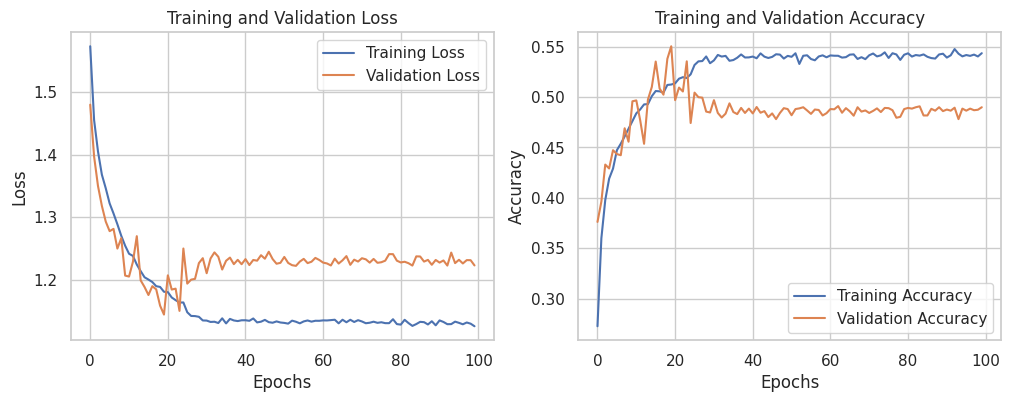

In [451]:
plotter = TrainingPlotter(result4)
plotter.plot_metrics()

138/138 [==============================] - 1s 4ms/step


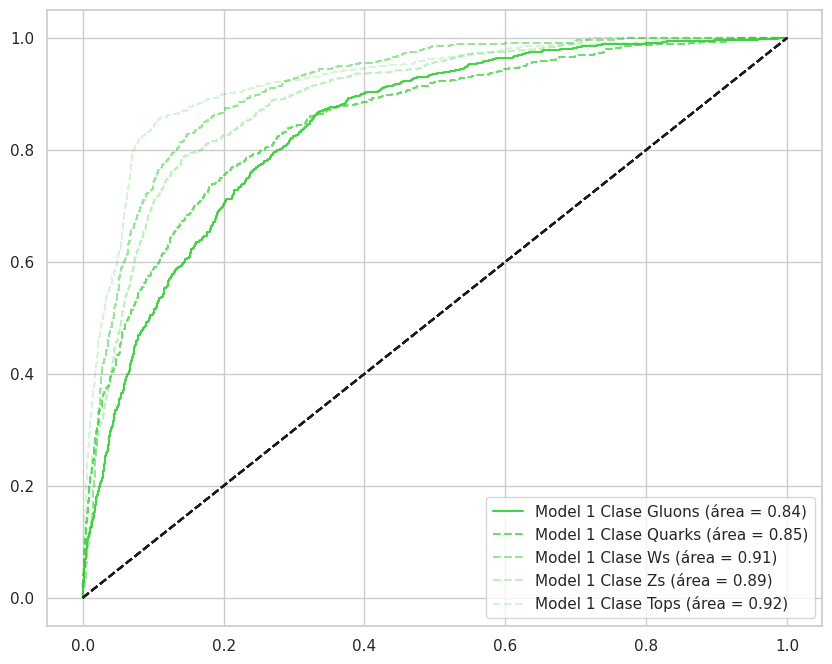

In [532]:
model4 = tf.keras.models.load_model('/content/MODELS/modelo4_1Ch')
plot_multiclass_roc([model4],
                    class_names=class_names ,
                    data= (X_val_transformed, y_val_transformed),
                    each=False)

In [ ]:
#

## Model 5

In [424]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Add, MaxPooling2D, Flatten, Dropout, Dense
from typing import Tuple

class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, num_filters,kernel_size=(3, 3), strides=(1, 1), use_conv_shortcut=False):
        super(ResidualBlock, self).__init__()
        self.conv1 = Conv2D(num_filters, kernel_size, strides=strides, padding='same', activation='relu')
        self.conv2 = Conv2D(num_filters, kernel_size, strides=strides, padding='same', activation='relu')
        self.add = Add()

        self.use_conv_shortcut = use_conv_shortcut
        if self.use_conv_shortcut:
            self.conv_shortcut = Conv2D(num_filters, (1, 1), strides=strides, padding='same')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)

        if self.use_conv_shortcut:
            identity = self.conv_shortcut(inputs)
        else:
            identity = inputs

        return self.add([x, identity])

class Network5(tf.keras.Model):
    def __init__(self,dense1=256, dense2=128, input_shape: Tuple[int, int, int] = (100, 100, 1)):
        super(Network5, self).__init__()
        self.conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')
        self.pool1 = MaxPooling2D(2, 2)

        self.res_block1 = ResidualBlock(128, use_conv_shortcut=True)
        self.pool3 = MaxPooling2D(2, 2)

        self.res_block2 = ResidualBlock(256, use_conv_shortcut=True)
        self.pool4 = MaxPooling2D(2, 2)

        self.flatten = Flatten()
        self.dropout = Dropout(0.3)
        self.dense1 = Dense(dense1, activation='relu')
        self.dense2 = Dense(dense2, activation='relu')
        self.dense3 = Dense(5, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.pool1(x)

        x = self.res_block1(x)
        x = self.pool3(x)

        x = self.res_block2(x)
        x = self.pool4(x)

        x = self.flatten(x)
        x = self.dropout(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)  # Ensure the final dense layer with 5 units and softmax is used
        return x  # Fixed: Return the result of the last dense layer

# Create an instance of the model
model5 = Network5()


In [426]:

# Callbacks
callbacks5 = [
    tf.keras.callbacks.ModelCheckpoint('/content/MODELS/modelo5_ch1',
                                       save_best_only=True,
                                       monitor='val_accuracy',
                                       mode='max'),

    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                     patience=30,
                                     mode='max'),
    # Learning Rate Scheduler
    tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 0.9 ** epoch)
]

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

model5.compile(optimizer=optimizer,
               loss=loss_fn,
               metrics=['accuracy'])

# Train the model
result5= model5.fit(train_loader,
                    validation_data=test_loader,
                    epochs=150,
                    callbacks=callbacks5)


Epoch 1/150
161/161 [==============================] - 33s 187ms/step - loss: 1.3834 - accuracy: 0.4157 - val_loss: 1.2538 - val_accuracy: 0.4630 - lr: 1.0000e-04
Epoch 2/150
161/161 [==============================] - 30s 184ms/step - loss: 1.2183 - accuracy: 0.4941 - val_loss: 1.2337 - val_accuracy: 0.4949 - lr: 9.0000e-05
Epoch 3/150
161/161 [==============================] - 27s 168ms/step - loss: 1.1402 - accuracy: 0.5439 - val_loss: 1.1903 - val_accuracy: 0.5180 - lr: 8.1000e-05
Epoch 4/150
161/161 [==============================] - 25s 154ms/step - loss: 1.0972 - accuracy: 0.5679 - val_loss: 1.1597 - val_accuracy: 0.4997 - lr: 7.2900e-05
Epoch 5/150
161/161 [==============================] - 32s 197ms/step - loss: 1.0544 - accuracy: 0.5918 - val_loss: 1.1119 - val_accuracy: 0.5425 - lr: 6.5610e-05
Epoch 6/150
161/161 [==============================] - 31s 192ms/step - loss: 1.0221 - accuracy: 0.6113 - val_loss: 1.0677 - val_accuracy: 0.5806 - lr: 5.9049e-05
Epoch 7/150
161/161 [=

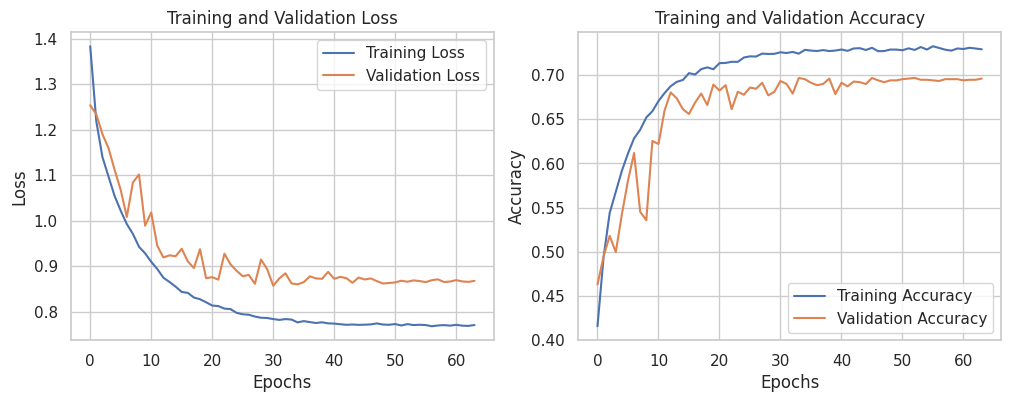

In [440]:
plotter = TrainingPlotter(result5)
plotter.plot_metrics()

138/138 [==============================] - 3s 24ms/step


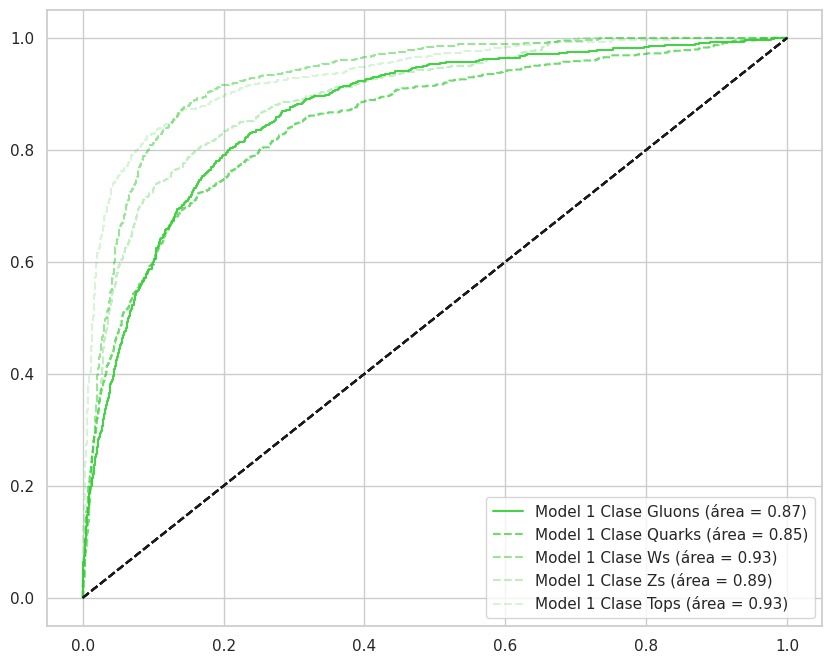

In [536]:
plot_multiclass_roc([model5],
                    class_names=class_names ,
                    data= (X_val_transformed, y_val_transformed),
                    each=False)

##Model 6


In [411]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Add, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization
from tensorflow.keras import regularizers
from typing import Tuple

class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, num_filters, kernel_size=(3, 3), strides=(1, 1), use_conv_shortcut=False):
        super(ResidualBlock, self).__init__()
        self.conv1 = Conv2D(num_filters, kernel_size, strides=strides, padding='same', activation='relu')
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(num_filters, kernel_size, strides=strides, padding='same', activation='relu')
        self.bn2 = BatchNormalization()
        self.add = Add()

        if use_conv_shortcut:
            self.conv_shortcut = Conv2D(num_filters, (1, 1), strides=strides, padding='same')
            self.bn_shortcut = BatchNormalization()

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)

        if hasattr(self, 'conv_shortcut'):
            identity = self.conv_shortcut(inputs)
            identity = self.bn_shortcut(identity)
        else:
            identity = inputs

        return self.add([x, identity])

class Network6(tf.keras.Model):
    def __init__(self, input_shape: Tuple[int, int, int] = (100, 100, 1)):
        super(Network6, self).__init__()
        self.conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')
        self.bn1 = BatchNormalization()
        self.pool1 = MaxPooling2D(2, 2)

        self.res_block1 = ResidualBlock(64, use_conv_shortcut=True)
        self.pool2 = MaxPooling2D(2, 2)

        self.res_block2 = ResidualBlock(128, use_conv_shortcut=True)
        self.pool3 = MaxPooling2D(2, 2)

        self.flatten = Flatten()
        self.dropout = Dropout(0.3)
        self.dense1 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))
        self.dense2 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))
        self.dense3 = Dense(5, activation='softmax')

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.pool1(x)

        x = self.res_block1(x)
        x = self.pool2(x)

        x = self.res_block2(x)
        x = self.pool3(x)

        x = self.flatten(x)
        x = self.dropout(x, training=training)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return x

# Create an instance of the model and build it
model6 = Network6()
model6.build((None, 100, 100, 1))  # This builds the model with the given input shape


In [ ]:
# Callbacks
callbacks6 = [
    tf.keras.callbacks.ModelCheckpoint('/content/MODELS/modelo6_ch1',
                                       save_best_only=True,
                                       monitor='val_accuracy',
                                       mode='max'),

    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                     patience=20,  # Reduced patience
                                     mode='max',
                                     restore_best_weights=True),  # Restore the weights of the best performance model

    tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 0.9 ** epoch)
]

# Compile the model with a slightly lower starting learning rate

#optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

optimizer = tf.keras.optimizers.experimental.SGD(
    learning_rate=1e-4,
    momentum=0.3)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

model6.compile(optimizer=optimizer,
               loss=loss_fn,
               metrics=['accuracy'])

# Train the model with a reduced number of epochs if early stopping is used
result6 = model6.fit(train_loader,
                     validation_data=test_loader,
                     epochs=100,  # Reduced the total epochs since we have early stopping
                     callbacks=callbacks6)


Epoch 1/100
161/161 [==============================] - 15s 80ms/step - loss: 5.4394 - accuracy: 0.2520 - val_loss: 5.0107 - val_accuracy: 0.2026 - lr: 1.0000e-04
Epoch 2/100
161/161 [==============================] - 9s 58ms/step - loss: 5.0811 - accuracy: 0.3048 - val_loss: 5.0018 - val_accuracy: 0.1971 - lr: 9.0000e-05
Epoch 3/100
161/161 [==============================] - 12s 74ms/step - loss: 5.0043 - accuracy: 0.3179 - val_loss: 4.9636 - val_accuracy: 0.2808 - lr: 8.1000e-05
Epoch 4/100
161/161 [==============================] - 9s 58ms/step - loss: 4.9475 - accuracy: 0.3406 - val_loss: 4.9019 - val_accuracy: 0.2801 - lr: 7.2900e-05
Epoch 5/100
161/161 [==============================] - 12s 74ms/step - loss: 4.9137 - accuracy: 0.3501 - val_loss: 4.8339 - val_accuracy: 0.3589 - lr: 6.5610e-05
Epoch 6/100
161/161 [==============================] - 9s 58ms/step - loss: 4.8873 - accuracy: 0.3613 - val_loss: 4.9211 - val_accuracy: 0.2910 - lr: 5.9049e-05
Epoch 7/100
161/161 [==========

In [463]:
model6 =  tf.keras.models.load_model('/content/MODELS/modelo6_ch1')

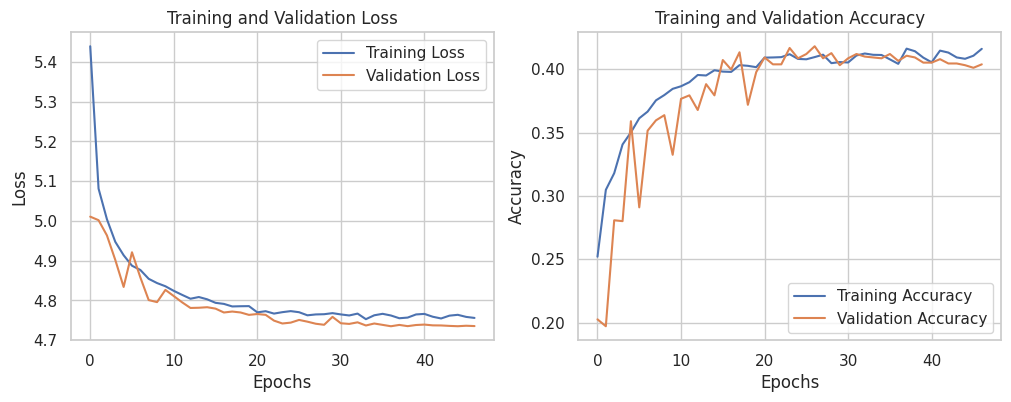

In [445]:
plotter = TrainingPlotter(result6)
plotter.plot_metrics()

138/138 [==============================] - 1s 10ms/step


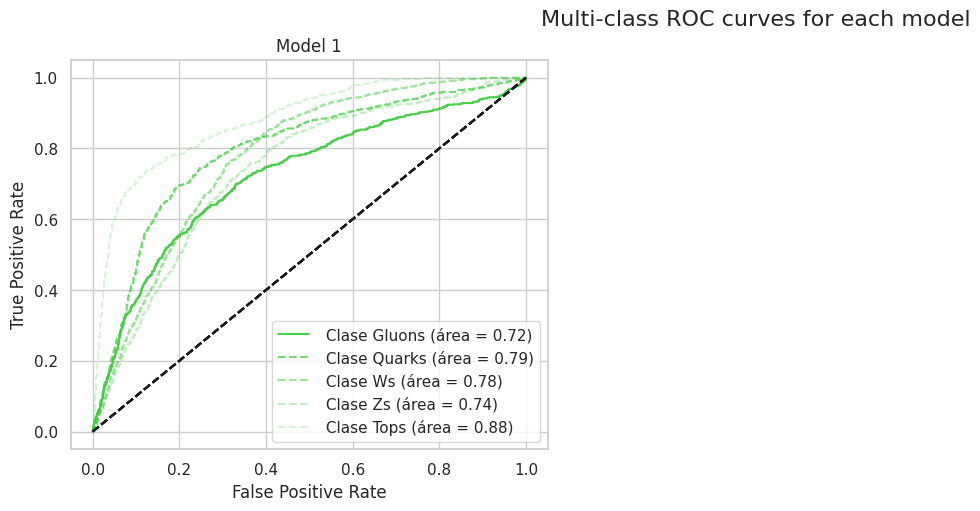

In [464]:
plot_multiclass_roc([model6],
                    class_names=class_names ,
                    data= (X_val_transformed, y_val_transformed),
                    each=True)

##Metrics Functions

### Confusion Matrix Metric Funtion

In [355]:
def plot_confusion_matrices(models: Union[Any, List[Any]], class_names: List[str], val_dataset: Optional[Any] = None, data: Optional[Tuple[np.ndarray, np.ndarray]] = None, each: bool = False) -> None:
    if not isinstance(models, list):
        models = [models]

    n_classes = len(class_names)
    cols = 3

    for model_idx, model in enumerate(models):
        y_true = []
        y_pred = []

        if data is not None:
            if isinstance(data, tuple) and len(data) == 2:
                predictions = model.predict(np.array(data[0]))
                y_pred = np.argmax(predictions, axis=1)
                y_true = np.argmax(np.array(data[1]), axis=1)
            else:
                raise ValueError("The 'data' parameter should be a tuple containing two numpy arrays (X, y).")
        elif val_dataset is not None:
            for x_val, labels in val_dataset:
                predictions = model.predict(x_val)
                y_pred_batch = np.argmax(predictions, axis=1)
                y_true.extend(np.argmax(labels, axis=1))
                y_pred.extend(y_pred_batch)
        else:
            raise ValueError("Either 'val_dataset' or 'data' must be provided.")

        if each:
            rows_per_model = ceil(n_classes / cols)
            fig, axs = plt.subplots(rows_per_model, cols, figsize=(15, 5 * rows_per_model))
            fig.suptitle(f'Binary Confusion Matrices for Model {model_idx+1}', fontsize=16)

            for i, class_name in enumerate(class_names):
                row = i // cols
                col = i % cols
                ax = axs[row, col] if rows_per_model > 1 else axs[col]

                true_binary = np.array(y_true == i, dtype=int)
                pred_binary = np.array(y_pred == i, dtype=int)

                cm = confusion_matrix(true_binary, pred_binary)
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Not {class_name}', class_name], yticklabels=[f'Not {class_name}', class_name], ax=ax)
                ax.set_title(f'Class: {class_name}')
                ax.set_ylabel('True Label')
                ax.set_xlabel('Predicted Label')

            for i in range(n_classes, rows_per_model * cols):
                if rows_per_model > 1:
                    axs.flatten()[i].axis('off')
                else:
                    axs[i].axis('off')

        else:
            cm = confusion_matrix(y_true, y_pred)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
            plt.title(f'Multiclass Confusion Matrix for Model {model_idx+1}')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


138/138 [==============================] - 1s 8ms/step


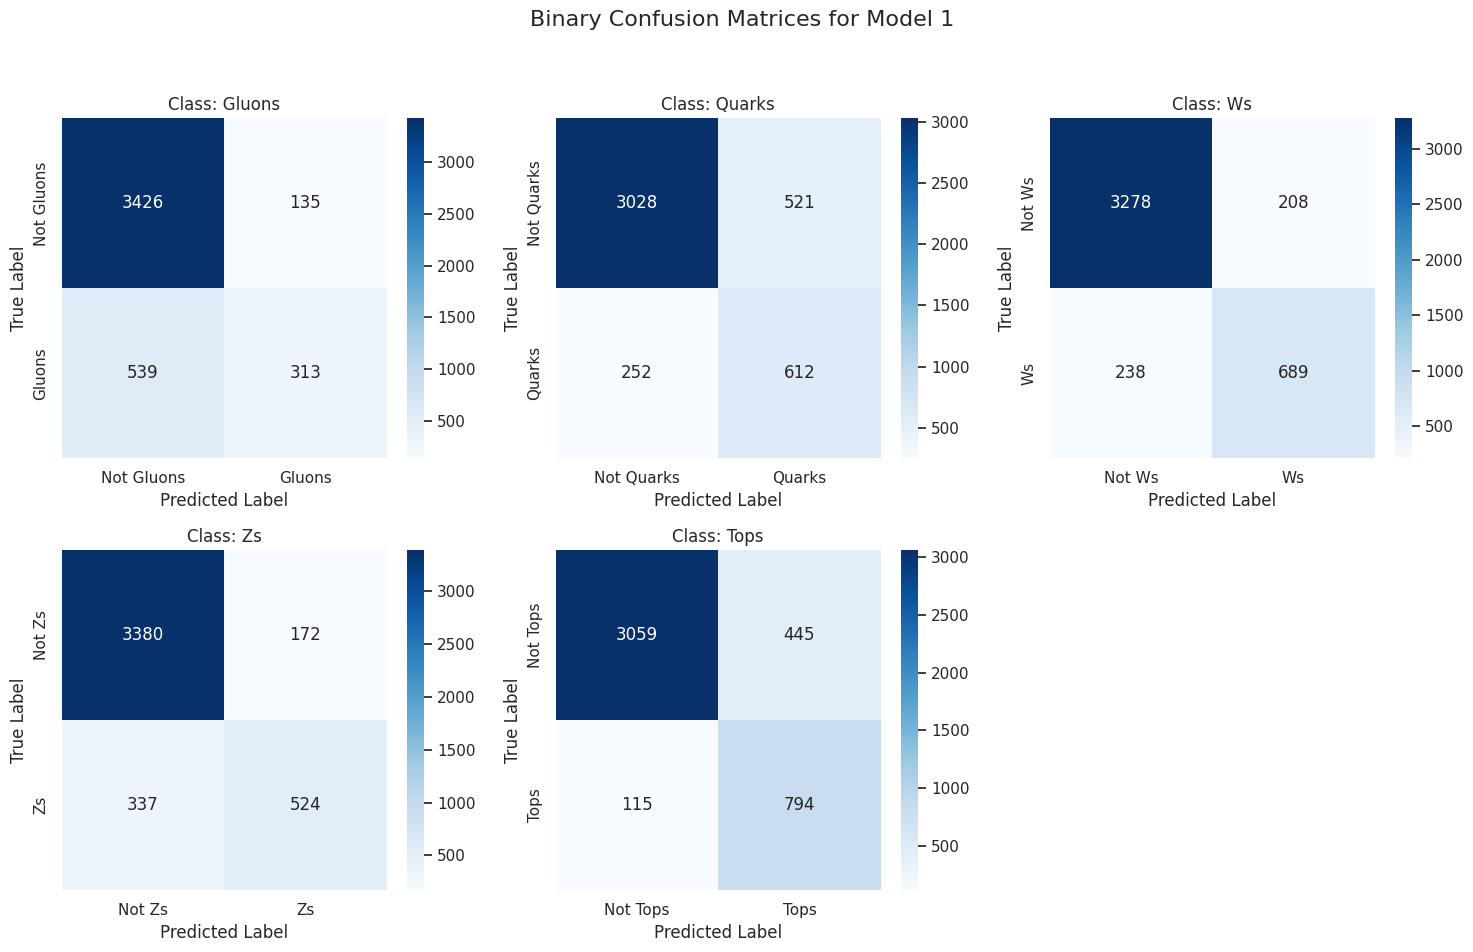

138/138 [==============================] - 1s 5ms/step


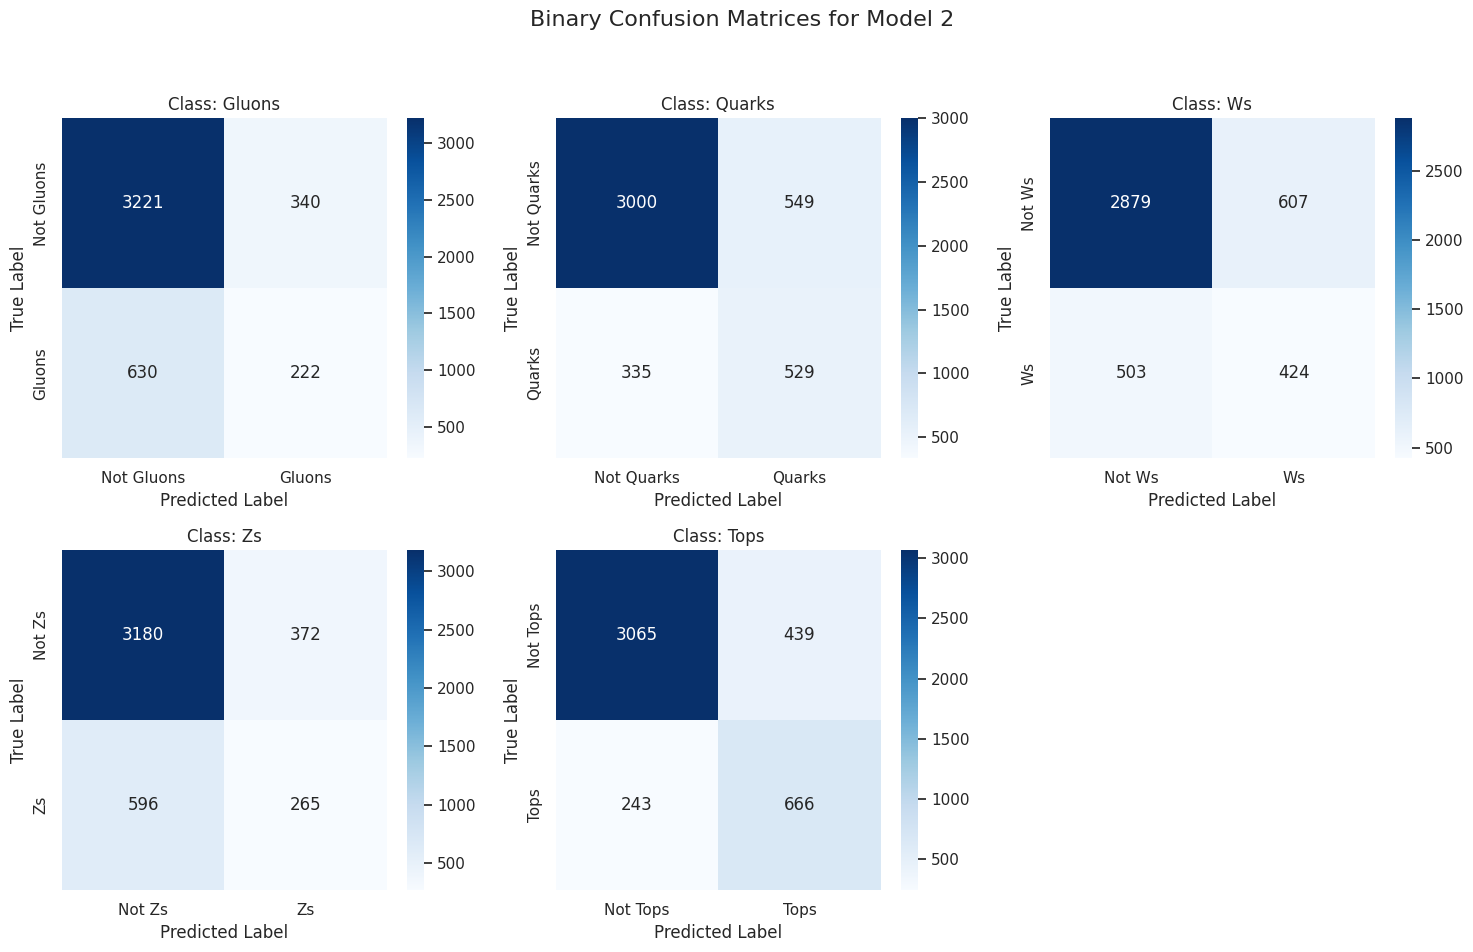

In [384]:
plot_confusion_matrices([model5,model7],
                        class_names=class_names,
                        data= (X_val_transformed, y_val_transformed) ,
                        each = True)

In [194]:
class_names = ["Gluons", "Quarks", "Ws", "Zs", "Tops"]

### ROC Curve Auc Metric Funtion


In [373]:
def plot_multiclass_roc(models: Union[Any, List[Any]], class_names: List[str], val_dataset=None, data=None, each=False):
    if not isinstance(models, list):
        models = [models]  # Asegura que models sea una lista

    n_models = len(models)
    n_classes = len(class_names)
    colors = cycle(['limegreen','royalblue','darkorange','firebrick','darkviolet','darkgoldenrod','darkcyan','darkmagenta','darkolivegreen','darkslategray'])
    n=0
    if each:
        # Calcula el número de filas necesario para acomodar todos los modelos en un mosaico de 3 columnas
        n_rows = ceil(n_models / 3)
        fig, axs = plt.subplots(n_rows, 3, figsize=(15, n_rows * 5), constrained_layout=True)
        fig.suptitle('Multi-class ROC curves for each model', fontsize=16)

        for model_idx, model in enumerate(models):
            row = model_idx // 3
            col = model_idx % 3
            ax = axs[row, col] if n_rows > 1 else axs[col]
            plot_roc_for_model(model, model_idx, class_names, val_dataset, data, ax, next(colors),n='')

            # Configurar títulos y etiquetas para el subplot actual
            ax.set_title(f'Model {model_idx + 1}')
            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')
            ax.legend(loc="lower right")

        # Ocultar subplots vacíos si los hay
        for idx in range(model_idx + 1, n_rows * 3):
            plt.delaxes(axs.flatten()[idx])

        plt.show()

    else:
        plt.figure(figsize=(10, 8))
        for model_idx, model in enumerate(models):
            n+=1
            plot_roc_for_model(model, model_idx, class_names, val_dataset, data, plt.gca(), next(colors),n)
        plt.legend(loc="lower right")
        plt.show()

def plot_roc_for_model(model, model_idx, class_names, val_dataset, data, ax, color,n):
    n_classes = len(class_names)
    line_styles_with_alpha = [
    ('-', 0.9),  # Estilo sólido con alpha 0.1
    ('--', 0.7),  # Estilo de línea discontinua con alpha 0.2
    ('--', 0.5),  # Estilo de línea-punto con alpha 0.3
    ('--', 0.3),  # Estilo punteado con alpha 0.4
    ('--', 0.2)  # Estilo personalizado con alpha 0.5
]
    line_styles = cycle(line_styles_with_alpha)
    if data is not None:
        if isinstance(data, tuple) and len(data) == 2:
            y_score = model.predict(np.array(data[0]))
            y_true = data[1]
        else:
            raise ValueError("The 'data' parameter should be a tuple containing two numpy arrays (X, y).")
    elif val_dataset is not None:
        y_true, y_score = [], []
        for x_val, labels in val_dataset:
            y_score_batch = model.predict(x_val)
            y_true.extend(labels)
            y_score.extend(y_score_batch)
        y_true = np.array(y_true)
        y_score = np.array(y_score)
    else:
        raise ValueError("Either 'val_dataset' or 'data' must be provided.")

    # Binariza las etiquetas en un formato one-vs-all
    y_true = label_binarize(y_true, classes=range(n_classes))

    # Calcular la curva ROC y el área ROC para cada clase
    #for i, line_style in zip(range(n_classes), line_styles):
    for i in range(n_classes):
        line_style, alpha = next(line_styles)

        fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        if isinstance(n, str):
            ti = ''
        else:
            ti = f'Model {n}'

        ax.plot(fpr, tpr, color=color, linestyle=line_style,alpha=alpha,
                 label=f'{ti} Clase {class_names[i]} (área = {roc_auc:.2f})')
        ax.plot([0, 1], [0, 1], 'k--')

138/138 [==============================] - 1s 7ms/step


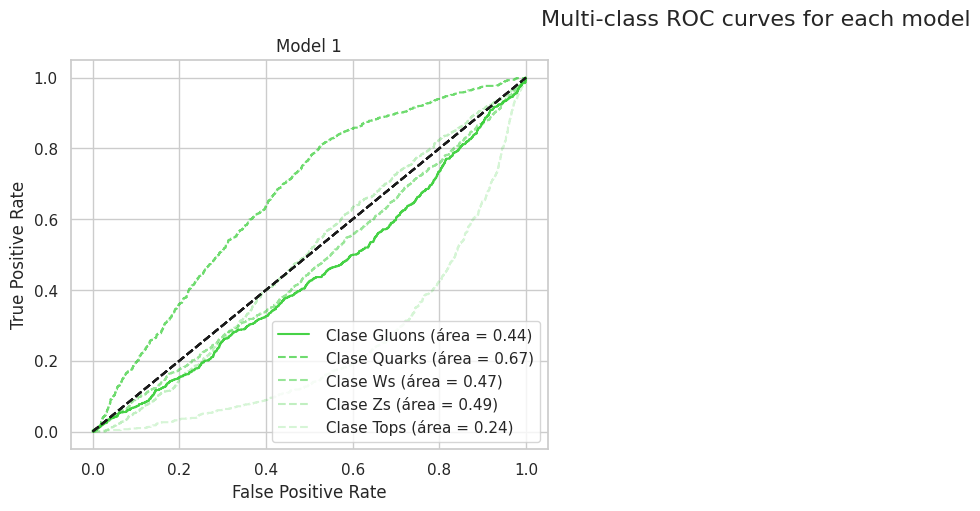

In [398]:
plot_multiclass_roc([model5],
                    class_names=class_names ,
                    data= (X_val_transformed, y_val_transformed),
                    each=True)

### Precision-Recall Metric Function

In [340]:
def plot_multiclass_precision_recall(models: Union[Any, List[Any]], class_names: List[str], val_dataset=None, data=None, each=False):
    if not isinstance(models, list):
        models = [models]  # Asegura que models sea una lista

    n_models = len(models)
    n_classes = len(class_names)
    colors = cycle(['limegreen','royalblue','darkorange','firebrick','darkviolet','darkgoldenrod','darkcyan','darkmagenta','darkolivegreen','darkslategray'])
    n=0
    if each:
        # Calcula el número de filas necesario para acomodar todos los modelos en un mosaico de 3 columnas
        n_rows = ceil(n_models / 3)
        fig, axs = plt.subplots(n_rows, 3, figsize=(15, n_rows * 5), constrained_layout=True)
        fig.suptitle('Multi-class Precision-Recall curves for each model', fontsize=16)

        for model_idx, model in enumerate(models):
            row = model_idx // 3
            col = model_idx % 3
            ax = axs[row, col] if n_rows > 1 else axs[col]
            plot_precision_recall_for_model(model, model_idx, class_names, val_dataset, data, ax, next(colors),n='')

            # Configurar títulos y etiquetas para el subplot actual
            ax.set_title(f'Modelo {model_idx + 1}')
            ax.set_xlabel('Recall')
            ax.set_ylabel('Precision')
            ax.legend(loc="upper right")

        # Ocultar subplots vacíos si los hay
        for idx in range(model_idx + 1, n_rows * 3):
            plt.delaxes(axs.flatten()[idx])

        plt.show()

    else:
        plt.figure(figsize=(10, 8))
        for model_idx, model in enumerate(models):
            n+=0
            plot_precision_recall_for_model(model, model_idx, class_names, val_dataset, data, plt.gca(), next(colors),n)
        plt.legend(loc="upper right")
        plt.title('Multi-class Precision-Recall curves for all models', fontsize=16)
        plt.show()

def plot_precision_recall_for_model(model, model_idx, class_names, val_dataset, data, ax, color,n):
    n_classes = len(class_names)
    line_styles_with_alpha = [
    ('-', 0.9),  # Estilo sólido con alpha 0.1
    ('--', 0.7),  # Estilo de línea discontinua con alpha 0.2
    ('--', 0.5),  # Estilo de línea-punto con alpha 0.3
    ('--', 0.3),  # Estilo punteado con alpha 0.4
    ('--', 0.2)  # Estilo personalizado con alpha 0.5
]


    line_styles = cycle(line_styles_with_alpha)

    if data is not None:
        if isinstance(data, tuple) and len(data) == 2:
            y_score = model.predict(np.array(data[0]))
            y_true = data[1]
        else:
            raise ValueError("The 'data' parameter should be a tuple containing two numpy arrays (X, y).")
    elif val_dataset is not None:
        y_true, y_score = [], []
        for x_val, labels in val_dataset:
            y_score_batch = model.predict(x_val)
            y_true.extend(labels)
            y_score.extend(y_score_batch)
        y_true = np.array(y_true)
        y_score = np.array(y_score)
    else:
        raise ValueError("Either 'val_dataset' or 'data' must be provided.")

    # Binariza las etiquetas en un formato one-vs-all
    y_true = label_binarize(y_true, classes=range(n_classes))

    # Calcular la curva de precisión-recall y el área bajo la curva para cada clase
    #for i, line_style in zip(range(n_classes), line_styles):
    for i in range((n_classes)):
        line_style, alpha = next(line_styles)

        precision, recall, _ = precision_recall_curve(y_true[:, i], y_score[:, i])
        average_precision = average_precision_score(y_true[:, i], y_score[:, i])
        if isinstance(n, str):
            ti = ''
        else:
            ti = f'Model {n}'
        ax.plot(recall, precision, color=color, linestyle=line_style,alpha=alpha,
                 label=f'{ti} Clase {class_names[i]} (AP = {average_precision:.2f})')


46/46 [==============================] - 0s 5ms/step


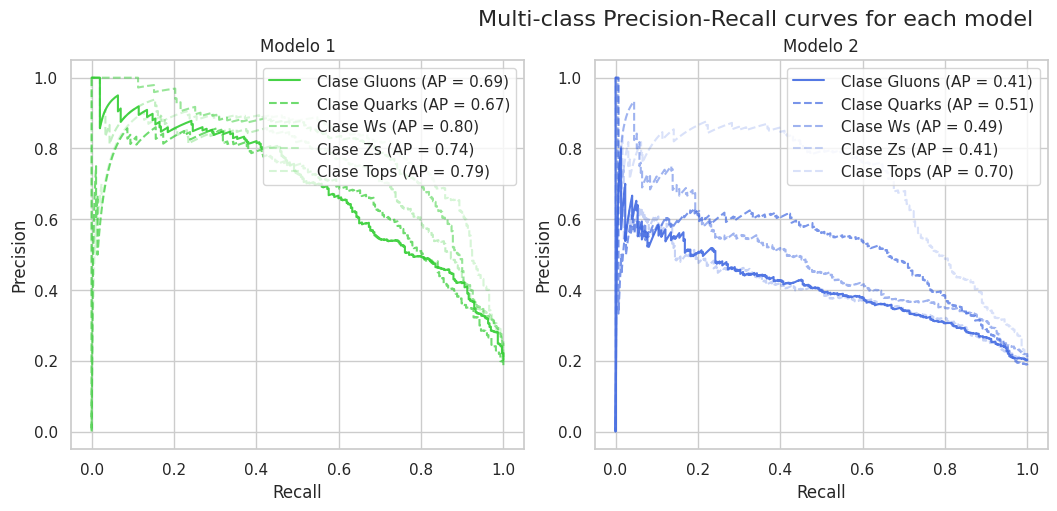

In [383]:

plot_multiclass_precision_recall([model,model7],class_names=class_names ,data= (X_test_transformed, y_test_transformed), each=True)


### Precision Metric Function

In [329]:

def plot_precision_vs_threshold(models: Union[Any, List[Any]], class_names: List[str], val_dataset=None, data=None, each=False):
    if not isinstance(models, list):
        models = [models]  # Asegura que models sea una lista

    n_models = len(models)
    n_classes = len(class_names)
    colors = cycle(['limegreen','royalblue','darkorange','firebrick','darkviolet','darkgoldenrod','darkcyan','darkmagenta','darkolivegreen','darkslategray'])
    n=0
    if each:
        # Calcula el número de filas necesario para acomodar todos los modelos en un mosaico de 3 columnas
        n_rows = ceil(n_models / 3)
        fig, axs = plt.subplots(n_rows, 3, figsize=(15, n_rows * 5), constrained_layout=True)
        fig.suptitle('Precision vs Threshold for each model', fontsize=16)

        for model_idx, model in enumerate(models):
            row = model_idx // 3
            col = model_idx % 3
            ax = axs[row, col] if n_rows > 1 else axs[col]
            plot_precision_threshold_for_model(model, model_idx, class_names, val_dataset, data, ax, next(colors),n='')

            # Configurar títulos y etiquetas para el subplot actual
            ax.set_title(f'Modelo {model_idx + 1}')
            ax.set_xlabel('Threshold')
            ax.set_ylabel('Precision')
            ax.legend(loc="lower left")

        # Ocultar subplots vacíos si los hay
        for idx in range(model_idx + 1, n_rows * 3):
            plt.delaxes(axs.flatten()[idx])

        plt.show()

    else:
        plt.figure(figsize=(10, 8))
        for model_idx, model in enumerate(models):
            n+=1
            plot_precision_threshold_for_model(model, model_idx, class_names, val_dataset, data, plt.gca(), next(colors),n)
        plt.legend(loc="lower left")
        plt.title('Precision vs Threshold for all model', fontsize=16)
        plt.show()

def plot_precision_threshold_for_model(model, model_idx, class_names, val_dataset, data, ax, color,n):
    n_classes = len(class_names)
    line_styles_with_alpha = [
    ('-', 0.9),  # Estilo sólido con alpha 0.1
    ('--', 0.7),  # Estilo de línea discontinua con alpha 0.2
    ('--', 0.5),  # Estilo de línea-punto con alpha 0.3
    ('--', 0.3),  # Estilo punteado con alpha 0.4
    ('--', 0.2)  # Estilo personalizado con alpha 0.5
]


    line_styles = cycle(line_styles_with_alpha)

    if data is not None:
        if isinstance(data, tuple) and len(data) == 2:
            y_score = model.predict(np.array(data[0]))
            y_true = data[1]
        else:
            raise ValueError("The 'data' parameter should be a tuple containing two numpy arrays (X, y).")
    elif val_dataset is not None:
        y_true, y_score = [], []
        for x_val, labels in val_dataset:
            y_score_batch = model.predict(x_val)
            y_true.extend(labels)
            y_score.extend(y_score_batch)
        y_true = np.array(y_true)
        y_score = np.array(y_score)
    else:
        raise ValueError("Either 'val_dataset' or 'data' must be provided.")

    # Binariza las etiquetas en un formato one-vs-all
    y_true = label_binarize(y_true, classes=range(n_classes))

    # Calcular la precisión y los umbrales para cada clase
    #for i, line_style in zip(range(n_classes), line_styles):
    for i in range(n_classes):
        line_style, alpha = next(line_styles)
        precision, _, thresholds = precision_recall_curve(y_true[:, i], y_score[:, i])

        # Elimina el último valor para coincidir con el tamaño de los umbrales
        precision = precision[:-1]
        if isinstance(n, str):
            ti = ''
        else:
            ti = f'Model {n}'
        ax.plot(thresholds, precision,color=color, linestyle=line_style, alpha=alpha,
                label=f'{ti} Clase {class_names[i]}')


46/46 [==============================] - 0s 5ms/step


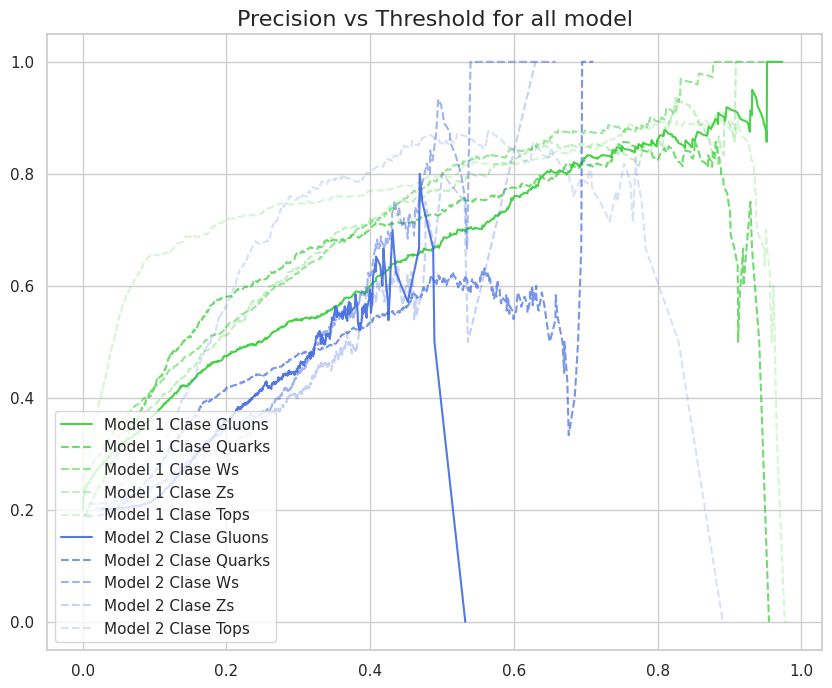

In [343]:

# O para generar un gráfico por modelo
plot_precision_vs_threshold([model,model7],class_names=class_names ,data= (X_test_transformed, y_test_transformed), each=False)


### Recall Metric Function

In [333]:


def plot_recall_vs_threshold(models: Union[Any, List[Any]], class_names: List[str], val_dataset=None, data=None, each=False):
    if not isinstance(models, list):
        models = [models]  # Asegura que models sea una lista

    n_models = len(models)
    n_classes = len(class_names)
    colors = cycle(['limegreen','royalblue','darkorange','firebrick','darkviolet','darkgoldenrod','darkcyan','darkmagenta','darkolivegreen','darkslategray'])
    n=0
    if each:
        # Calcula el número de filas necesario para acomodar todos los modelos en un mosaico de 3 columnas
        n_rows = ceil(n_models / 3)
        fig, axs = plt.subplots(n_rows, 3, figsize=(15, n_rows * 5), constrained_layout=True)
        fig.suptitle('Recall vs Threshold for each model', fontsize=16)

        for model_idx, model in enumerate(models):

            row = model_idx // 3
            col = model_idx % 3
            ax = axs[row, col] if n_rows > 1 else axs[col]
            plot_recall_threshold_for_model(model, model_idx, class_names, val_dataset, data, ax, next(colors),n='')

            # Configurar títulos y etiquetas para el subplot actual
            ax.set_title(f'Modelo {model_idx + 1}')
            ax.set_xlabel('Threshold')
            ax.set_ylabel('Recall')
            ax.legend(loc="upper right")

        # Ocultar subplots vacíos si los hay
        for idx in range(model_idx + 1, n_rows * 3):
            plt.delaxes(axs.flatten()[idx])

        plt.show()

    else:

        plt.figure(figsize=(10, 8))
        for model_idx, model in enumerate(models):
            n+=1
            plot_recall_threshold_for_model(model, model_idx, class_names, val_dataset, data, plt.gca(), next(colors),n)
        plt.legend(loc="upper right")
        plt.title('Recall vs Threshold for all model', fontsize=16)
        plt.show()

def plot_recall_threshold_for_model(model, model_idx, class_names, val_dataset, data, ax, color,n):
    n_classes = len(class_names)
    line_styles_with_alpha = [
    ('--', 0.9),  # Estilo sólido con alpha 0.1
    ('--', 0.7),  # Estilo de línea discontinua con alpha 0.2
    ('--', 0.5),  # Estilo de línea-punto con alpha 0.3
    ('--', 0.3),  # Estilo punteado con alpha 0.4
    ('--', 0.2)  # Estilo personalizado con alpha 0.5
]


    line_styles = cycle(line_styles_with_alpha)

    if data is not None:
        if isinstance(data, tuple) and len(data) == 2:
            y_score = model.predict(np.array(data[0]))
            y_true = data[1]
        else:
            raise ValueError("The 'data' parameter should be a tuple containing two numpy arrays (X, y).")
    elif val_dataset is not None:
        y_true, y_score = [], []
        for x_val, labels in val_dataset:
            y_score_batch = model.predict(x_val)
            y_true.extend(labels)
            y_score.extend(y_score_batch)
        y_true = np.array(y_true)
        y_score = np.array(y_score)
    else:
        raise ValueError("Either 'val_dataset' or 'data' must be provided.")

    # Binariza las etiquetas en un formato one-vs-all
    y_true = label_binarize(y_true, classes=range(n_classes))

    # Calcular el recall y los umbrales para cada clase
    for i in range(n_classes):
        line_style, alpha = next(line_styles)  # Obtiene el estilo de línea y el valor alfa

        _, recall, thresholds = precision_recall_curve(y_true[:, i], y_score[:, i])
        recall = recall[:-1]  # Ajusta el tamaño de recall para que coincida con el de thresholds
        if isinstance(n, str):
            ti = ''
        else:
            ti = f'Model {n}'
        # Usa line_style para el estilo de línea y alpha para la transparencia
        ax.plot(thresholds, recall, color=color, linestyle=line_style, alpha=alpha,
                label=f'{ti} Clase {class_names[i]}')


46/46 [==============================] - 0s 5ms/step


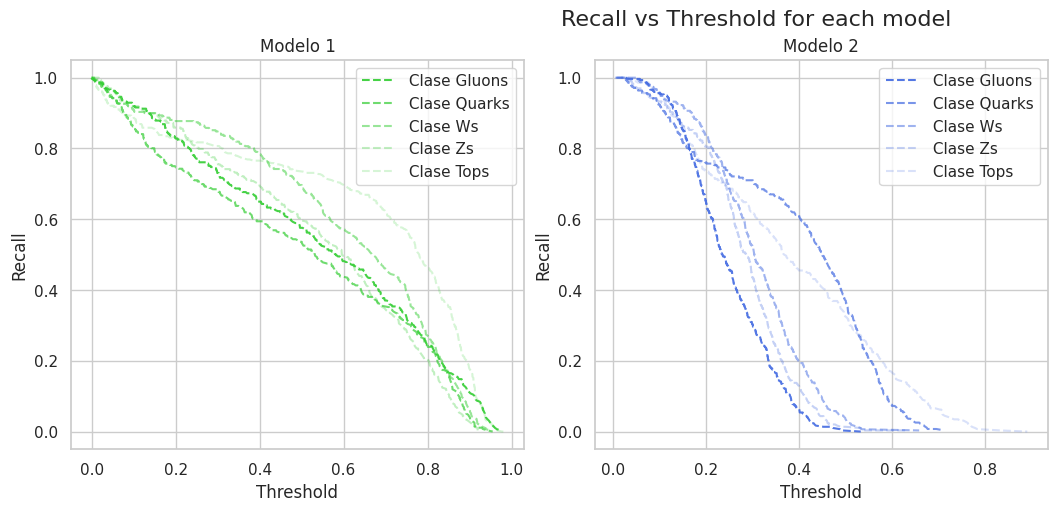

In [334]:
plot_recall_vs_threshold([model,model7],class_names=class_names ,data= (X_test_transformed, y_test_transformed), each=True)


### F1 Score Metric Function

In [331]:
def plot_multiclass_f1_score(models: Union[Any, List[Any]], class_names: List[str], val_dataset=None, data=None, each=False):
    if not isinstance(models, list):
        models = [models]  # Asegura que models sea una lista

    n_models = len(models)
    n_classes = len(class_names)

    colors = cycle(['limegreen','royalblue','darkorange','firebrick','darkviolet','darkgoldenrod','darkcyan','darkmagenta','darkolivegreen','darkslategray'])
    n=0
    if each:
        # Calcula el número de filas necesario para acomodar todos los modelos en un mosaico de 3 columnas
        n_rows = ceil(n_models / 3)
        fig, axs = plt.subplots(n_rows, 3, figsize=(15, n_rows * 5), constrained_layout=True)
        fig.suptitle('F1 Score vs Threshold for each model', fontsize=16)

        for model_idx, model in enumerate(models):
            row = model_idx // 3
            col = model_idx % 3
            ax = axs[row, col] if n_rows > 1 else axs[col]
            plot_f1_for_model(model, model_idx, class_names, val_dataset, data, ax, next(colors),n='')

            # Configurar títulos y etiquetas para el subplot actual
            ax.set_title(f'Modelo {model_idx + 1}')
            ax.set_xlabel('Threshold')
            ax.set_ylabel('F1 Score')
            ax.legend(loc="lower left")

        # Ocultar subplots vacíos si los hay
        for idx in range(model_idx + 1, n_rows * 3):
            plt.delaxes(axs.flatten()[idx])

        plt.show()

    else:
        plt.figure(figsize=(10, 8))
        for model_idx, model in enumerate(models):
            n+=1
            plot_f1_for_model(model, model_idx, class_names, val_dataset, data, plt.gca(), next(colors),n)
        plt.legend(loc="lower left")
        plt.title('F1 Score vs Threshold for all models', fontsize=16)
        plt.show()

def plot_f1_for_model(model, model_idx, class_names, val_dataset, data, ax, color,n):
    n_classes = len(class_names)
    #line_styles = cycle(['-', '--', '-.', ':',(0, (3, 10, 1, 10, 1, 10))])
    line_styles_with_alpha = [
    ('-', 0.9),  # Estilo sólido con alpha 0.1
    ('--', 0.7),  # Estilo de línea discontinua con alpha 0.2
    ('--', 0.5),  # Estilo de línea-punto con alpha 0.3
    ('--', 0.3),  # Estilo punteado con alpha 0.4
    ('--', 0.2)  # Estilo personalizado con alpha 0.5
]


    line_styles = cycle(line_styles_with_alpha)
    if data is not None:
        if isinstance(data, tuple) and len(data) == 2:
            y_score = model.predict(np.array(data[0]))
            y_true = data[1]
        else:
            raise ValueError("The 'data' parameter should be a tuple containing two numpy arrays (X, y).")
    elif val_dataset is not None:
        y_true, y_score = [], []
        for x_val, labels in val_dataset:
            y_score_batch = model.predict(x_val)
            y_true.extend(labels)
            y_score.extend(y_score_batch)
        y_true = np.array(y_true)
        y_score = np.array(y_score)
    else:
        raise ValueError("Either 'val_dataset' or 'data' must be provided.")

    y_true = label_binarize(y_true, classes=range(n_classes))


    #for i, line_style in zip(range(n_classes), line_styles):
    for i in range(n_classes):
        line_style, alpha = next(line_styles)

        precision, recall, thresholds = precision_recall_curve(y_true[:, i], y_score[:, i])

        # Inicializa una lista vacía para almacenar los puntajes F1 calculados
        f1_scores = []

        # Calcula el puntaje F1 para cada par de precisión y recall
        for p, r in zip(precision[:-1], recall[:-1]):  # Excluye el último valor que no tiene umbral asociado
            if p + r > 0:
                f1 = 2 * p * r / (p + r)
            else:
                f1 = 0
            f1_scores.append(f1)

        # Convierte la lista de puntajes F1 en un array de NumPy para el trazado
        f1_scores = np.array(f1_scores)

        ax.plot(thresholds, f1_scores, color=color, linestyle=line_style, alpha=alpha,
                label=f'Model {n} Clase {class_names[i]}')


46/46 [==============================] - 0s 8ms/step


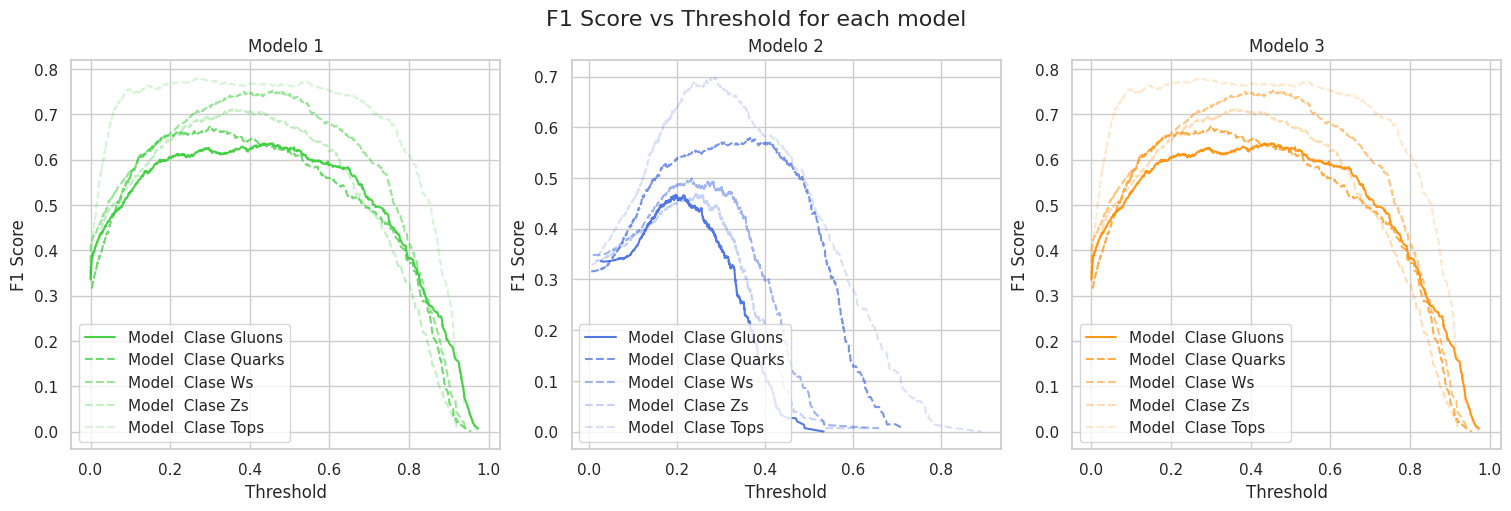

In [332]:

# O para generar un gráfico por modelo
plot_multiclass_f1_score([model,model7,model],class_names=class_names ,data= (X_test_transformed, y_test_transformed), each=True)


#Fine Tuning Class (Model7)

In [523]:
import tensorflow as tf
from typing import Tuple
import keras_tuner as kt

class NeuralNetwork4(tf.keras.Model):
    def __init__(self, num_classes: int = 5, dense1=50, input_shape: Tuple[int, int, int] = (100, 100, 1), **kwargs):
        super(NeuralNetwork4, self).__init__(**kwargs)
        self.conv1 = tf.keras.layers.Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')
        self.pool = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)
        self.conv2 = tf.keras.layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')
        self.drop1 = tf.keras.layers.Dropout(0.8)  # First Dropout layer
        self.drop2 = tf.keras.layers.Dropout(0.7)  # Second Dropout layer
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(100, activation='relu')
        self.fc2 = tf.keras.layers.Dense(170, activation='relu')
        self.fc3 = tf.keras.layers.Dense(dense1, activation='relu')
        self.fc4 = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs: tf.Tensor, training: bool = False) -> tf.Tensor:
        x = self.conv1(inputs)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.drop1(x, training=training)
        x = self.fc2(x)
        x = self.drop2(x, training=training)
        x = self.fc3(x)
        return self.fc4(x)

class MyHyperModel(kt.HyperModel):
    def __init__(self, net, input_shape=(100, 100, 1), num_classes=5):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.net = net

    def build(self, hp):
        ndense1 = hp.Int('dense_1_num_neurons', min_value=40, max_value=60, step=1)
        learning_rate = hp.Float('learning_rate', min_value=1e-6, max_value=1e-3, sampling='log')
        optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop'])

        model = self.net(num_classes=self.num_classes, dense1=ndense1, input_shape=self.input_shape)
        optimizer = {
            'adam': tf.keras.optimizers.Adam(learning_rate=learning_rate),
            'sgd': tf.keras.optimizers.SGD(learning_rate=learning_rate),
            'rmsprop': tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
        }[optimizer_choice]

        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        return model

class HyperparameterTuner:
    def __init__(self, net, input_shape, num_classes):
        self.hypermodel = MyHyperModel(net, input_shape=input_shape, num_classes=num_classes)

    def search(self, train_loader, val_loader, max_trials=10, executions_per_trial=2, epochs=10, name=None, directory='/'):
        project_name = 'model' if name is None else name

        self.tuner = kt.RandomSearch(
            self.hypermodel,
            objective='val_accuracy',
            max_trials=max_trials,
            executions_per_trial=executions_per_trial,
            directory=directory,
            project_name=project_name
        )

        self.tuner.search(train_loader, epochs=epochs, validation_data=val_loader)

    def get_best_model(self) -> tf.keras.Model:
        if not self.tuner:
            raise Exception("Please run the search method before getting the best model.")
        best_hp = self.tuner.get_best_hyperparameters()[0]
        return self.tuner.hypermodel.build(best_hp)

    def get_best_hyperparameters(self) -> kt.HyperParameters:
        if not self.tuner:
            raise Exception("Please run the search method before getting the best hyperparameters.")
        return self.tuner.get_best_hyperparameters()[0]

# Usage example
input_shape = (100, 100, 1)
num_classes = 5
neural_network = NeuralNetwork4  # Passing the class reference
tuner = HyperparameterTuner(neural_network, input_shape, num_classes)

# Ensure the order of train_loader and val_loader matches their definition in the search method
tuner.search(
    train_loader=train_loader,
    val_loader=val_loader,
    max_trials=4,
    executions_per_trial=2,
    epochs=100,
    name='Hpmodelbest',
    directory='/content/HP'
)


Trial 4 Complete [00h 13m 02s]
val_accuracy: 0.2144799456000328

Best val_accuracy So Far: 0.6289372146129608
Total elapsed time: 00h 53m 24s


In [549]:
# Get the best model
best_model = tuner.get_best_model()

# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters()

# Print the best hyperparameters
for hparam, value in best_hyperparameters.values.items():
    print(f"{hparam}: {value}")


dense_1_num_neurons: 44
learning_rate: 0.0003332283580166981
optimizer: rmsprop


In [ ]:

best_hyperparameters = tuner.get_best_hyperparameters()
modelbest = tuner.hypermodel.build(best_hyperparameters)


In [ ]:
callbackshp = [
    tf.keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/Models/modelobestHP_1Ch',
                                                save_best_only=True,
                                                monitor='val_accuracy',
                                                mode='max'),

    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                     patience=50,
                                     mode='max'),
    # Learning Rate Scheduler
     lr_scheduleRO
    #tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 0.5 ** epoch)
]

In [ ]:
# Train the model2
resultbest=modelbest.fit(train_loader,
                    validation_data=val_loader,
                    epochs=250,
                    callbacks=callbackshp)

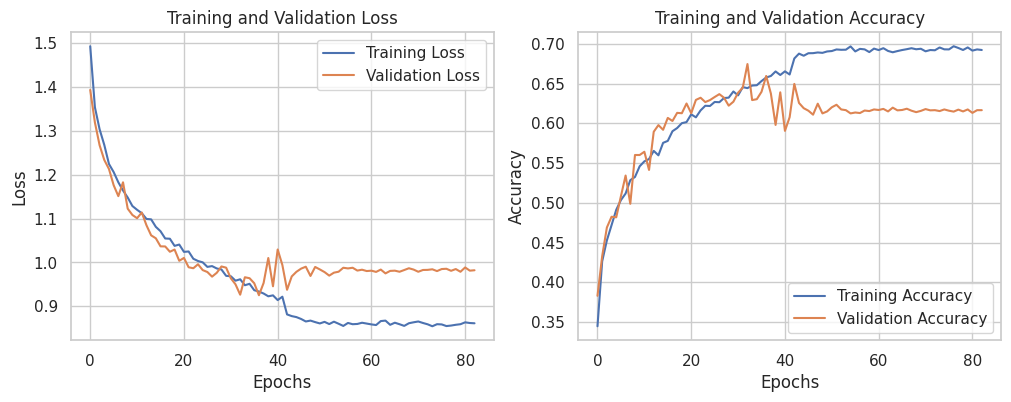

In [521]:
plotter = TrainingPlotter(resultbest)
plotter.plot_metrics()

138/138 [==============================] - 3s 19ms/step


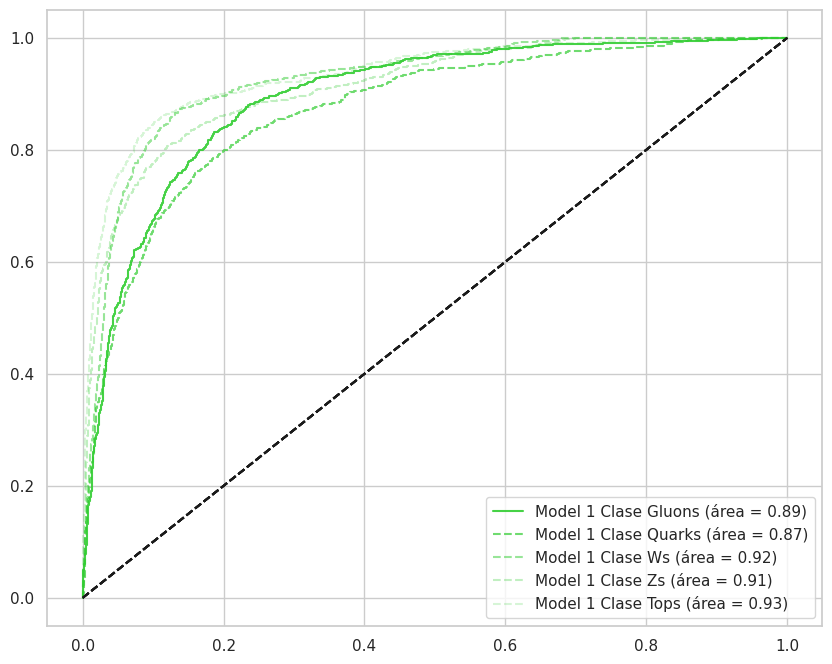

In [531]:
plot_multiclass_roc([modelbest],
                    class_names=class_names ,
                    data= (X_val_transformed, y_val_transformed),
                    each=False)

#Final Results

138/138 [==============================] - 3s 23ms/step


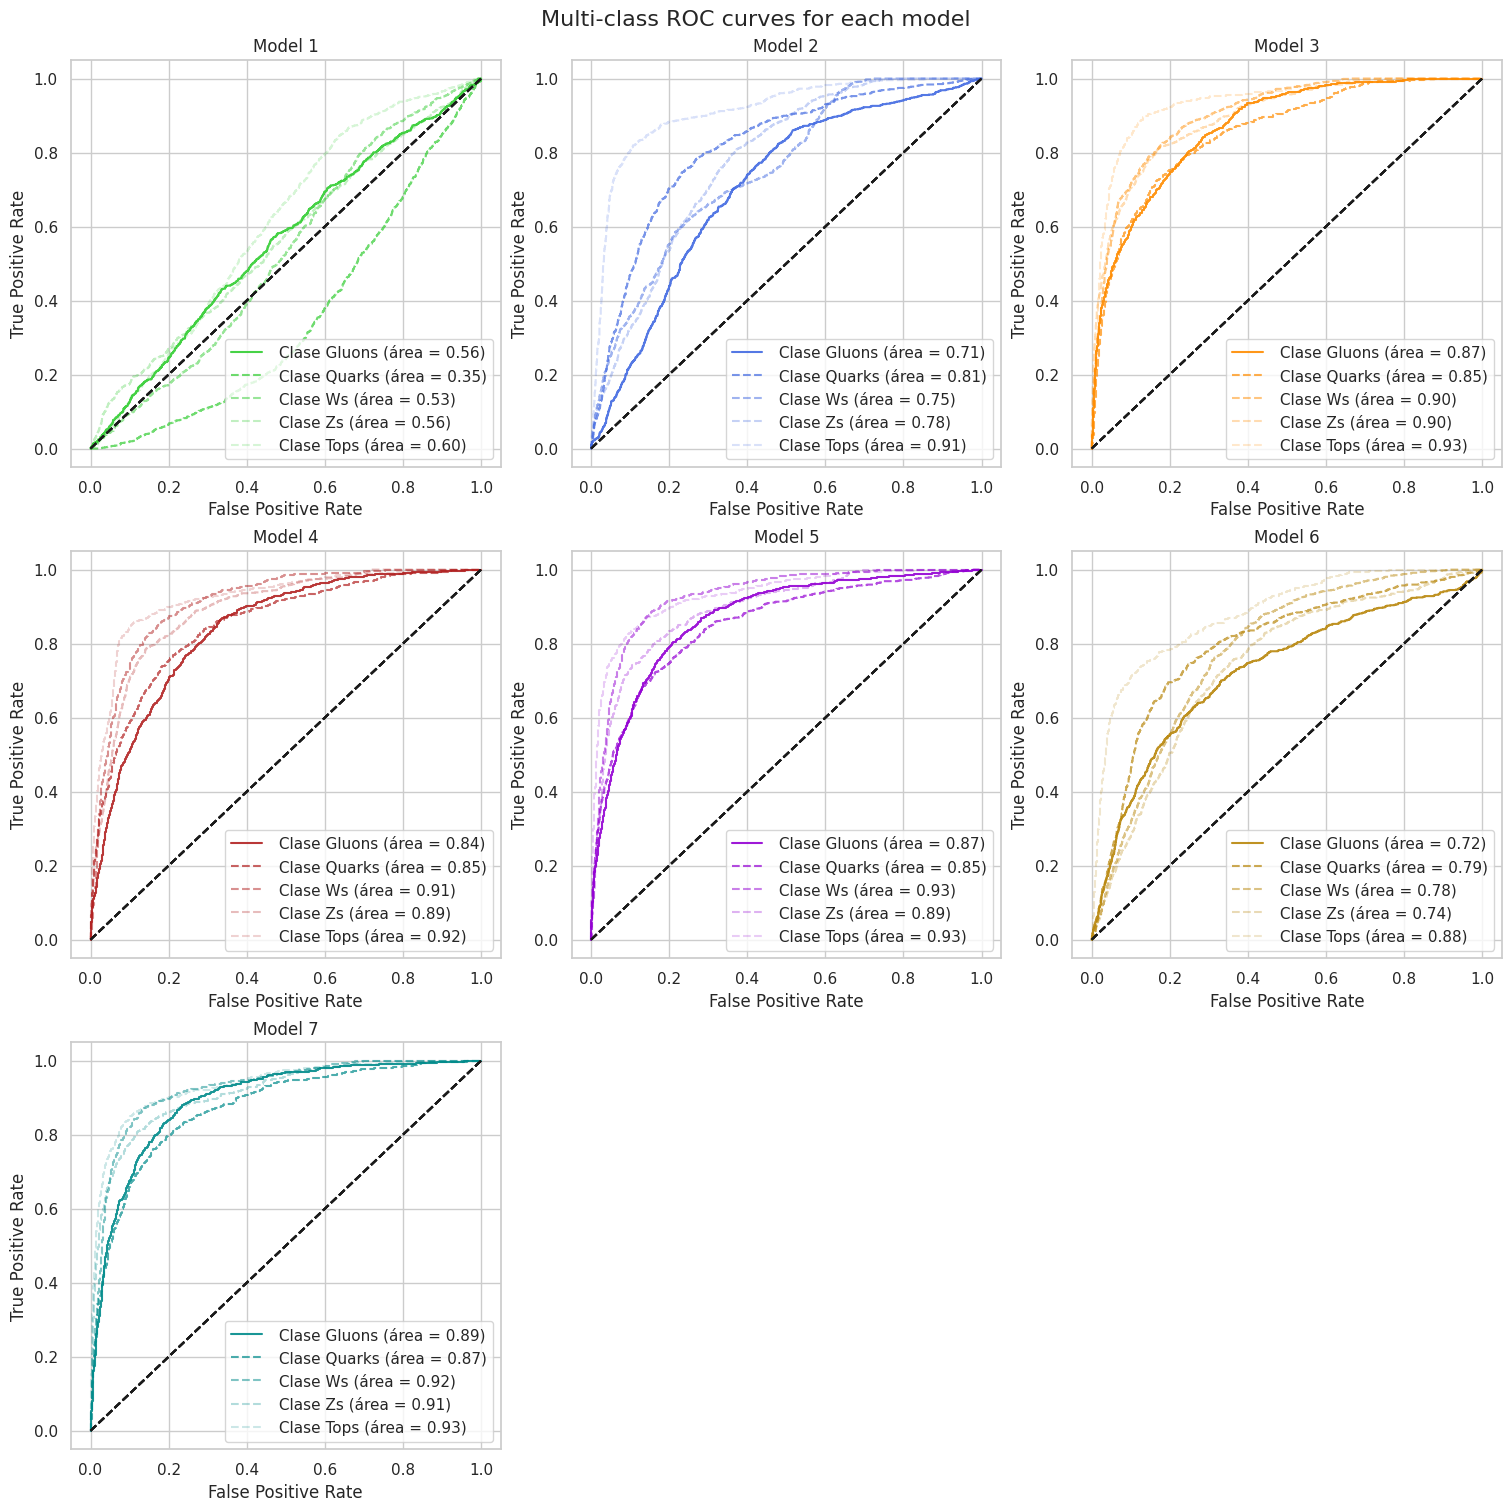

In [539]:
plot_multiclass_roc([model,model2,model3,model4,model5,model6,modelbest],
                    class_names=class_names ,
                    data= (X_val_transformed, y_val_transformed),
                    each=True)

138/138 [==============================] - 2s 15ms/step


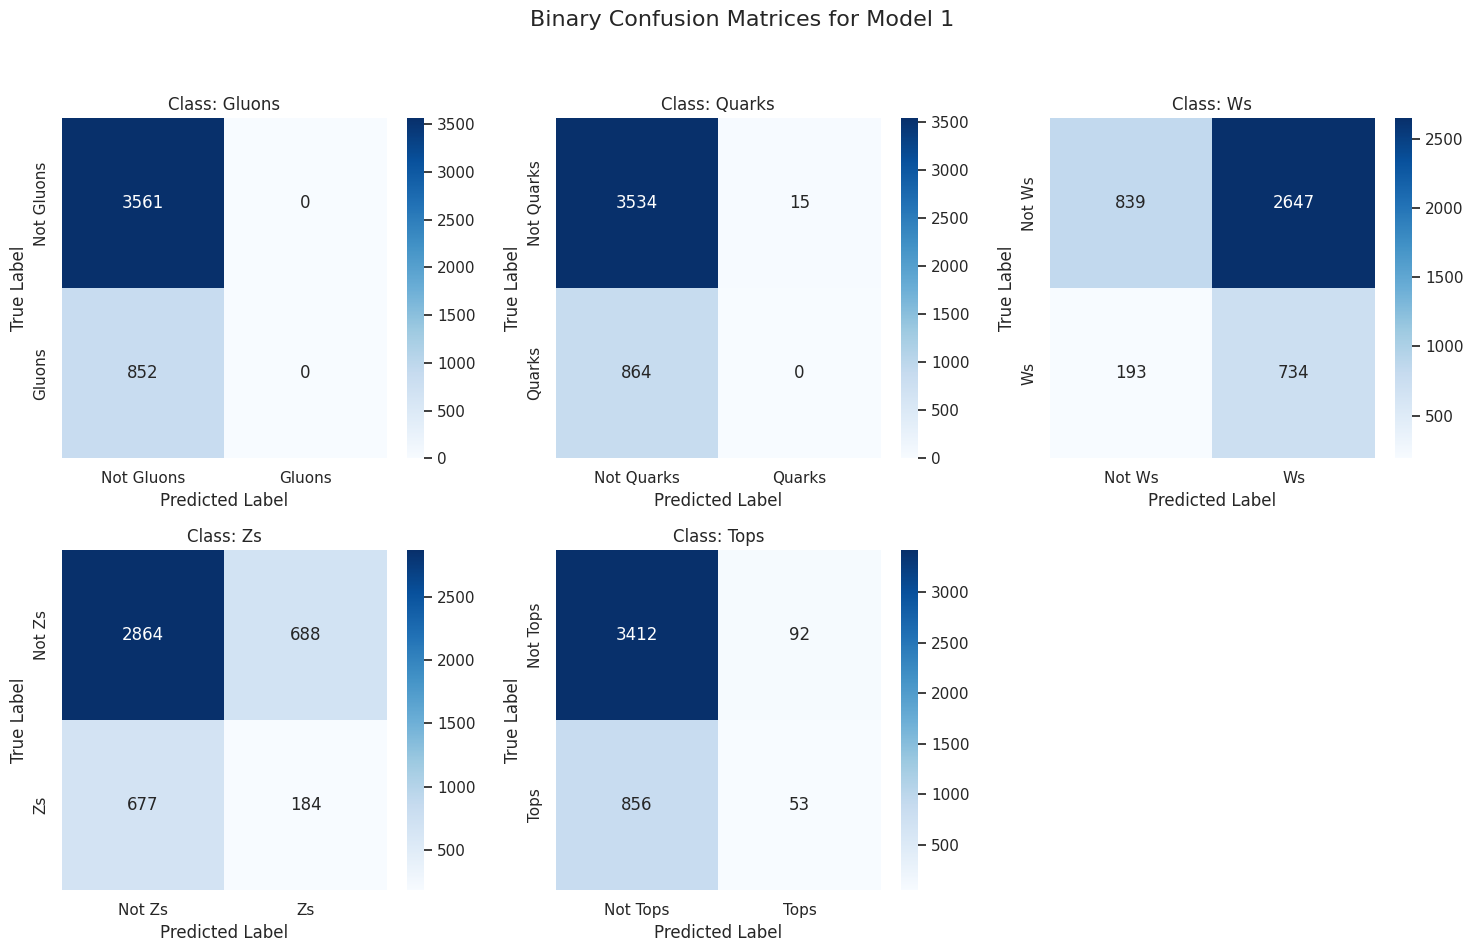

138/138 [==============================] - 2s 14ms/step


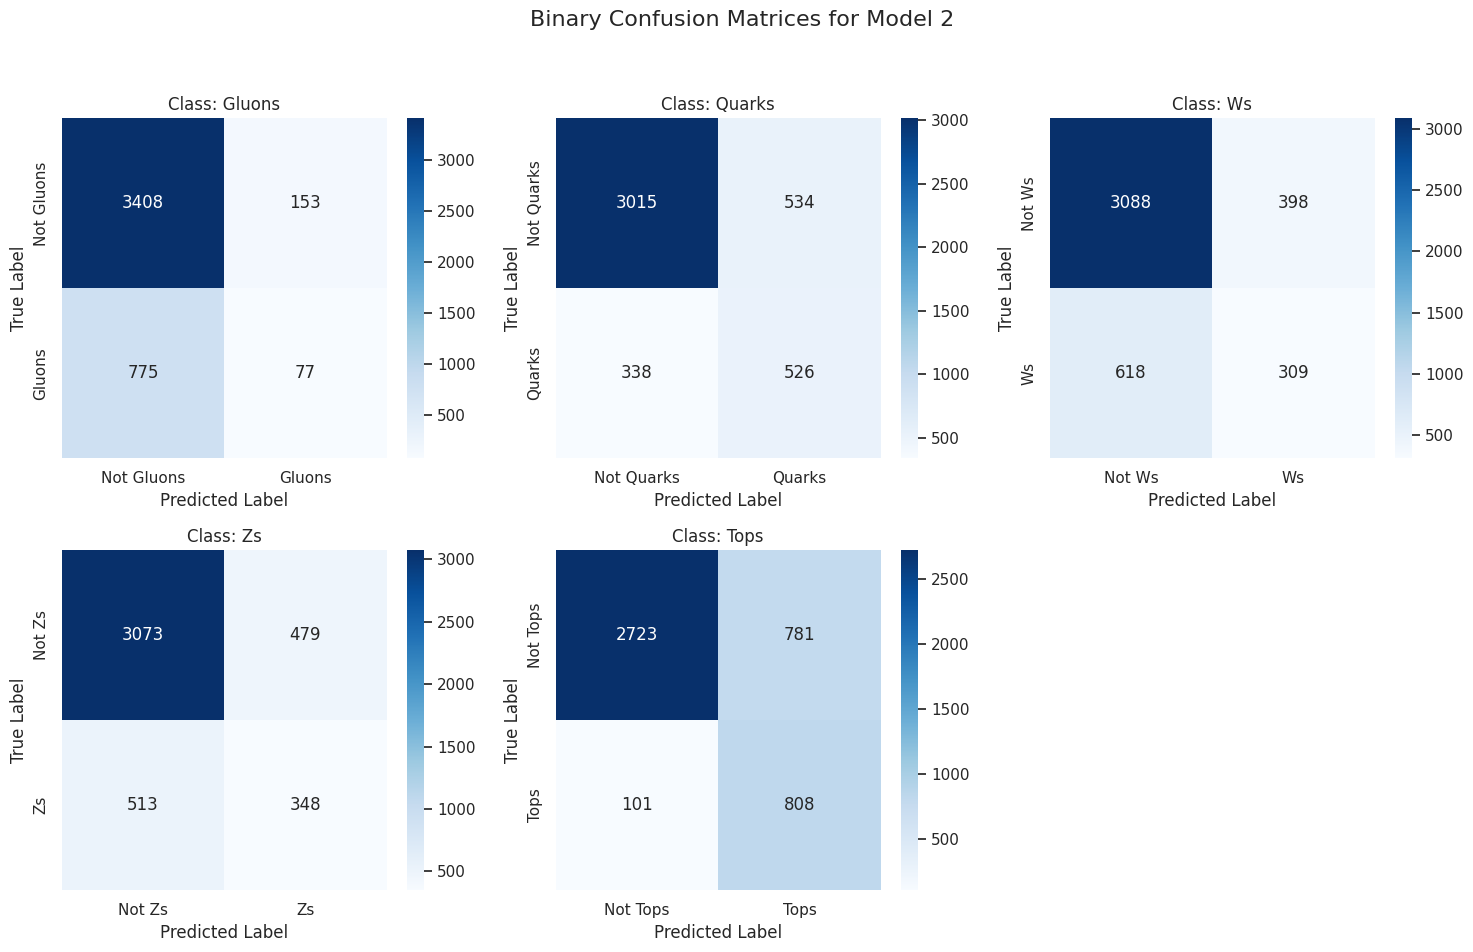

138/138 [==============================] - 2s 15ms/step


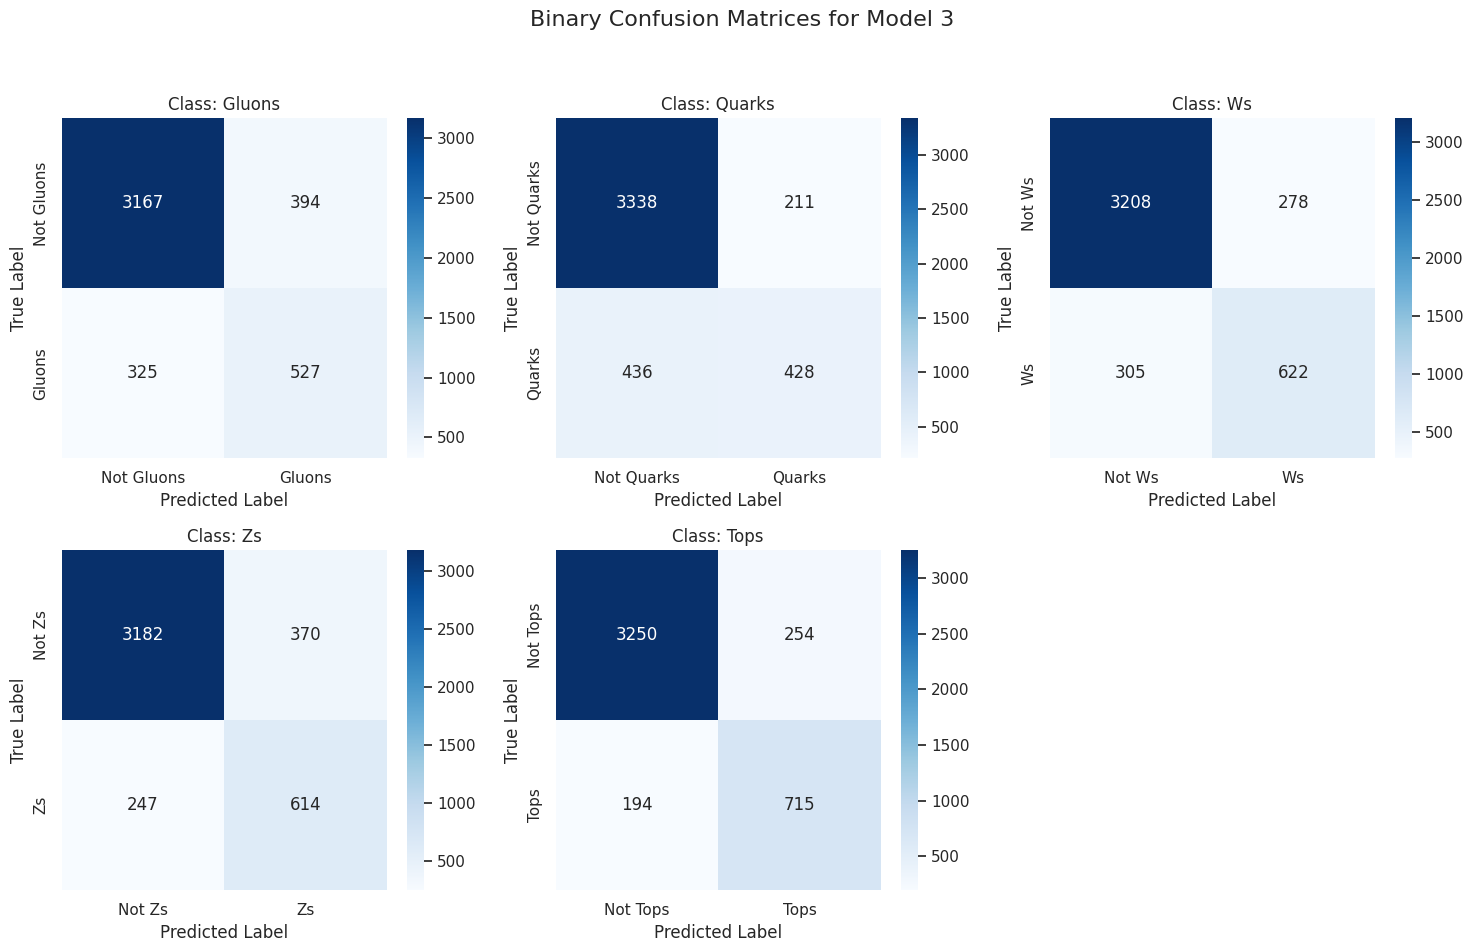

138/138 [==============================] - 2s 15ms/step


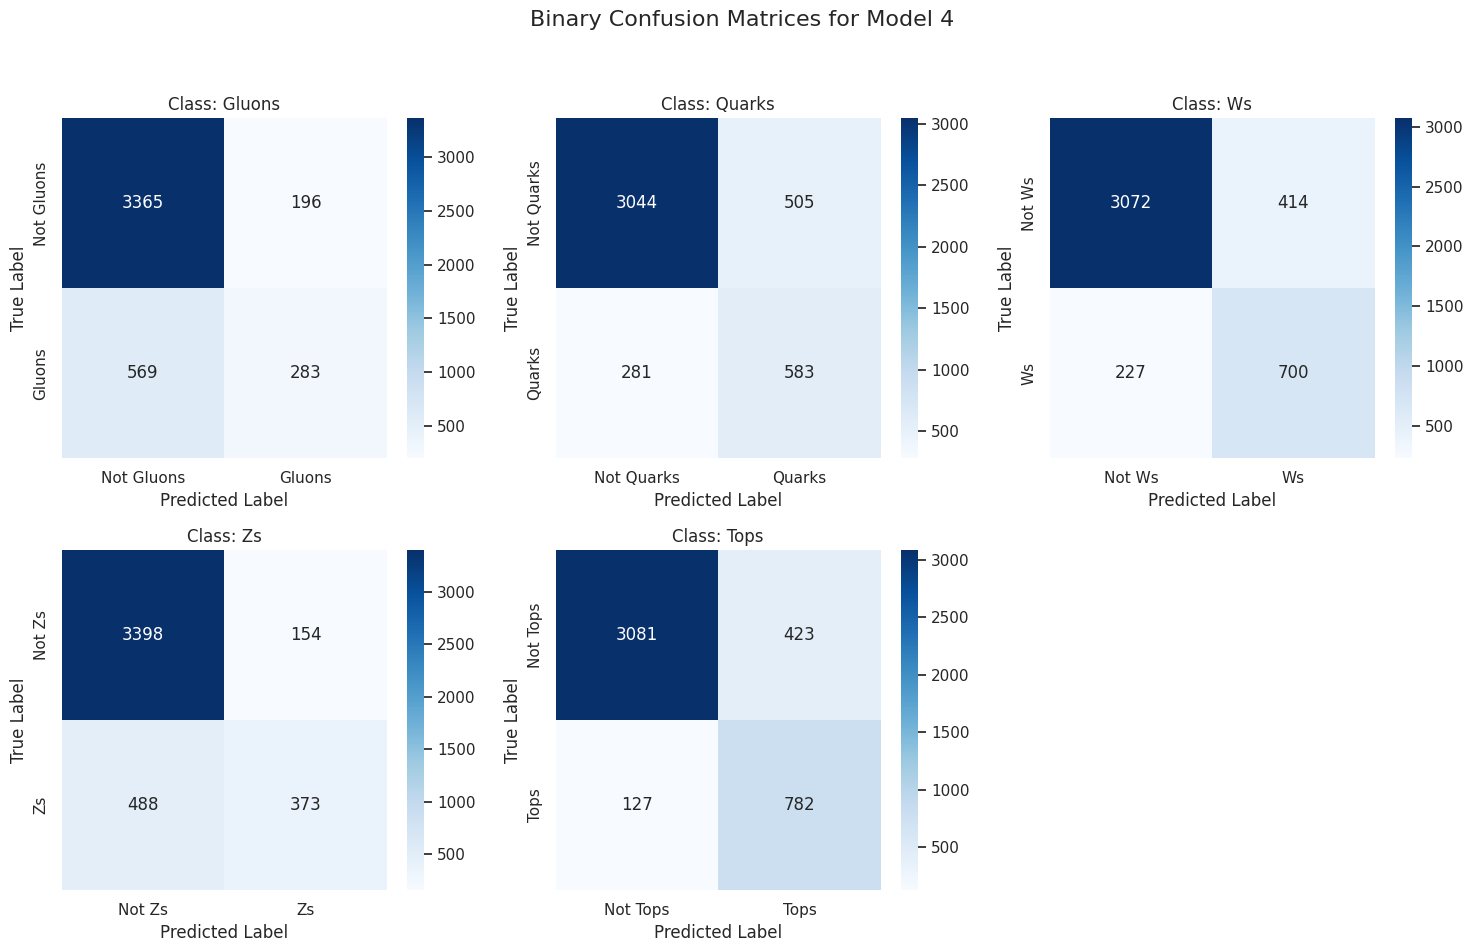

138/138 [==============================] - 3s 19ms/step


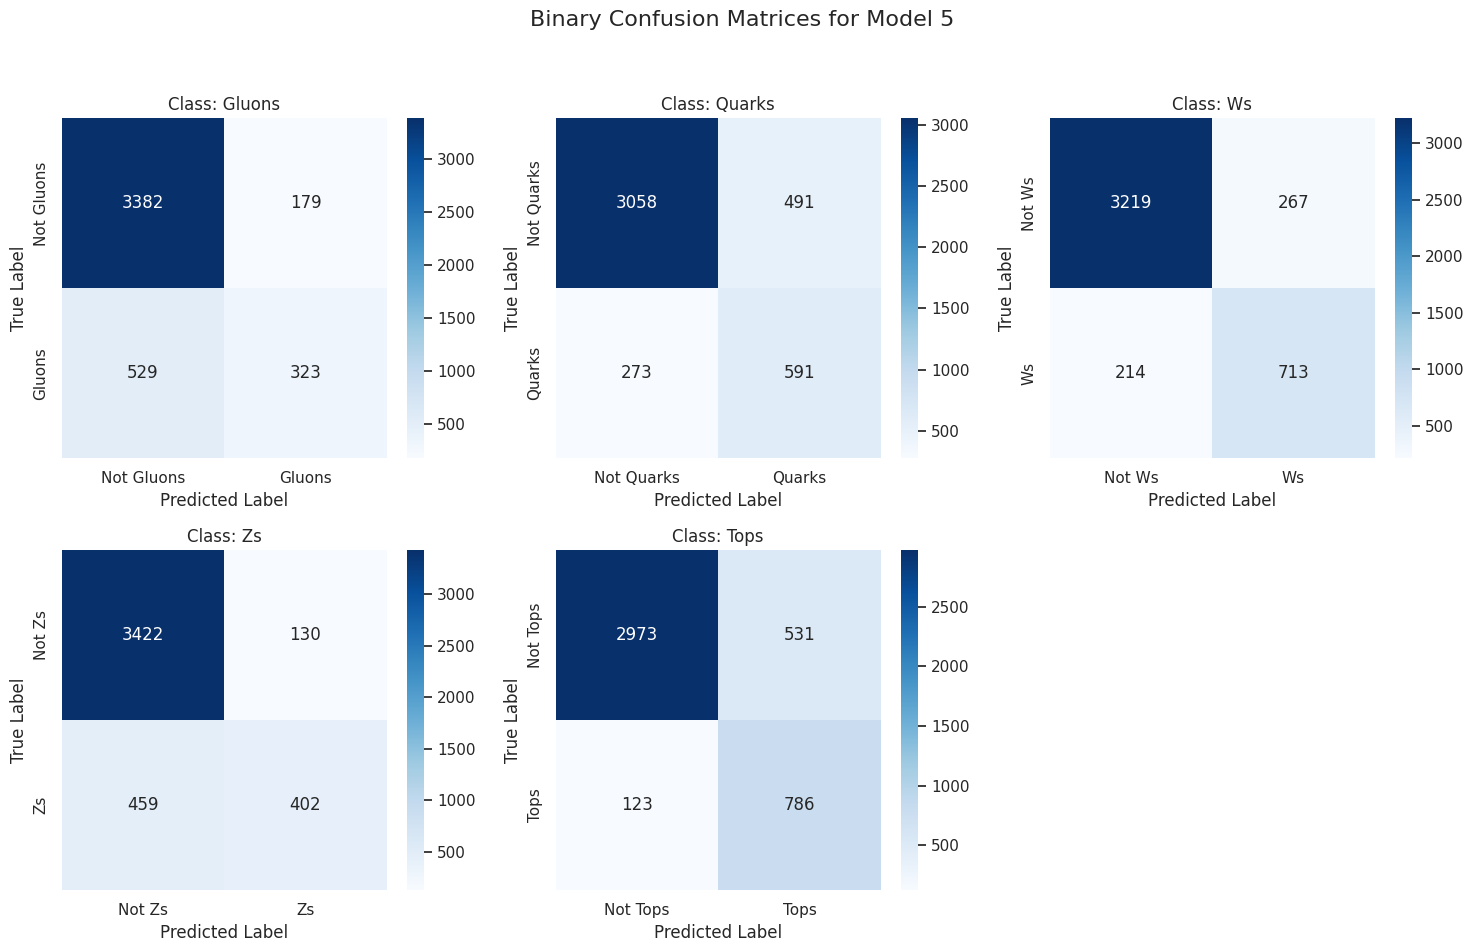

138/138 [==============================] - 2s 16ms/step


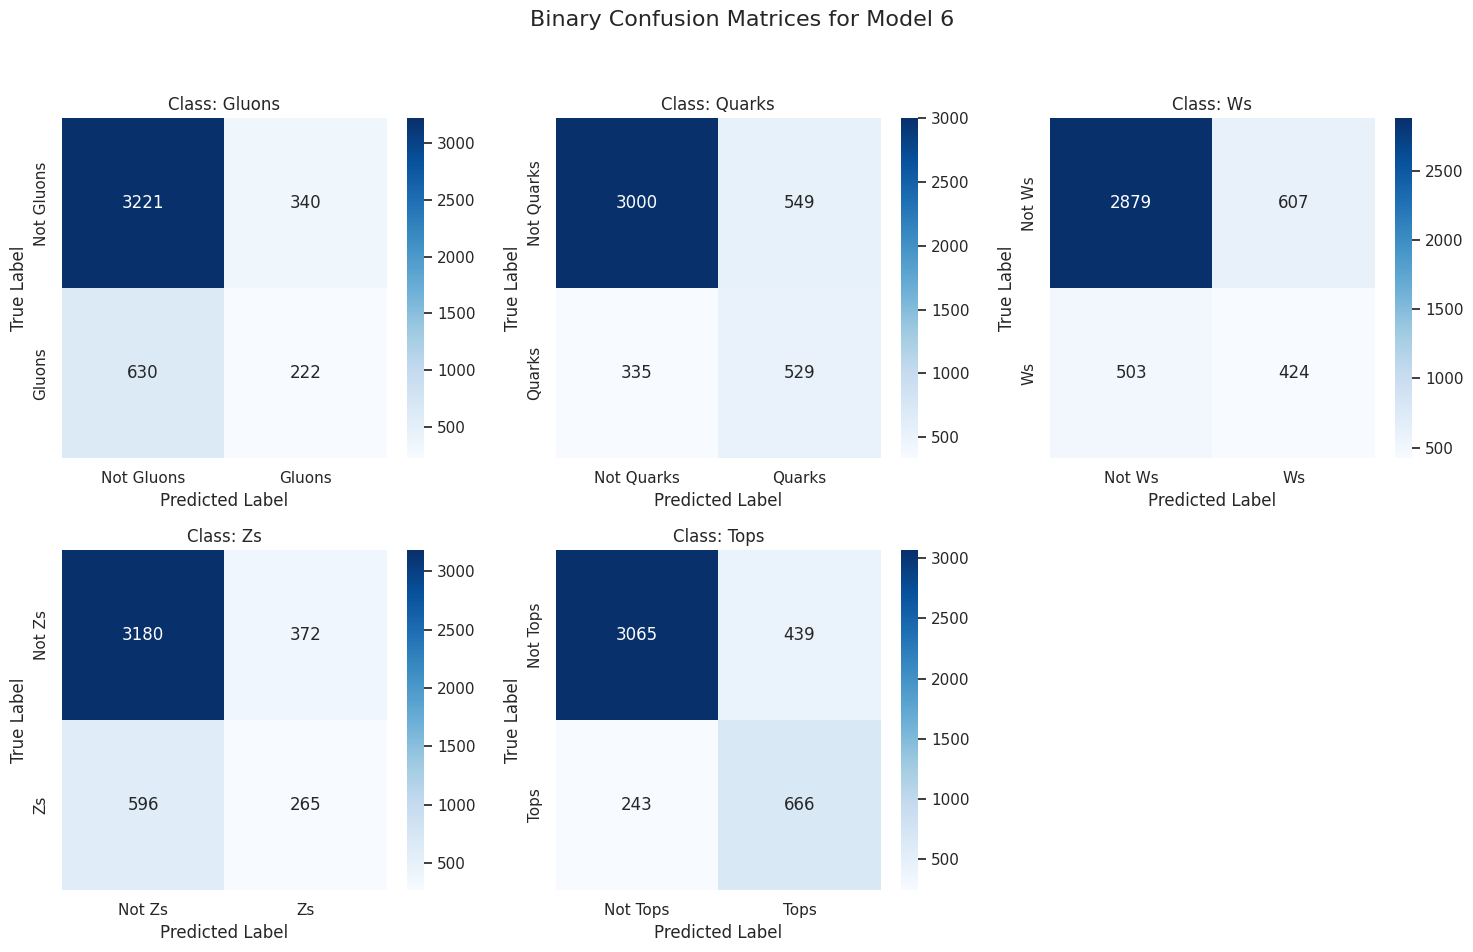

138/138 [==============================] - 1s 11ms/step


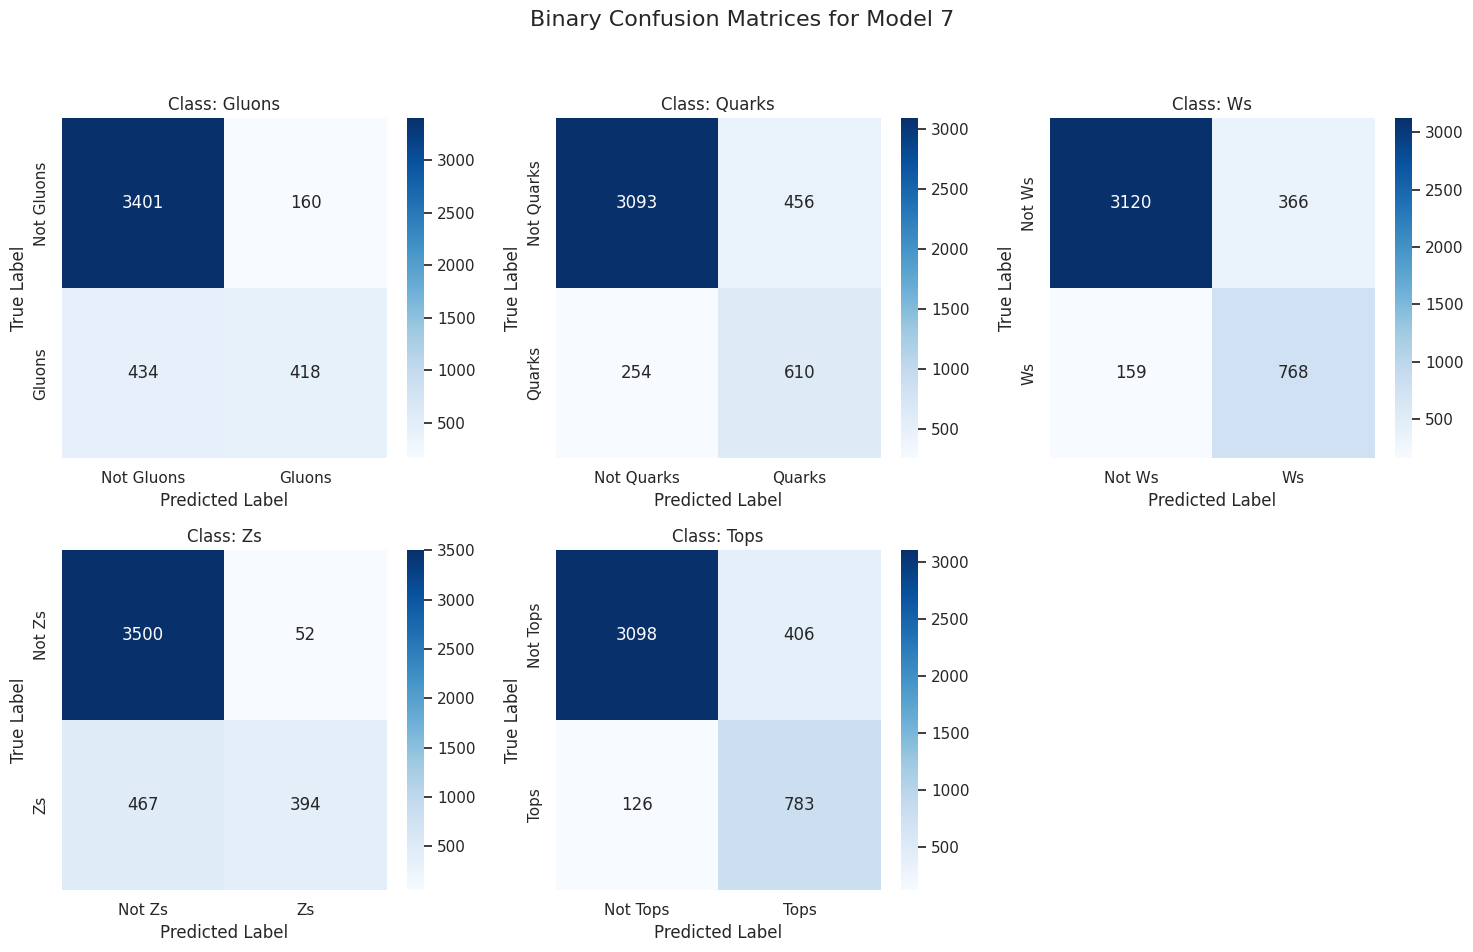

In [540]:
plot_confusion_matrices([model,model2,model3,model4,model5,model6,modelbest],
                    class_names=class_names ,
                    data= (X_val_transformed, y_val_transformed),
                    each=True)

138/138 [==============================] - 1s 6ms/step


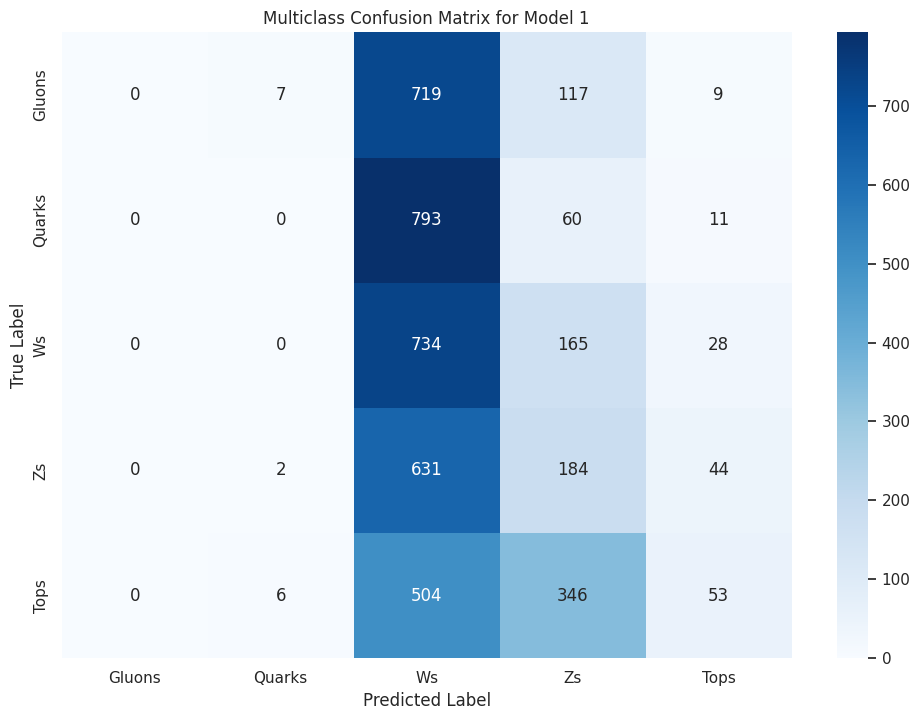

138/138 [==============================] - 3s 20ms/step


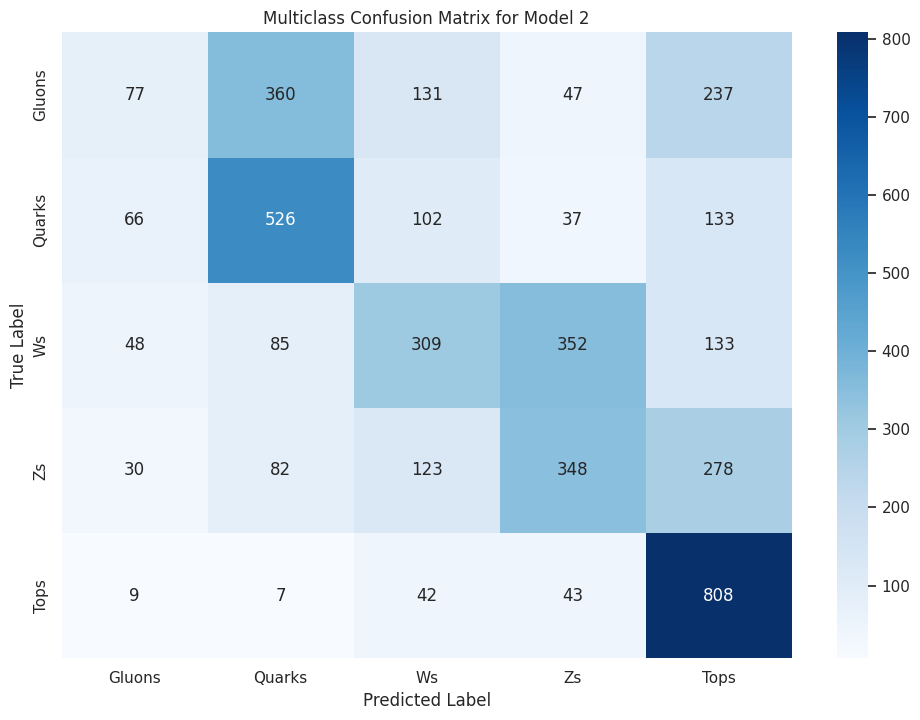

138/138 [==============================] - 2s 14ms/step


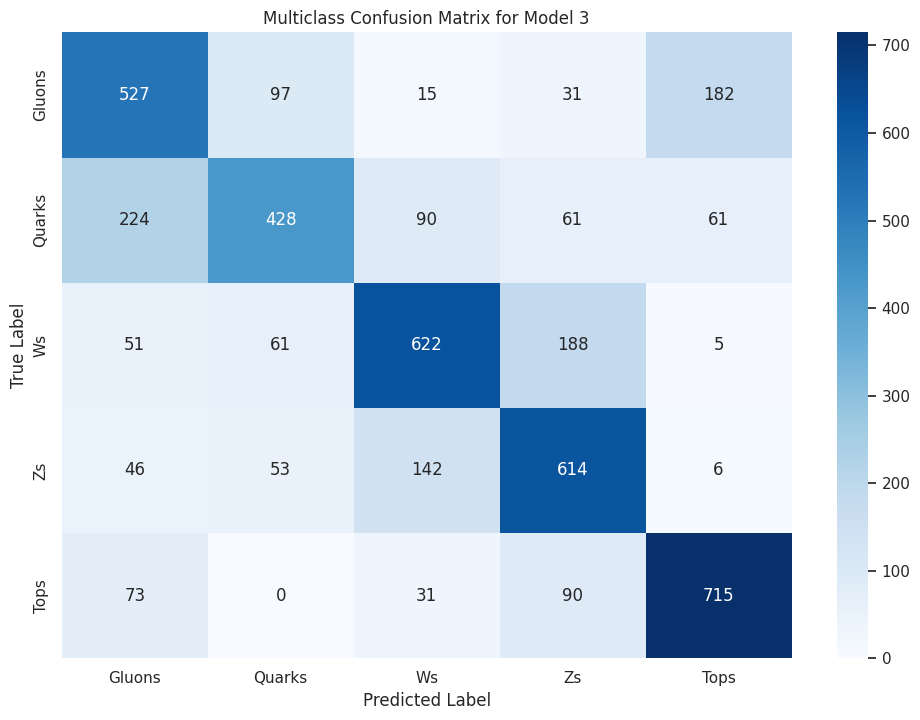

138/138 [==============================] - 1s 9ms/step


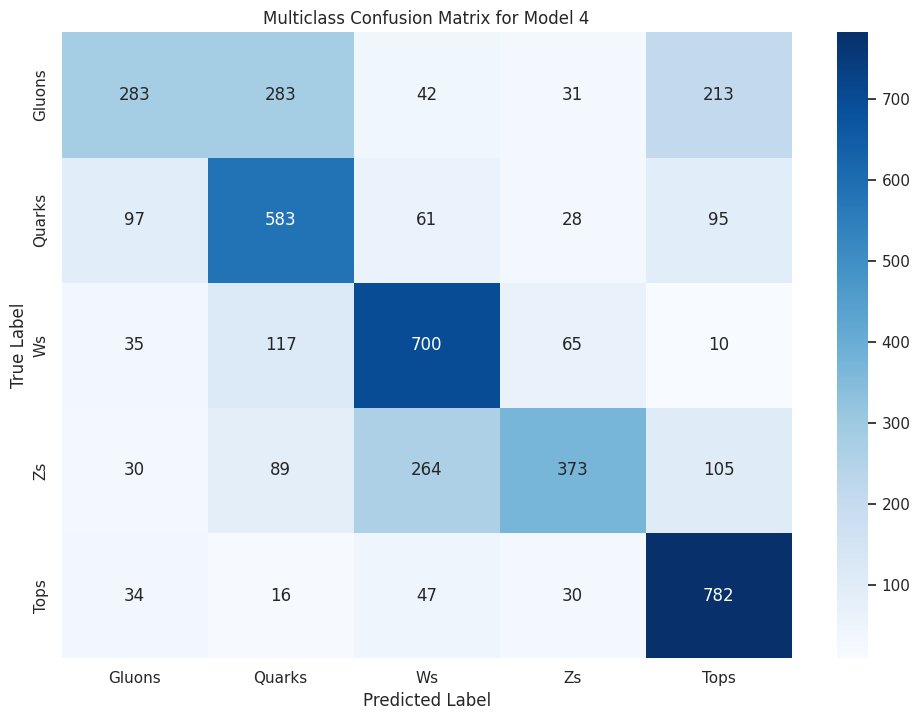

138/138 [==============================] - 3s 25ms/step


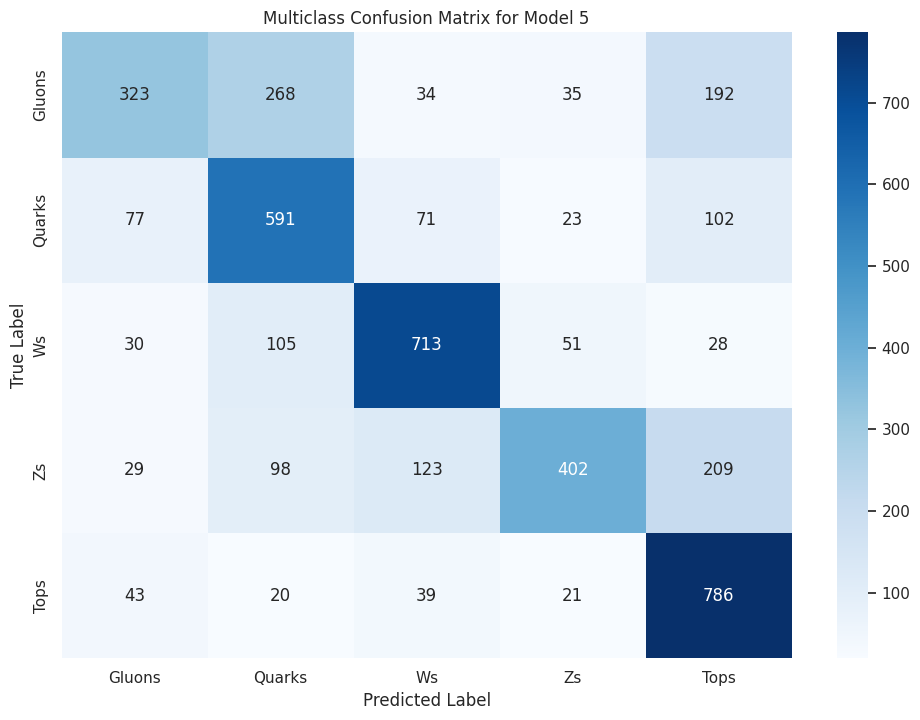

138/138 [==============================] - 3s 18ms/step


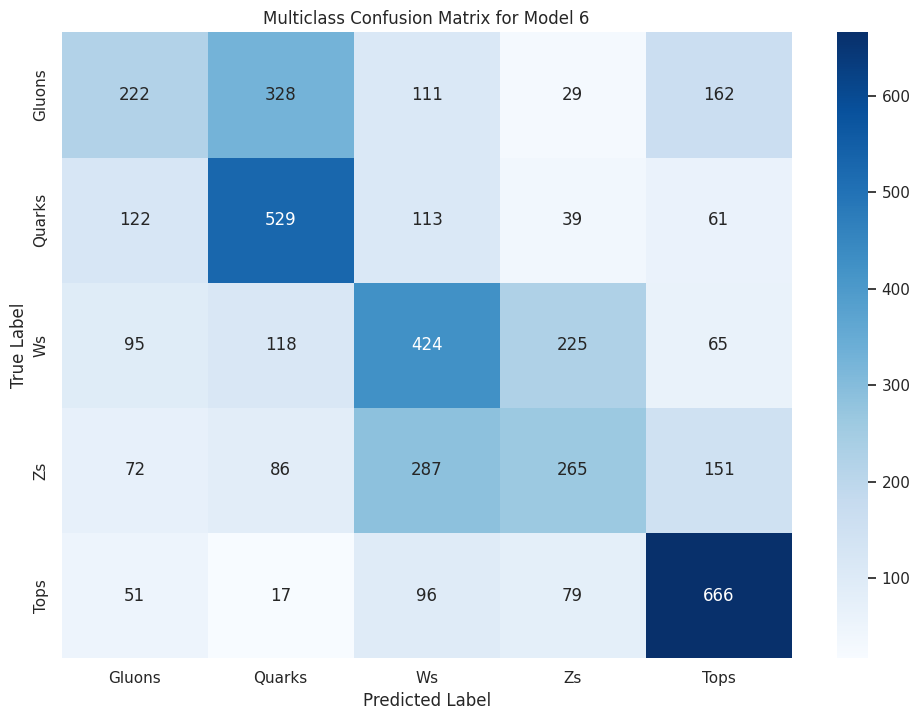

138/138 [==============================] - 3s 19ms/step


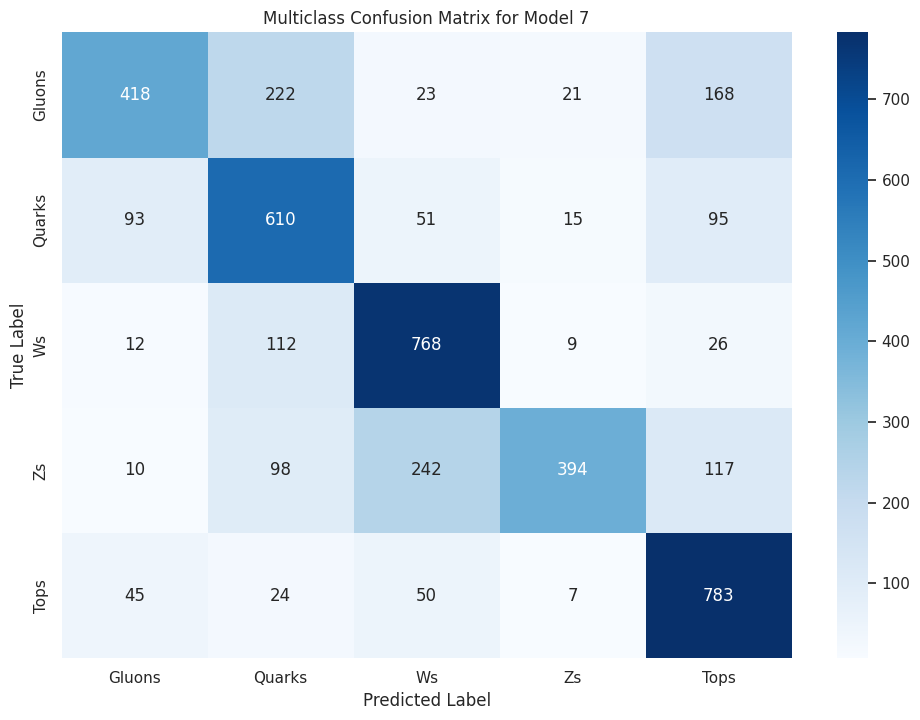

In [541]:
plot_confusion_matrices([model,model2,model3,model4,model5,model6,modelbest],
                    class_names=class_names ,
                    data= (X_val_transformed, y_val_transformed),
                    each=False)

138/138 [==============================] - 3s 25ms/step


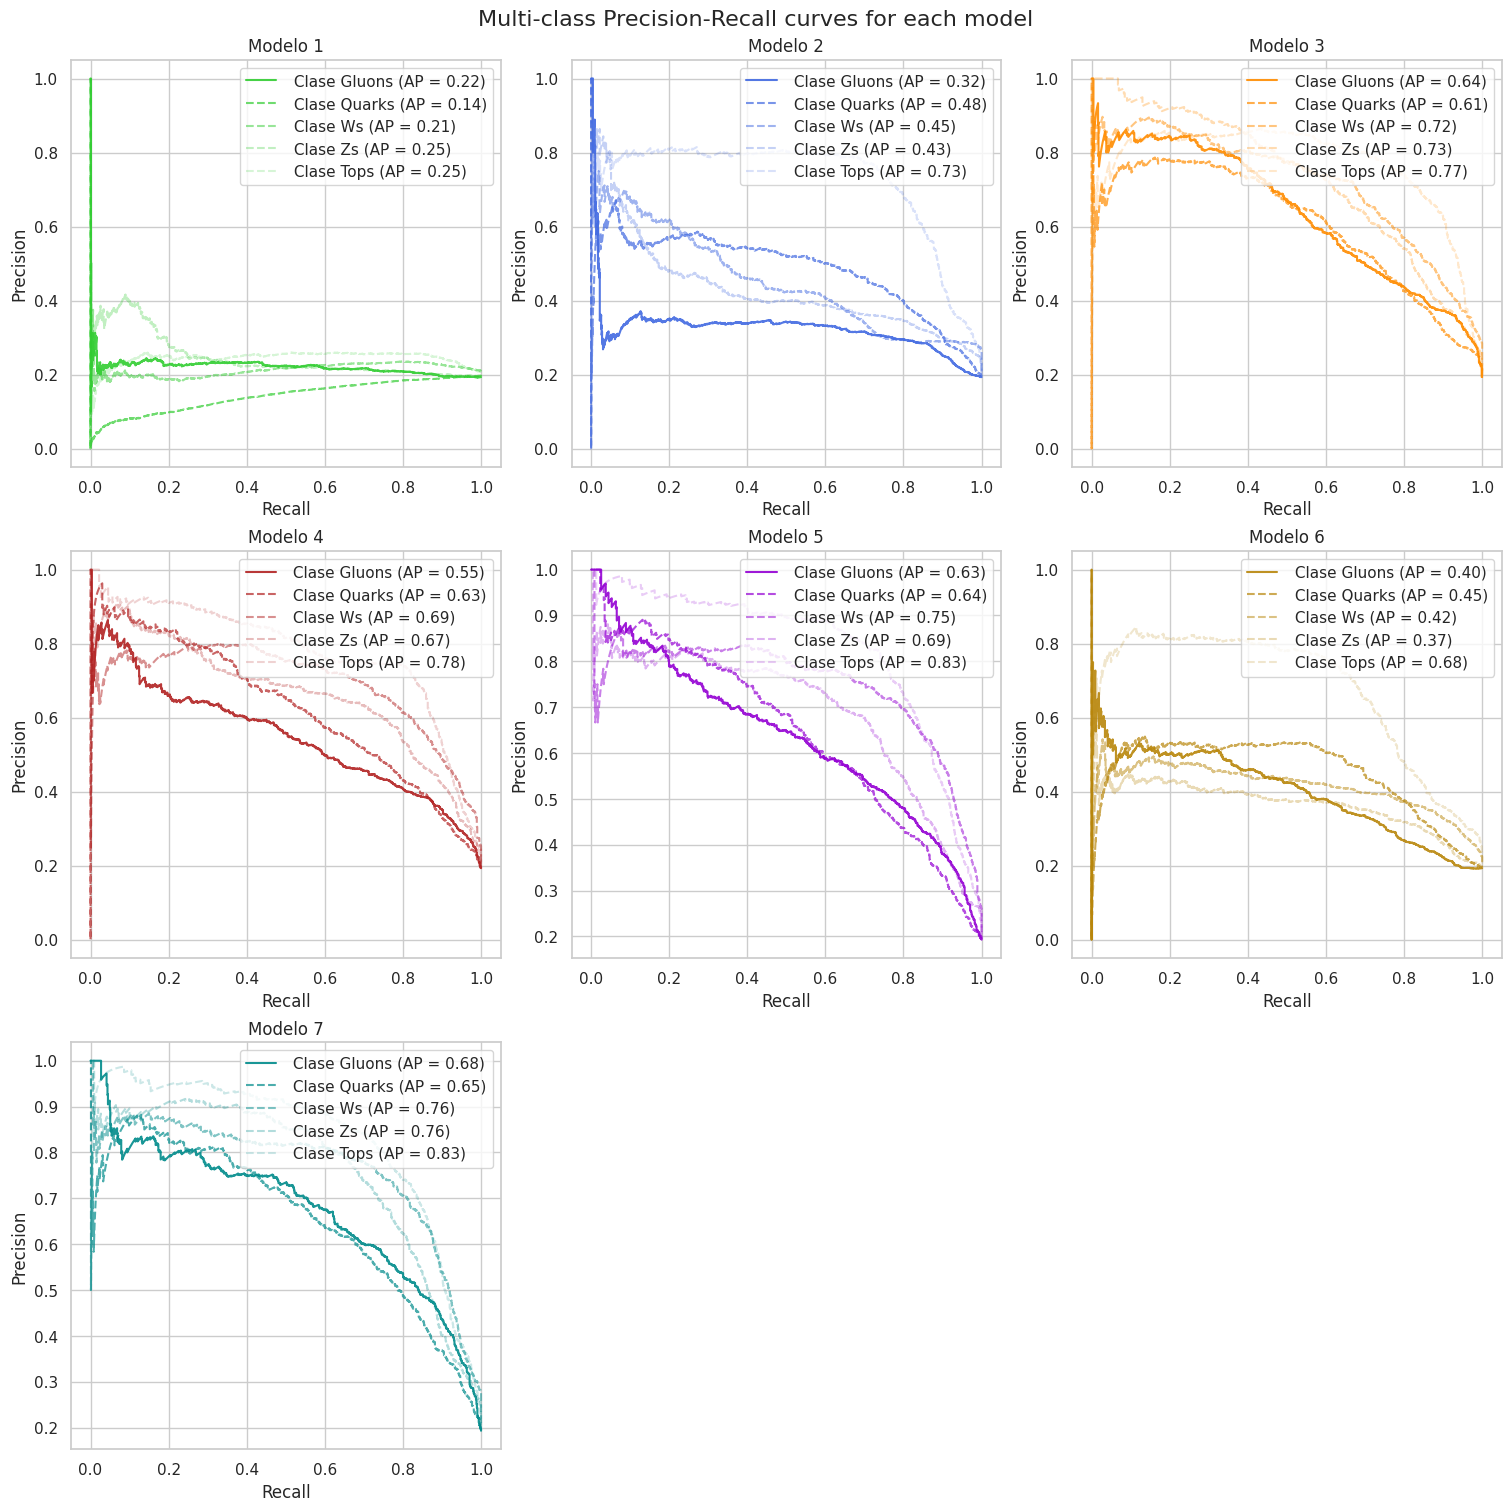

In [543]:
plot_multiclass_precision_recall([model,model2,model3,model4,model5,model6,modelbest],
                    class_names=class_names ,
                    data= (X_val_transformed, y_val_transformed),
                    each=True)

138/138 [==============================] - 2s 16ms/step


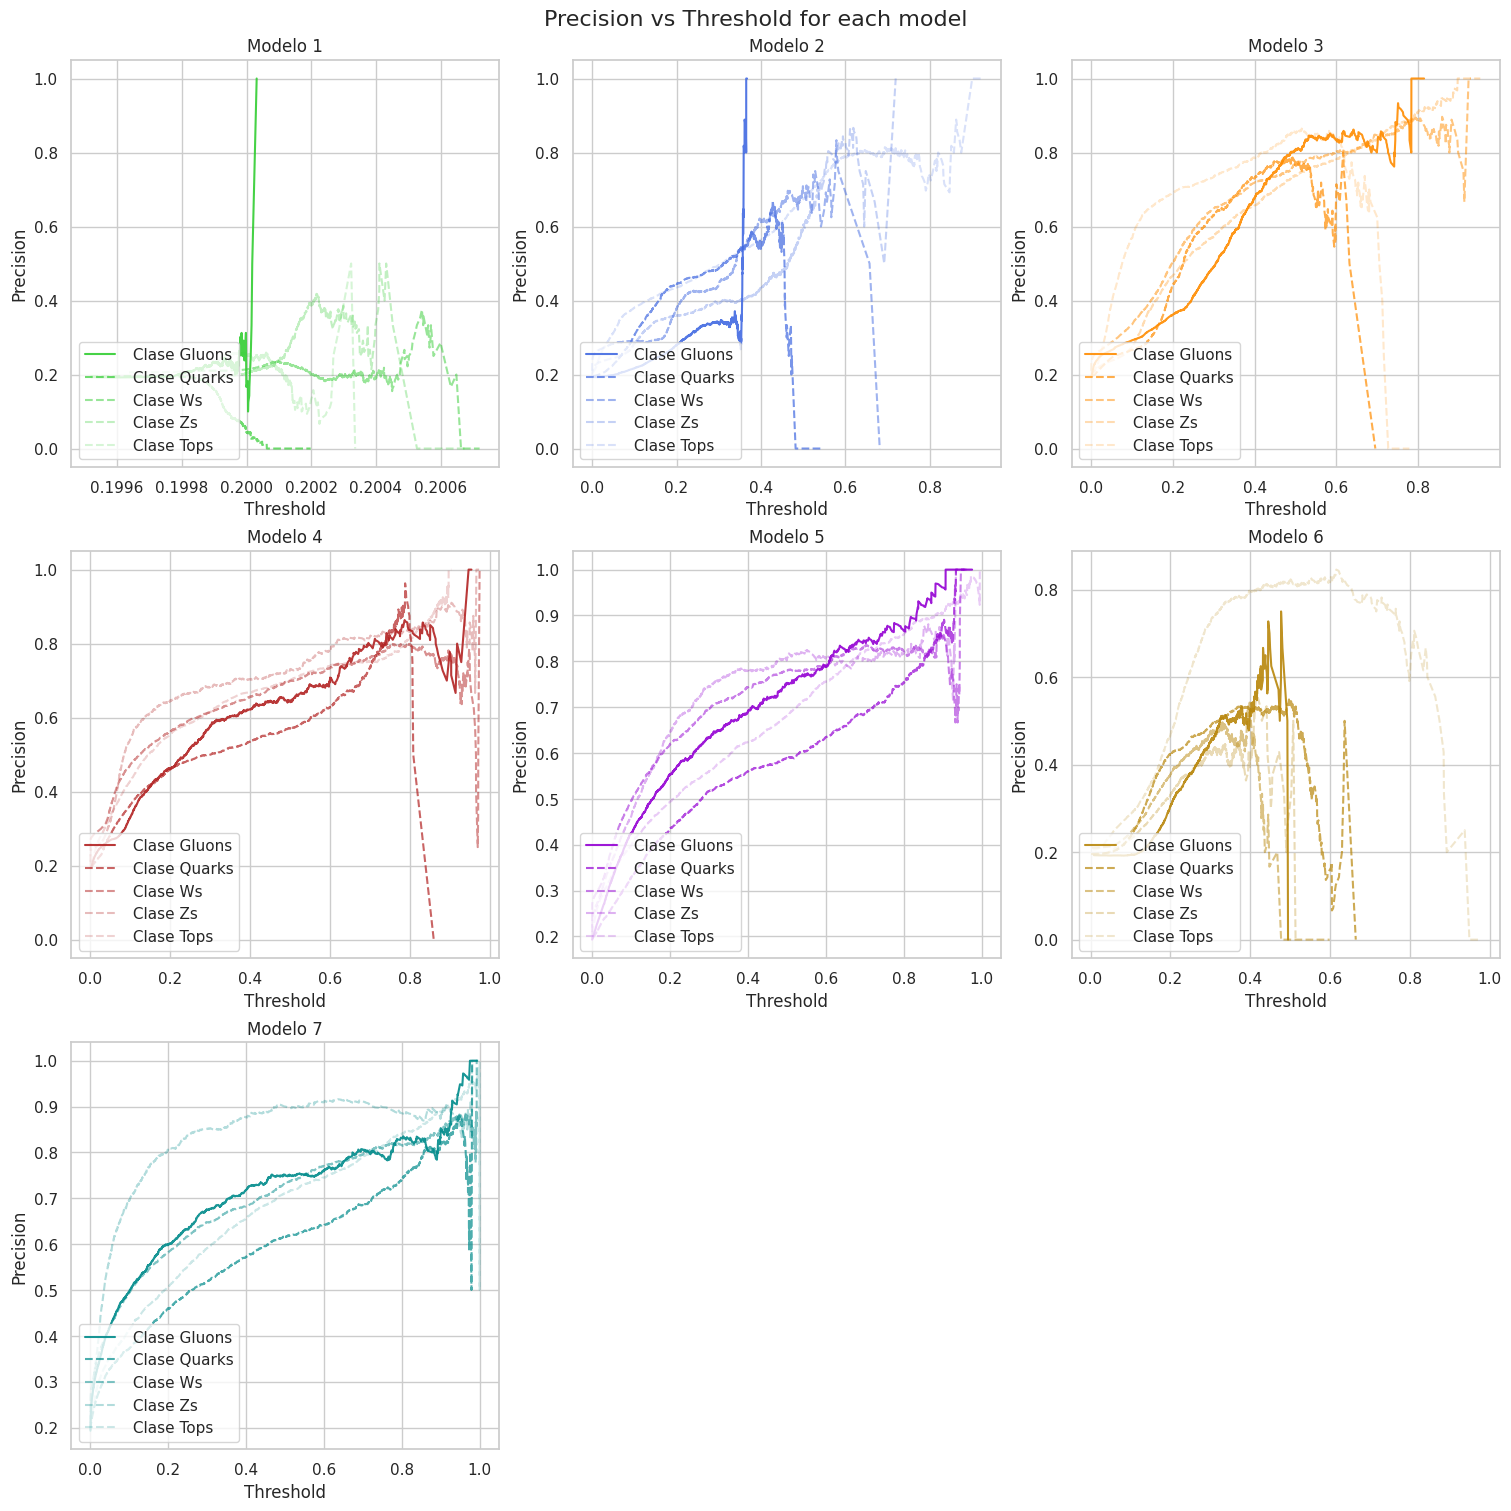

In [544]:
plot_precision_vs_threshold([model,model2,model3,model4,model5,model6,modelbest],
                    class_names=class_names ,
                    data= (X_val_transformed, y_val_transformed),
                    each=True)

138/138 [==============================] - 2s 16ms/step


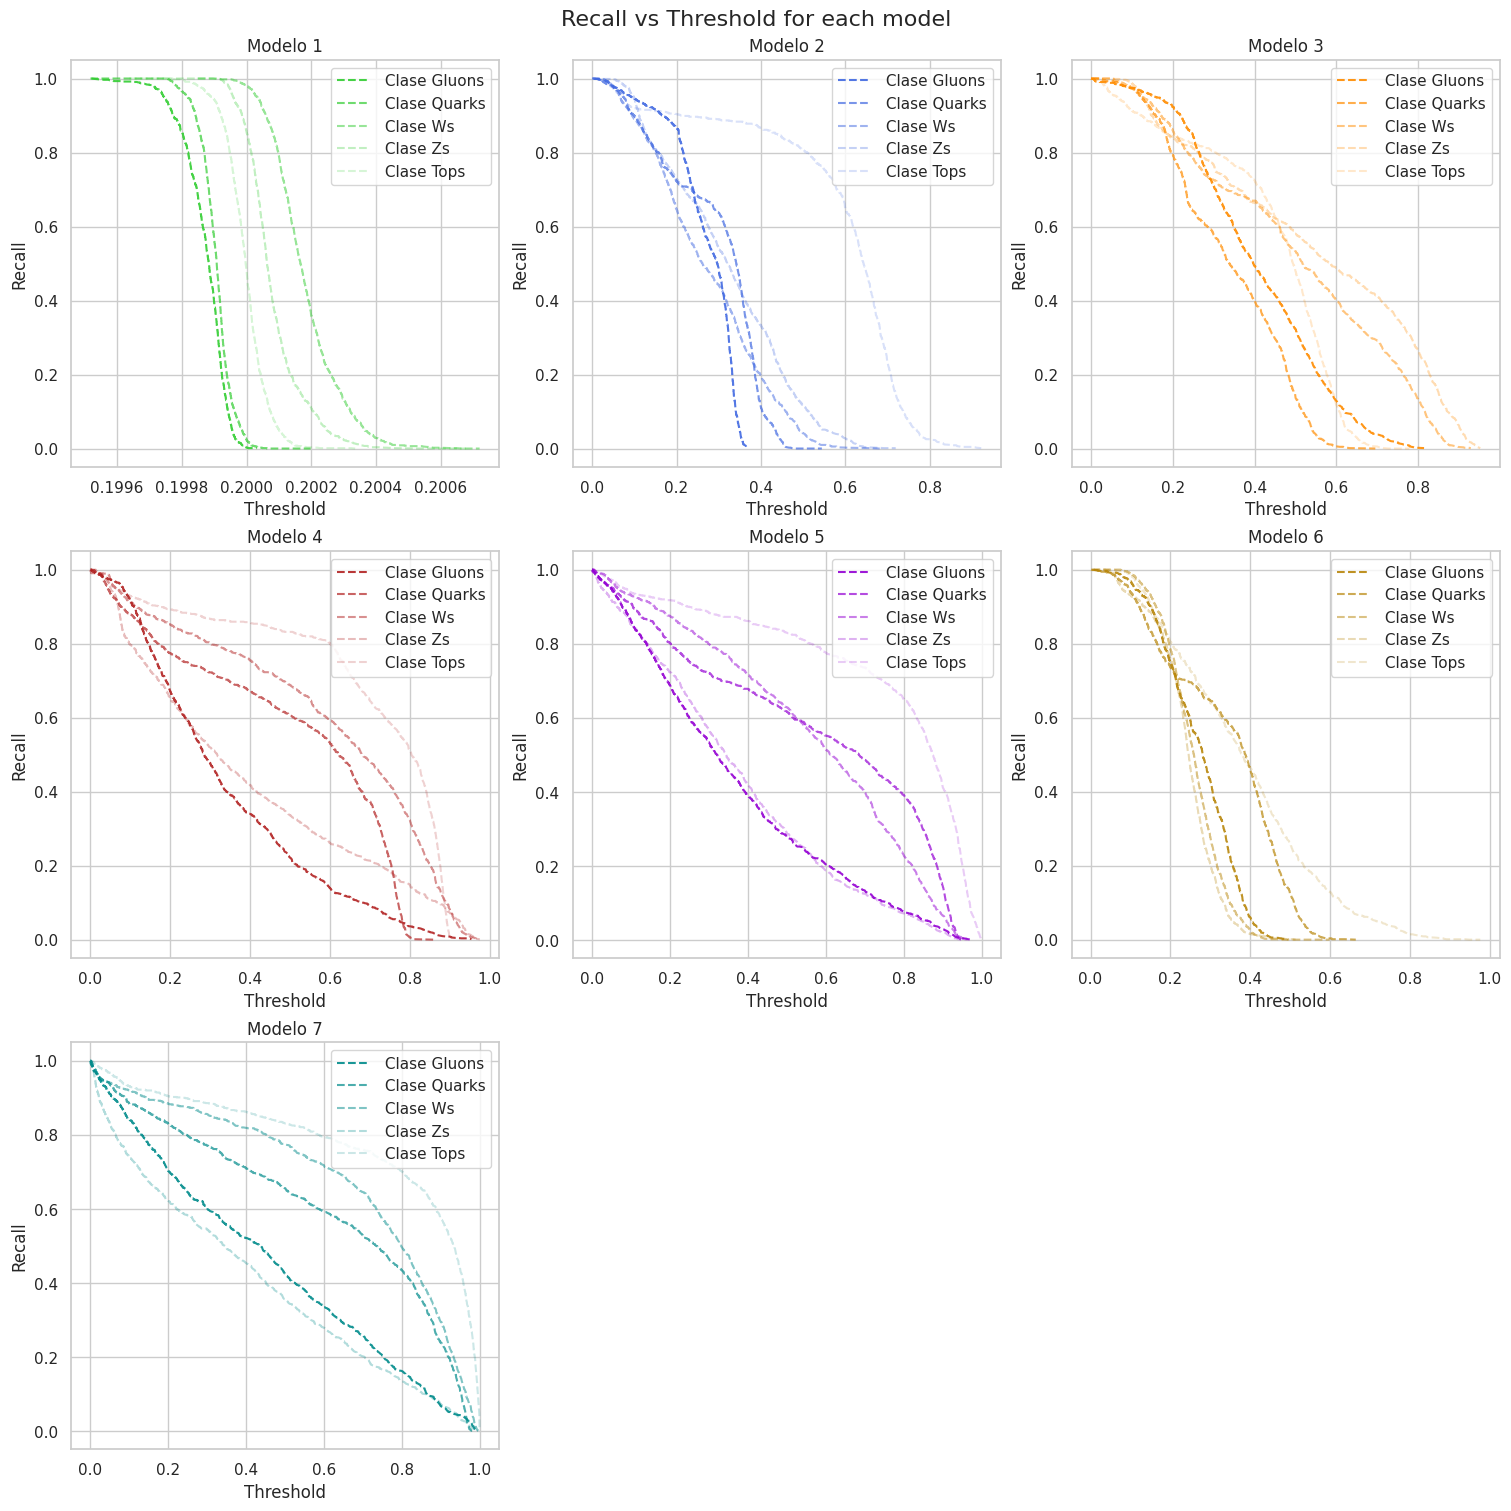

In [545]:
plot_recall_vs_threshold([model,model2,model3,model4,model5,model6,modelbest],
                    class_names=class_names ,
                    data= (X_val_transformed, y_val_transformed),
                    each=True)

138/138 [==============================] - 3s 23ms/step


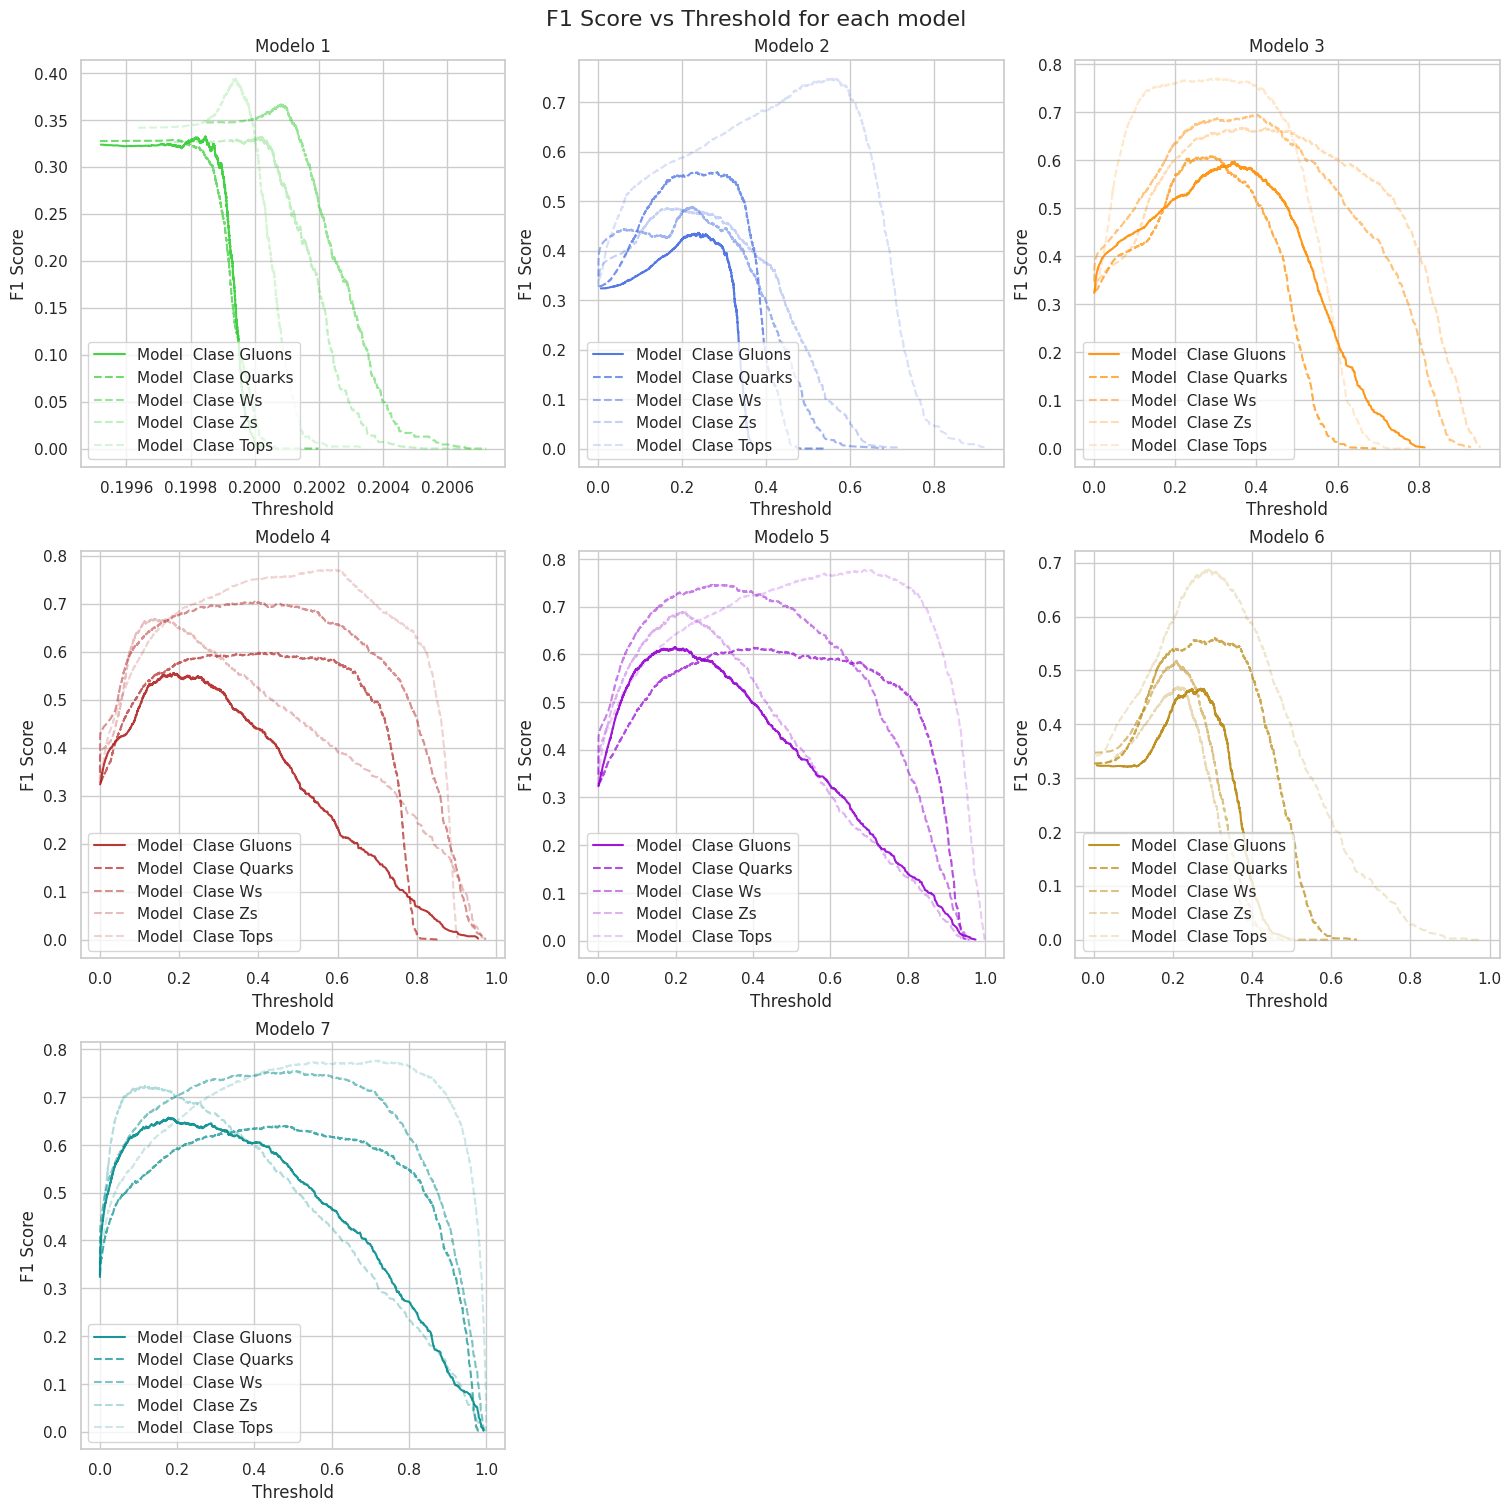

In [548]:
plot_multiclass_f1_score([model,model2,model3,model4,model5,model6,modelbest],
                    class_names=class_names,
                    data= (X_val_transformed, y_val_transformed),
                    each=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 100, 100, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 50, 50, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 25, 25, 64)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 40000)             0         
                                                                 
 dense_12 (Dense)            (None, 100)               4

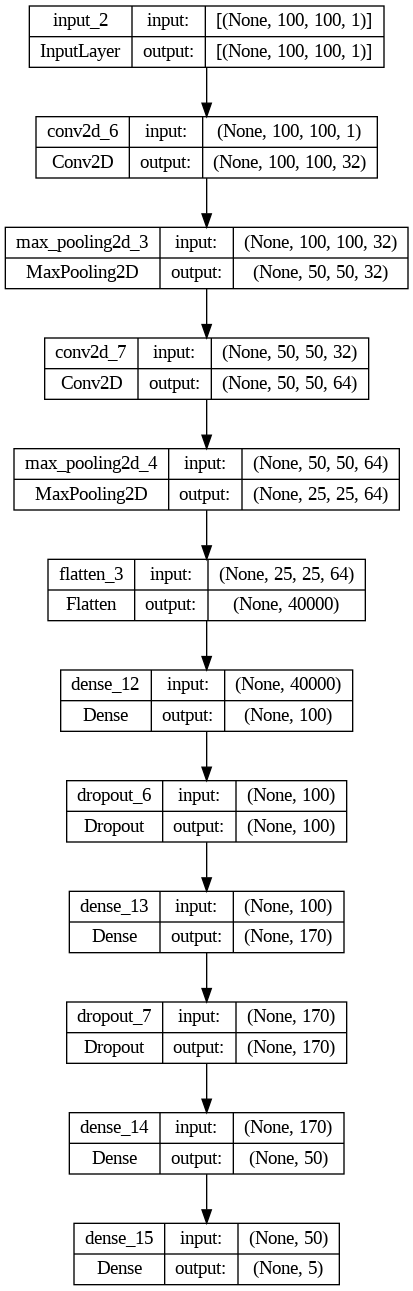

In [551]:
import tensorflow as tf

# Definir el modelo utilizando la API Sequential
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(100, 100, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
    tf.keras.layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(170, activation='relu'),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(50, activation='relu'),  # Asumiendo que `dense1=50` como en tu modelo original
    tf.keras.layers.Dense(5, activation='softmax')  # Asumiendo `num_classes=5` como en tu modelo original
])

# Muestra un resumen del modelo
model.summary()

# Opcional: Guarda el gráfico del modelo en un archivo
tf.keras.utils.plot_model(model, to_file='sequential_model_architecture.png', show_shapes=True, show_layer_names=True)
